### Preprocessing the data and generate the DF for analysis

In [5]:
import pandas as pd
gpt_4_1_annotation_results = pd.read_csv("gpt-4.1-2025-04-14_annotation_politeness_marker_system_prompt_v3_results_0.0_1_final_human_llm_all_responses_1248.csv", header=None)

# name the only single column of gpt_4_1_annotation_results to "annotated_results"
gpt_4_1_annotation_results.columns = ["gpt-4_1-annotated_results"]

gpt_4_1_annotation_results

gpt-4_1-annotated_results
0     Politeness marker: had potential\nPoliteness s...
1     Politeness marker: had potential\nPoliteness s...
2     Politeness marker: had some good points\nPolit...
3     Politeness marker: could use some work  \nPoli...
4     Politeness marker: let's go to a toastmaster's...
...                                                 ...
1243  Politeness marker: amazing\nPoliteness strateg...
1244  Politeness marker: amazing\nPoliteness strateg...
1245  Politeness marker: amazing\nPoliteness strateg...
1246  Politeness marker: Emma\nPoliteness strategy:\...
1247  Politeness marker: amazing\nPoliteness strateg...

[1248 rows x 1 columns]

In [6]:
claude_3_7_annotation_results = pd.read_csv("claude-3-7-sonnet-20250219_annotation_politeness_marker_system_prompt_v3_results_0.0_1_final_human_llm_all_responses_1248.csv", header=None)

# name the only single column of claude_3_7_annotation_results to "annotated_results"
claude_3_7_annotation_results.columns = ["claude-3_7-annotated_results"]

claude_3_7_annotation_results

claude-3_7-annotated_results
0     Politeness marker: While your presentation had...
1     Politeness marker: had potential\nPoliteness s...
2     Politeness marker: I thought your presentation...
3     Politeness marker: It could use some work\nPol...
4     Politeness marker: let's go to a toastmaster's...
...                                                 ...
1243  Politeness marker: amazing\nPoliteness strateg...
1244  Politeness marker: amazing\nPoliteness strateg...
1245  Politeness marker: amazing\nPoliteness strateg...
1246  Politeness marker: Emma\nPoliteness strategy:\...
1247  Politeness marker: amazing\nPoliteness strateg...

[1248 rows x 1 columns]

In [7]:
import re
import pandas as pd

raw_responses = pd.read_csv("../data/final_human_llm_all_responses.csv", header=None)


raw_responses.columns = ["scenarios"]

raw_responses 

# add a column called "rating"
# if "0 out of 3 hearts" in the "stimulus" column, set "rating" to 0
# if "1 out of 3 hearts" in the "stimulus" column, set "rating" to 1
# if "2 out of 3 hearts" in the "stimulus" column, set "rating" to 2
# if "3 out of 3 hearts" in the "stimulus" column, set "rating" to 3

def get_rating(stimulus):
    if "0 out of 3 hearts" in stimulus:
        return 0
    elif "1 out of 3 hearts" in stimulus:
        return 1
    elif "2 out of 3 hearts" in stimulus:
        return 2
    elif "3 out of 3 hearts" in stimulus:
        return 3
    else:
        return None
    
raw_responses["rating"] = raw_responses["scenarios"].apply(get_rating)

# add a column called "goal"
# if "If ? wanted to BOTH make ? feel good AND give accurate and informative feedback", set "goal" to "both" 
# if "If ? wanted to give as accurate and informative feedback as possible, but not necessarily make ? feel good", set "goal" to "informative"
# if "If ? wanted to make ? feel good, but not necessarily give informative feedback", set "goal" to "social"
# else, set "goal" to "default"
# "?" is a placeholder when doing the string matching

def get_goal(stimulus):
    if re.search(r"If .+ wanted to BOTH make .+ feel good AND give accurate and informative feedback", stimulus):
        return "both"
    elif re.search(r"If .+ wanted to give as accurate and informative feedback as possible, but not necessarily make .+ feel good", stimulus):
        return "informative"
    elif re.search(r"If .+ wanted to make .+ feel good, but not necessarily give informative feedback", stimulus):
        return "social"
    else:
        return "default"

raw_responses["goal"] = raw_responses["scenarios"].apply(get_goal)

raw_responses.to_csv("test.csv", index=False)

In [8]:
# concat the all_scenarios and gpt_4_1_annotation_results dataframes

scenario_with_gpt_annotation = pd.concat([raw_responses, gpt_4_1_annotation_results, claude_3_7_annotation_results], axis=1)

# add another column called golden_label, for now, keep all the rows just blank
scenario_with_gpt_annotation["golden_label"] = ""

scenario_with_gpt_annotation

scenario_with_gpt_annotation.to_csv("scenario_with_gpt_and_claude_annotation_preprocessed.csv", index=False, header=True)



### Analyze LLM-labeled politeness markers

1. I need to group the scenarios by human vs. llm
2. I need to group the scenarios by four goals
3. I need to group the scenarios by the ratings


the first is claude

the second is gpt-4o

the third is llama3



the KL-divergence should primarily be about the politeness strategy usage

for politeness markers, the data should be very sparse and not good for this divergence analysis (but I can do it)

the combination of positive and negative politeness strategy in both and other cases

In [2]:
import pandas as pd

llm_annotated_with_golden_labels_df = pd.read_csv("../results/golden_labeled_llm_annotated_politeness_markers.csv")

llm_annotated_with_golden_labels_df.columns

# lowercase all the rows items in columns gpt-4_1-annotated_result, claude-3_7-annotated_results, golden_label
llm_annotated_with_golden_labels_df["gpt-4_1-annotated_results"] = llm_annotated_with_golden_labels_df["gpt-4_1-annotated_results"].str.lower()
llm_annotated_with_golden_labels_df["claude-3_7-annotated_results"] = llm_annotated_with_golden_labels_df["claude-3_7-annotated_results"].str.lower()
llm_annotated_with_golden_labels_df["golden_label"] = llm_annotated_with_golden_labels_df["golden_label"].str.lower()


In [3]:
llm_annotated_with_golden_labels_df.columns

Index(['scenarios', 'rating', 'goal', 'gpt-4_1-annotated_results',
       'claude-3_7-annotated_results', 'golden_label'],
      dtype='object')

In [4]:
# get unique items of goal column in the llm_annotated_with_golden_labels_df
llm_annotated_with_golden_labels_df["rating"].unique(), llm_annotated_with_golden_labels_df["goal"].unique()

(array([0, 1, 2, 3]),
 array(['both', 'informative', 'social', 'default'], dtype=object))

In [5]:
human_responses = pd.read_csv("../../human_evaluation_data_cleaned_for_politeness_strategies_analysis.csv")
human_vs_LLM_preferred_response_list = human_responses[human_responses["label"] == "human_vs_LLM"]["preferred_response"].tolist()
human_vs_LLM_preferred_response_list = [x.strip() for x in human_vs_LLM_preferred_response_list]

human_vs_LLM_non_preferred_response_list = human_responses[human_responses["label"] == "human_vs_LLM"]["non_preferred_response"].tolist()
human_vs_LLM_non_preferred_response_list = [x.strip() for x in human_vs_LLM_non_preferred_response_list]

# for the llm_annotated_with_golden_labels_df, for each item in the preferred_response_list, if the item of the scenarios column contains the item, then make a new dataframe called prefered_responses_llm_annotated_with_golden_labels_df
prefered_responses_llm_annotated_with_golden_labels_df = llm_annotated_with_golden_labels_df[
    llm_annotated_with_golden_labels_df["scenarios"].apply(
        lambda x: any(item in x for item in human_vs_LLM_preferred_response_list)
    )
]

non_preferred_responses_llm_annotated_with_golden_labels_df = llm_annotated_with_golden_labels_df[
    llm_annotated_with_golden_labels_df["scenarios"].apply(
        lambda x: any(item in x for item in human_vs_LLM_non_preferred_response_list)
    )
]

In [6]:
prefered_responses_llm_annotated_with_golden_labels_df.shape, non_preferred_responses_llm_annotated_with_golden_labels_df.shape

((648, 6), (644, 6))

In [7]:
# I want to make four dataframes grouped by the goal column where there are four unique values in the goal column: array(['both', 'informative', 'social', 'default'], dtype=object)
both_df = llm_annotated_with_golden_labels_df[llm_annotated_with_golden_labels_df["goal"] == "both"]
informative_df = llm_annotated_with_golden_labels_df[llm_annotated_with_golden_labels_df["goal"] == "informative"]
social_df = llm_annotated_with_golden_labels_df[llm_annotated_with_golden_labels_df["goal"] == "social"]
default_df = llm_annotated_with_golden_labels_df[llm_annotated_with_golden_labels_df["goal"] == "default"]

# group llm_annotated_with_golden_labels_df by the rating column, where there are four different ratings: array([0, 1, 2, 3])

zero_rating_df = llm_annotated_with_golden_labels_df[llm_annotated_with_golden_labels_df["rating"] == 0]
one_rating_df = llm_annotated_with_golden_labels_df[llm_annotated_with_golden_labels_df["rating"] == 1]
two_rating_df = llm_annotated_with_golden_labels_df[llm_annotated_with_golden_labels_df["rating"] == 2]
three_rating_df = llm_annotated_with_golden_labels_df[llm_annotated_with_golden_labels_df["rating"] == 3]


# get the goal == "social" and rating == 0
social_zero_rating_df = llm_annotated_with_golden_labels_df[(llm_annotated_with_golden_labels_df["goal"] == "social") & (llm_annotated_with_golden_labels_df["rating"] == 0)]

# get the goal == "informative" and rating == 0
informative_zero_rating_df = llm_annotated_with_golden_labels_df[(llm_annotated_with_golden_labels_df["goal"] == "informative") & (llm_annotated_with_golden_labels_df["rating"] == 0)]

# get the goal == "informative" and rating == 1
informative_one_rating_df = llm_annotated_with_golden_labels_df[(llm_annotated_with_golden_labels_df["goal"] == "informative") & (llm_annotated_with_golden_labels_df["rating"] == 1)]

# get the goal == "informative" and rating == 2
informative_two_rating_df = llm_annotated_with_golden_labels_df[(llm_annotated_with_golden_labels_df["goal"] == "informative") & (llm_annotated_with_golden_labels_df["rating"] == 2)]

# get the goal == "informative" and rating == 3
informative_three_rating_df = llm_annotated_with_golden_labels_df[(llm_annotated_with_golden_labels_df["goal"] == "informative") & (llm_annotated_with_golden_labels_df["rating"] == 3)]

# get the goal == "informative" and rating == 1 or rating == 0
informative_zero_or_one_rating_df = llm_annotated_with_golden_labels_df[
    (llm_annotated_with_golden_labels_df["goal"] == "informative") & 
    ((llm_annotated_with_golden_labels_df["rating"] == 1) | (llm_annotated_with_golden_labels_df["rating"] == 0))
]

# get the goal == "informative" and rating == 2 or rating == 3
informative_two_or_three_rating_df = llm_annotated_with_golden_labels_df[
    (llm_annotated_with_golden_labels_df["goal"] == "informative") & 
    ((llm_annotated_with_golden_labels_df["rating"] == 2) | (llm_annotated_with_golden_labels_df["rating"] == 3))
]

In [8]:
len(both_df), len(informative_df), len(social_df), len(default_df), len(zero_rating_df), len(one_rating_df), len(two_rating_df), len(three_rating_df), len(informative_zero_or_one_rating_df)

(312, 312, 312, 312, 312, 312, 312, 312, 156)

In [9]:

# i want you to get 0, 6, 12, 18, etc. rows

claude_llm_annotated_with_golden_labels_df = llm_annotated_with_golden_labels_df[0::6].reset_index(drop=True)

# i want you to get 1, 7, 13, 19, etc. rows

gpt_llm_annotated_with_golden_labels_df = llm_annotated_with_golden_labels_df[1::6].reset_index(drop=True)

# i want you to get 2, 8, 14, 20, etc. rows

llama3_llm_annotated_with_golden_labels_df = llm_annotated_with_golden_labels_df[2::6].reset_index(drop=True)

# i want you to get 3, 9, 15, 21, etc. rows

human_responses_1_llm_annotated_with_golden_labels_df = llm_annotated_with_golden_labels_df[3::6].reset_index(drop=True)

# i want you to get 4, 10, 16, 22, etc. rows

human_responses_2_llm_annotated_with_golden_labels_df = llm_annotated_with_golden_labels_df[4::6].reset_index(drop=True)

# i want you to get 5, 11, 17, 23, etc. rows

human_responses_3_llm_annotated_with_golden_labels_df = llm_annotated_with_golden_labels_df[5::6].reset_index(drop=True)


# combine the claude_llm_annotated_with_golden_labels_df, gpt_llm_annotated_with_golden_labels_df, llama3_llm_annotated_with_golden_labels_df together as llm_annotated_with_golden_labels_df

llm_responses_annotated_with_golden_labels_df = pd.concat([claude_llm_annotated_with_golden_labels_df, gpt_llm_annotated_with_golden_labels_df, llama3_llm_annotated_with_golden_labels_df], axis=0).reset_index(drop=True)

# combine the human_responses_1_llm_annotated_with_golden_labels_df, human_responses_2_llm_annotated_with_golden_labels_df, human_responses_3_llm_annotated_with_golden_labels_df together as human_responses_annotated_with_golden_labels_df

human_responses_annotated_with_golden_labels_df = pd.concat([human_responses_1_llm_annotated_with_golden_labels_df, human_responses_2_llm_annotated_with_golden_labels_df, human_responses_3_llm_annotated_with_golden_labels_df], axis=0).reset_index(drop=True)

# get the goal == "informative" and rating == 2 or rating == 3 for llm_responses_annotated_with_golden_labels_df
informative_two_or_three_rating_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["goal"] == "informative") & 
    ((llm_responses_annotated_with_golden_labels_df["rating"] == 2) | (llm_responses_annotated_with_golden_labels_df["rating"] == 3))
].reset_index(drop=True)

# get the goal == "informative" and rating == 2 or rating == 3 for human_responses_annotated_with_golden_labels_df
informative_two_or_three_rating_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["goal"] == "informative") & 
    ((human_responses_annotated_with_golden_labels_df["rating"] == 2) | (human_responses_annotated_with_golden_labels_df["rating"] == 3))
].reset_index(drop=True)

# get the rating == 0 for llm_responses_annotated_with_golden_labels_df
rating_zero_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 0)
].reset_index(drop=True)

# get the rating == 0 for human_responses_annotated_with_golden_labels_df
rating_zero_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 0)
].reset_index(drop=True)

# get the rating == 1 for llm_responses_annotated_with_golden_labels_df
rating_one_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 1)
].reset_index(drop=True)

# get the rating == 1 for human_responses_annotated_with_golden_labels_df
rating_one_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 1)
].reset_index(drop=True)

# get the rating == 2 for llm_responses_annotated_with_golden_labels_df
rating_two_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 2)
].reset_index(drop=True)

# get the rating == 2 for human_responses_annotated_with_golden_labels_df
rating_two_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 2)
].reset_index(drop=True)

# get the rating == 3 for llm_responses_annotated_with_golden_labels_df
rating_three_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 3)
].reset_index(drop=True)

# get the rating == 3 for human_responses_annotated_with_golden_labels_df
rating_three_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 3)
].reset_index(drop=True)

# get the rating == 0 and goal == "both" for llm_responses_annotated_with_golden_labels_df
rating_zero_both_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 0) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "both")
].reset_index(drop=True)

# get the rating == 0 and goal == "both" for human_responses_annotated_with_golden_labels_df
rating_zero_both_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 0) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "both")
].reset_index(drop=True)

# get the rating == 1 and goal == "both" for llm_responses_annotated_with_golden_labels_df
rating_one_both_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 1) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "both")
].reset_index(drop=True)

# get the rating == 1 and goal == "both" for human_responses_annotated_with_golden_labels_df
rating_one_both_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 1) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "both")
].reset_index(drop=True)

# get the rating == 2 and goal == "both" for llm_responses_annotated_with_golden_labels_df
rating_two_both_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 2) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "both")
].reset_index(drop=True)

# get the rating == 2 and goal == "both" for human_responses_annotated_with_golden_labels_df
rating_two_both_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 2) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "both")
].reset_index(drop=True)

# get the rating == 3 and goal == "both" for llm_responses_annotated_with_golden_labels_df
rating_three_both_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 3) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "both")
].reset_index(drop=True)

# get the rating == 3 and goal == "both" for human_responses_annotated_with_golden_labels_df
rating_three_both_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 3) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "both")
].reset_index(drop=True)

# get the rating == 0 and goal == "informative" for llm_responses_annotated_with_golden_labels_df
rating_zero_informative_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 0) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "informative")
].reset_index(drop=True)

# get the rating == 0 and goal == "informative" for human_responses_annotated_with_golden_labels_df
rating_zero_informative_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 0) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "informative")
].reset_index(drop=True)

# get the rating == 1 and goal == "informative" for llm_responses_annotated_with_golden_labels_df
rating_one_informative_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 1) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "informative")
].reset_index(drop=True)

# get the rating == 1 and goal == "informative" for human_responses_annotated_with_golden_labels_df
rating_one_informative_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 1) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "informative")
].reset_index(drop=True)

# get the rating == 2 and goal == "informative" for llm_responses_annotated_with_golden_labels_df
rating_two_informative_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 2) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "informative")
].reset_index(drop=True)

# get the rating == 2 and goal == "informative" for human_responses_annotated_with_golden_labels_df
rating_two_informative_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 2) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "informative")
].reset_index(drop=True)

# get the rating == 3 and goal == "informative" for llm_responses_annotated_with_golden_labels_df
rating_three_informative_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 3) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "informative")
].reset_index(drop=True)

# get the rating == 3 and goal == "informative" for human_responses_annotated_with_golden_labels_df
rating_three_informative_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 3) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "informative")
].reset_index(drop=True)

# get the rating == 0 and goal == "social" for llm_responses_annotated_with_golden_labels_df
rating_zero_social_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 0) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "social")
].reset_index(drop=True)

# get the rating == 0 and goal == "social" for human_responses_annotated_with_golden_labels_df
rating_zero_social_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 0) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "social")
].reset_index(drop=True)

# get the rating == 1 and goal == "social" for llm_responses_annotated_with_golden_labels_df
rating_one_social_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 1) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "social")
].reset_index(drop=True)

# get the rating == 1 and goal == "social" for human_responses_annotated_with_golden_labels_df
rating_one_social_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 1) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "social")
].reset_index(drop=True)

# get the rating == 2 and goal == "social" for llm_responses_annotated_with_golden_labels_df
rating_two_social_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 2) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "social")
].reset_index(drop=True)

# get the rating == 2 and goal == "social" for human_responses_annotated_with_golden_labels_df
rating_two_social_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 2) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "social")
].reset_index(drop=True)

# get the rating == 3 and goal == "social" for llm_responses_annotated_with_golden_labels_df
rating_three_social_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 3) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "social")
].reset_index(drop=True)

# get the rating == 3 and goal == "social" for human_responses_annotated_with_golden_labels_df
rating_three_social_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 3) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "social")
].reset_index(drop=True)

# get the rating == 0 and goal == "default" for llm_responses_annotated_with_golden_labels_df
rating_zero_default_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 0) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "default")
].reset_index(drop=True)

# get the rating == 0 and goal == "default" for human_responses_annotated_with_golden_labels_df
rating_zero_default_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 0) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "default")
].reset_index(drop=True)

# get the rating == 1 and goal == "default" for llm_responses_annotated_with_golden_labels_df
rating_one_default_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 1) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "default")
].reset_index(drop=True)

# get the rating == 1 and goal == "default" for human_responses_annotated_with_golden_labels_df
rating_one_default_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 1) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "default")
].reset_index(drop=True)

# get the rating == 2 and goal == "default" for llm_responses_annotated_with_golden_labels_df
rating_two_default_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 2) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "default")
].reset_index(drop=True)

# get the rating == 2 and goal == "default" for human_responses_annotated_with_golden_labels_df
rating_two_default_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 2) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "default")
].reset_index(drop=True)

# get the rating == 3 and goal == "default" for llm_responses_annotated_with_golden_labels_df
rating_three_default_llm_responses_annotated_with_golden_labels_df = llm_responses_annotated_with_golden_labels_df[
    (llm_responses_annotated_with_golden_labels_df["rating"] == 3) &
    (llm_responses_annotated_with_golden_labels_df["goal"] == "default")
].reset_index(drop=True)

# get the rating == 3 and goal == "default" for human_responses_annotated_with_golden_labels_df
rating_three_default_human_responses_annotated_with_golden_labels_df = human_responses_annotated_with_golden_labels_df[
    (human_responses_annotated_with_golden_labels_df["rating"] == 3) &
    (human_responses_annotated_with_golden_labels_df["goal"] == "default")
].reset_index(drop=True)

In [10]:
# here is an example of the value of the golden_label column
# 'Politeness marker: had potential\nPoliteness strategy:\n1. Positive Politeness + Include both speaker and hearer (inclusive ‘we’)\n2. Positive Politeness + Presuppose/assert common ground (we can both get better)\n\nPoliteness marker: we could work on together\nPoliteness strategy:\n1. Positive Politeness - Include both speaker and hearer (inclusive 'we')\n\nPoliteness marker: much stronger next time\nPoliteness strategy:\n1. Positive Politeness - Be optimistic'

# i want you to extract the politeness marker and politeness strategy from the golden_label column

import re

def extract_politeness_info(text):
    if pd.isna(text):
        return [], []
        
    # Extract politeness markers
    politeness_markers = re.findall(r'politeness marker:(.*?)(?=politeness strategy:|$)', text, re.DOTALL)
    markers = [marker.strip() for marker in politeness_markers]

    politeness_strategies = re.findall(r'politeness strategy:(.*?)(?=politeness marker:|$)', text, re.DOTALL)
    
    # Process each block into cleaned list of strategies
    strategies = []
    for block in politeness_strategies:
        # Replace all types of line separators with a standard newline
        normalized_block = re.sub(r'[\n\r\u2028\u2029]+', '\n', block.strip())
        
        # Split by common strategy delimiters
        strategy_lines = re.split(r'(?:\n|\d+\.\s*)', normalized_block)
        
        # Clean and add non-empty strategies
        for line in strategy_lines:
            line = line.strip()
            if line:
                strategies.append(line)

    # Extract politeness markers and strategies
    # politeness_markers = re.findall(r'Politeness marker:(.*?)(?=\nPoliteness strategy:|$)', text)
    # markers = [marker.strip() for marker in politeness_markers]
    # politeness_strategies = re.findall(r'Politeness strategy:\n(.*?)(?=\nPoliteness marker:|$)', text, re.DOTALL)
    # strategies = [strategy.strip() for strategy in politeness_strategies]
    
    return markers, strategies

# Apply the extraction to the golden_label column
for df in [llm_annotated_with_golden_labels_df, 
           both_df, informative_df, social_df, default_df,
           zero_rating_df, one_rating_df, two_rating_df, three_rating_df,
           llm_responses_annotated_with_golden_labels_df, human_responses_annotated_with_golden_labels_df,
           informative_two_or_three_rating_llm_responses_annotated_with_golden_labels_df, 
           informative_two_or_three_rating_human_responses_annotated_with_golden_labels_df,
           social_zero_rating_df, informative_zero_rating_df, informative_one_rating_df,
           informative_two_rating_df, informative_three_rating_df,
           informative_zero_or_one_rating_df, informative_two_or_three_rating_df,
           
           rating_zero_llm_responses_annotated_with_golden_labels_df,
           rating_zero_human_responses_annotated_with_golden_labels_df,
           rating_one_llm_responses_annotated_with_golden_labels_df,
           rating_one_human_responses_annotated_with_golden_labels_df,
           rating_two_llm_responses_annotated_with_golden_labels_df,
           rating_two_human_responses_annotated_with_golden_labels_df,
           rating_three_llm_responses_annotated_with_golden_labels_df,
           rating_three_human_responses_annotated_with_golden_labels_df,

           rating_zero_both_llm_responses_annotated_with_golden_labels_df,
           rating_zero_both_human_responses_annotated_with_golden_labels_df,
           rating_one_both_llm_responses_annotated_with_golden_labels_df,
           rating_one_both_human_responses_annotated_with_golden_labels_df,
           rating_two_both_llm_responses_annotated_with_golden_labels_df,
           rating_two_both_human_responses_annotated_with_golden_labels_df,
           rating_three_both_llm_responses_annotated_with_golden_labels_df,
           rating_three_both_human_responses_annotated_with_golden_labels_df,
           
           rating_zero_informative_llm_responses_annotated_with_golden_labels_df,
           rating_zero_informative_human_responses_annotated_with_golden_labels_df,
           rating_one_informative_llm_responses_annotated_with_golden_labels_df,
           rating_one_informative_human_responses_annotated_with_golden_labels_df,
           rating_two_informative_llm_responses_annotated_with_golden_labels_df,
           rating_two_informative_human_responses_annotated_with_golden_labels_df,
           rating_three_informative_llm_responses_annotated_with_golden_labels_df,
           rating_three_informative_human_responses_annotated_with_golden_labels_df,
           
           rating_zero_social_llm_responses_annotated_with_golden_labels_df,
           rating_zero_social_human_responses_annotated_with_golden_labels_df,
           rating_one_social_llm_responses_annotated_with_golden_labels_df,
           rating_one_social_human_responses_annotated_with_golden_labels_df,
           rating_two_social_llm_responses_annotated_with_golden_labels_df,
           rating_two_social_human_responses_annotated_with_golden_labels_df,
           rating_three_social_llm_responses_annotated_with_golden_labels_df,
           rating_three_social_human_responses_annotated_with_golden_labels_df,
           
           rating_zero_default_llm_responses_annotated_with_golden_labels_df,
           rating_zero_default_human_responses_annotated_with_golden_labels_df,
           rating_one_default_llm_responses_annotated_with_golden_labels_df,
           rating_one_default_human_responses_annotated_with_golden_labels_df,
           rating_two_default_llm_responses_annotated_with_golden_labels_df,
           rating_two_default_human_responses_annotated_with_golden_labels_df,
           rating_three_default_llm_responses_annotated_with_golden_labels_df,
           rating_three_default_human_responses_annotated_with_golden_labels_df,
           
           prefered_responses_llm_annotated_with_golden_labels_df,
           non_preferred_responses_llm_annotated_with_golden_labels_df]:
    
    df['gpt-4_1-annotated_politeness_markers'], df['gpt-4_1-annotated_politeness_strategies'] = zip(*df['gpt-4_1-annotated_results'].apply(extract_politeness_info))
    df['claude-3_7-annotated_politeness_markers'], df['claude-3_7-annotated_politeness_strategies'] = zip(*df['claude-3_7-annotated_results'].apply(extract_politeness_info))
    df['golden_politeness_markers'], df['golden_politeness_strategies'] = zip(*df['golden_label'].apply(extract_politeness_info))

/var/folders/rd/r290740569q845dpgz6y3r840000gn/T/ipykernel_93518/3795844063.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gpt-4_1-annotated_politeness_markers'], df['gpt-4_1-annotated_politeness_strategies'] = zip(*df['gpt-4_1-annotated_results'].apply(extract_politeness_info))
/var/folders/rd/r290740569q845dpgz6y3r840000gn/T/ipykernel_93518/3795844063.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gpt-4_1-annotated_politeness_markers'], df['gpt-4_1-annotated_politeness_strategies'] =

In [11]:
llm_annotated_with_golden_labels_df.iloc[233]['golden_politeness_strategies']

['positive politeness - positive lexicon (positive sentiment, optimism)',
 'positive politeness - positive lexicon (positive sentiment, optimism)']

I mainly do the analysis of the politeness strategies

First, I need to preprocessing the politeness strategies to make sure they all have the same name

then I will concat all the politeness strategies list from all the rows into one list

and do the frequency count to generate a list of politeness strategies and their frequencies

I will rank the politeness strategies by their frequencies and get the top 15 politeness strategies for each LLM and human

and I will do the diveregence analysis with the frequency dictionaries

In [12]:
# can you write above all preprocessing as a function
def preprocess_politeness_strategies(df, column_name):

     # for the "gpt-4_1-annotated_politeness_strategies" column in llm_annotated_with_golden_labels_df
     # each element in this column is a list, I want to concat all the lists into one list

     # gpt-4_1-annotated_politeness_strategies, claude-3_7-annotated_politeness_strategies
     all_politeness_strategies = [item for sublist in df[column_name] for item in sublist]

     # remove all the empty strings in the list
     all_politeness_strategies = [item for item in all_politeness_strategies if item]

     # lowercase all the letters
     all_politeness_strategies = [item.lower() for item in all_politeness_strategies]


     # remove all the numbers in each element of the list
     # for example, "1. Positive Politeness - Positive Lexicon (positive sentiment, optimism)" should be "Positive Politeness - Positive Lexicon (positive sentiment, optimism)"

     all_politeness_strategies = [re.sub(r'^\d+\.\s*', '', item) for item in all_politeness_strategies]

     # remove the () and everything inside the ()

     all_politeness_strategies = [re.sub(r'\(.*?\)', '', item) for item in all_politeness_strategies]

     # remove the extra spaces
     all_politeness_strategies = [item.strip() for item in all_politeness_strategies]

     # replace all the "+" with "-"

     all_politeness_strategies = [item.replace("+", "-") for item in all_politeness_strategies]
     all_politeness_strategies = [item.replace("–", "-") for item in all_politeness_strategies]

     # if "hedge" in the item, the replace the item to 'negative politeness - question, hedge'
     all_politeness_strategies = ['negative politeness - question, hedge' if 'hedge' in item else item for item in all_politeness_strategies]

     all_politeness_strategies = [item for item in all_politeness_strategies if item != '']

     # if item is 'negative politeness' or 'positive politeness' or 'off-record' or 'none detected.' or 'bald-on-record', then remove it
     all_politeness_strategies = [item for item in all_politeness_strategies if item not in ['negative politeness', 'positive politeness', 'off-record', 'none detected.', 'bald-on-record']]

     # if item is "bald-on-record - direct commands/statements", then replace it with 'bald-on-record - direct command'
     all_politeness_strategies = ['bald-on-record - direct command' if item == 'bald-on-record - direct commands/statements' else item for item in all_politeness_strategies]

     # remove all the white space before and after "-"
     all_politeness_strategies = [re.sub(r'\s*-\s*', '-', item) for item in all_politeness_strategies]

     # replace ""Bald-on-Record Strategies" with "Bald-on-Record"

     all_politeness_strategies = [item.replace("bald-on-record strategies", "bald-on-record") for item in all_politeness_strategies]
     all_politeness_strategies = [item.replace("negative politeness strategies", "negative politeness") for item in all_politeness_strategies]
     all_politeness_strategies = [item.replace("off-record  strategies", "off-record") for item in all_politeness_strategies]
     all_politeness_strategies = [item.replace("positive politeness strategies", "positive politeness") for item in all_politeness_strategies]
     all_politeness_strategies = [item.replace('positive politeness-notice, attend to hearer’s interests, wants, needs', "positive politeness-notice, attend to hearer's interests, wants, needs") for item in all_politeness_strategies]
     all_politeness_strategies = [item.replace('positive politeness-assert speaker’s knowledge of hearer’s wants', "positive politeness-assert speaker's knowledge of hearer's wants") for item in all_politeness_strategies]

     # remove the - in "bald-on-record" and "off-record"
     all_politeness_strategies = [item.replace("bald-on-record", "bald on record") for item in all_politeness_strategies]
     all_politeness_strategies = [item.replace("off-record", "off record") for item in all_politeness_strategies]
     all_politeness_strategies = [item.replace('bald on record-direct commands', 'bald on record-direct command') for item in all_politeness_strategies]
     all_politeness_strategies = [item.replace('off record-understate (some improvements', 'off record-understate') for item in all_politeness_strategies]
     all_politeness_strategies = [item.replace('positive politeness-give gifts to hearer (sympathy, understanding, cooperatio', 'positive politeness-give gifts to hearer') for item in all_politeness_strategies]

     # if item is 'negative politeness-minimize the impositio', then replace it with 'negative politeness-minimize the imposition'
     all_politeness_strategies = ['negative politeness-minimize the imposition' if item == 'negative politeness-minimize the impositio' else item for item in all_politeness_strategies]
     all_politeness_strategies = ['positive politeness-be optimistic' if item == 'positive politeness-be optimisti' else item for item in all_politeness_strategies]


     # remove these strategies: negative politeness-be specific, minimize imposition, negative politeness-give or ask for reasons, negative politeness-give reasons, off record-be specific, off record-use in-group identity markers
     all_politeness_strategies = [item for item in all_politeness_strategies if item not in [
     'negative politeness-be specific, minimize imposition',
     'negative politeness-give or ask for reasons',
     'negative politeness-give reasons',
     'off record-be specific',
     'off record-use in-group identity markers',
     'negative politeness-be optimistic',
     'negative politeness-be pessimistic',
     'negative politeness-be specific',
     'negative politeness-be specific about criticism',
     'negative politeness-please',
     'negative politeness-understate',
     'negative politeness-be vague',
     'off record-euphemism',
     'positive politeness-be specific about what was good',
     'positive politeness-compliment',
     'positive politeness-offer encouragement',
     'positive politeness-offer praise/compliment',
     '[none]',
          'none'
     ]]

     return all_politeness_strategies



# Apply the preprocessing function

# golden_politeness_strategies = [item for sublist in llm_annotated_with_golden_labels_df['golden_politeness_strategies'] for item in sublist]
all_golden_politeness_strategies = preprocess_politeness_strategies(llm_annotated_with_golden_labels_df, 'golden_politeness_strategies')

# all_gpt_4_1_politeness_strategies = [item for sublist in llm_annotated_with_golden_labels_df['gpt-4_1-annotated_politeness_strategies'] for item in sublist]
# all_claude_3_7_politeness_strategies = [item for sublist in llm_annotated_with_golden_labels_df['claude-3_7-annotated_politeness_strategies'] for item in sublist]
all_gpt_4_1_politeness_strategies = preprocess_politeness_strategies(llm_annotated_with_golden_labels_df,  'gpt-4_1-annotated_politeness_strategies')
all_claude_3_7_politeness_strategies = preprocess_politeness_strategies(llm_annotated_with_golden_labels_df, 'claude-3_7-annotated_politeness_strategies')

all_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
all_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')

both_goal_responses_golden_politeness_strategies = preprocess_politeness_strategies(both_df, 'golden_politeness_strategies')
informative_goal_responses_golden_politeness_strategies = preprocess_politeness_strategies(informative_df, 'golden_politeness_strategies')
social_goal_responses_golden_politeness_strategies = preprocess_politeness_strategies(social_df, 'golden_politeness_strategies')
default_goal_responses_golden_politeness_strategies = preprocess_politeness_strategies(default_df, 'golden_politeness_strategies')

zero_rating_responses_golden_politeness_strategies = preprocess_politeness_strategies(zero_rating_df, 'golden_politeness_strategies')
one_rating_responses_golden_politeness_strategies = preprocess_politeness_strategies(one_rating_df, 'golden_politeness_strategies')
two_rating_responses_golden_politeness_strategies = preprocess_politeness_strategies(two_rating_df, 'golden_politeness_strategies')
three_rating_responses_golden_politeness_strategies = preprocess_politeness_strategies(three_rating_df, 'golden_politeness_strategies')

informative_zero_or_one_rating_responses_golden_politeness_strategies = preprocess_politeness_strategies(informative_zero_or_one_rating_df, 'golden_politeness_strategies')
informative_two_or_three_rating_responses_golden_politeness_strategies = preprocess_politeness_strategies(informative_two_or_three_rating_df, 'golden_politeness_strategies')

social_zero_rating_responses_golden_politeness_strategies = preprocess_politeness_strategies(social_zero_rating_df, 'golden_politeness_strategies')
informative_zero_rating_responses_golden_politeness_strategies = preprocess_politeness_strategies(informative_zero_rating_df, 'golden_politeness_strategies')
informative_one_rating_responses_golden_politeness_strategies = preprocess_politeness_strategies(informative_one_rating_df, 'golden_politeness_strategies')
informative_two_rating_responses_golden_politeness_strategies = preprocess_politeness_strategies(informative_two_rating_df, 'golden_politeness_strategies')
informative_three_rating_responses_golden_politeness_strategies = preprocess_politeness_strategies(informative_three_rating_df, 'golden_politeness_strategies')

informative_two_or_three_rating_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(informative_two_or_three_rating_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
informative_two_or_three_rating_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(informative_two_or_three_rating_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')

rating_zero_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_zero_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_zero_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_zero_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_one_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_one_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_one_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_one_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_two_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_two_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_two_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_two_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_three_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_three_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_three_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_three_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')

rating_zero_both_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_zero_both_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_zero_both_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_zero_both_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_one_both_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_one_both_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_one_both_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_one_both_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_two_both_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_two_both_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_two_both_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_two_both_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_three_both_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_three_both_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_three_both_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_three_both_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')

rating_zero_informative_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_zero_informative_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_zero_informative_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_zero_informative_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_one_informative_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_one_informative_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_one_informative_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_one_informative_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_two_informative_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_two_informative_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_two_informative_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_two_informative_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_three_informative_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_three_informative_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_three_informative_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_three_informative_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')

rating_zero_social_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_zero_social_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_zero_social_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_zero_social_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_one_social_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_one_social_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_one_social_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_one_social_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_two_social_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_two_social_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_two_social_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_two_social_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_three_social_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_three_social_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_three_social_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_three_social_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')

rating_zero_default_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_zero_default_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_zero_default_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_zero_default_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_one_default_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_one_default_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_one_default_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_one_default_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_two_default_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_two_default_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_two_default_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_two_default_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_three_default_llm_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_three_default_llm_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')
rating_three_default_human_responses_golden_politeness_strategies = preprocess_politeness_strategies(rating_three_default_human_responses_annotated_with_golden_labels_df, 'golden_politeness_strategies')

preferred_responses_golden_politeness_strategies = preprocess_politeness_strategies(prefered_responses_llm_annotated_with_golden_labels_df, 'golden_politeness_strategies')
non_preferred_responses_golden_politeness_strategies = preprocess_politeness_strategies(non_preferred_responses_llm_annotated_with_golden_labels_df, 'golden_politeness_strategies')


In [13]:
len(set(non_preferred_responses_golden_politeness_strategies)), set(all_golden_politeness_strategies)

(35,
 {'bald on record-direct command',
  'bald on record-factuality',
  'bald on record-negative lexicon',
  'bald on record-sentence-initial second-person statements',
  'negative politeness-apologizing',
  'negative politeness-be conventionally indirect',
  'negative politeness-counterfactual modal forms',
  'negative politeness-give deference',
  'negative politeness-impersonalize speaker and hearer',
  'negative politeness-minimize the imposition',
  'negative politeness-nominalize',
  'negative politeness-question, hedge',
  'off record-be ambiguous',
  'off record-be ironic',
  'off record-be vague',
  'off record-contradictions',
  'off record-displace hearer',
  'off record-give association clues',
  'off record-give hints',
  'off record-over-generalize',
  'off record-overstate',
  'off record-presuppose',
  'off record-understate',
  'off record-use metaphors',
  "positive politeness-assert speaker's knowledge of hearer's wants",
  'positive politeness-avoid disagreement',


In [14]:
# compare the ratio of using four strategies (bald-on-record, positive, negative, off-record) across four goals, across four ratings, across humans and llms
    
# if there is "positive" contains in the strategy, then it is positive politeness
# if there is "negative" contains in  the strategy, then it is negative politeness
# if there is "bald on record" contains in  the strategy, then it is bald-on-record
# if there is "off record" contains in  the strategy, then it is off-record
    
# get a dictionary with there are only four keys: positive, negative, bald-on-record, off-record, the values is the frequency of each strategy

def get_strategy_frequency(strategies):
     strategy_frequency = {
          'positive politeness': 0,
          'negative politeness': 0,
          'bald on record': 0,
          'off record': 0
     }
     
     for strategy in strategies:
          if 'positive' in strategy:
               strategy_frequency['positive politeness'] += 1
          elif 'negative' in strategy:
               strategy_frequency['negative politeness'] += 1
          elif 'bald on record' in strategy:
               strategy_frequency['bald on record'] += 1
          elif 'off record' in strategy:
               strategy_frequency['off record'] += 1
     
     return strategy_frequency
# get the frequency of each strategy in all_golden_politeness_strategies
strategy_frequency_all_responses = get_strategy_frequency(all_golden_politeness_strategies)

# get the frequency of each strategy in all_gpt_4_1_politeness_strategies
strategy_frequency_gpt_4_1 = get_strategy_frequency(all_gpt_4_1_politeness_strategies)

# get the frequency of each strategy in all_claude_3_7_politeness_strategies
strategy_frequency_3_7 = get_strategy_frequency(all_claude_3_7_politeness_strategies)

# get the frequency of each strategy in all_human_responses_golden_politeness_strategies
strategy_frequency_human_responses = get_strategy_frequency(all_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in all_llm_responses_golden_politeness_strategies
strategy_frequency_llm_responses = get_strategy_frequency(all_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in both_goal_responses_golden_politeness_strategies
strategy_frequency_both_goal_responses = get_strategy_frequency(both_goal_responses_golden_politeness_strategies)

# get the frequency of each strategy in informative_goal_responses_golden_politeness_strategies
strategy_frequency_informative_goal_responses = get_strategy_frequency(informative_goal_responses_golden_politeness_strategies)

# get the frequency of each strategy in social_goal_responses_golden_politeness_strategies
strategy_frequency_social_goal_responses = get_strategy_frequency(social_goal_responses_golden_politeness_strategies)

# get the frequency of each strategy in default_goal_responses_golden_politeness_strategies
strategy_frequency_default_goal_responses = get_strategy_frequency(default_goal_responses_golden_politeness_strategies)

# get the frequency of each strategy in zero_rating_responses_golden_politeness_strategies
strategy_frequency_zero_rating_responses = get_strategy_frequency(zero_rating_responses_golden_politeness_strategies)

# get the frequency of each strategy in one_rating_responses_golden_politeness_strategies
strategy_frequency_one_rating_responses = get_strategy_frequency(one_rating_responses_golden_politeness_strategies)

# get the frequency of each strategy in two_rating_responses_golden_politeness_strategies
strategy_frequency_two_rating_responses = get_strategy_frequency(two_rating_responses_golden_politeness_strategies)

# get the frequency of each strategy in three_rating_responses_golden_politeness_strategies
strategy_frequency_three_rating_responses = get_strategy_frequency(three_rating_responses_golden_politeness_strategies)

# get the frequency of each strategy in informative_zero_or_one_rating_responses_golden_politeness_strategies
strategy_frequency_informative_zero_or_one_rating_responses = get_strategy_frequency(informative_zero_or_one_rating_responses_golden_politeness_strategies)

# get the frequency of each strategy in informative_two_or_three_rating_responses_golden_politeness_strategies
strategy_frequency_informative_two_or_three_rating_responses = get_strategy_frequency(informative_two_or_three_rating_responses_golden_politeness_strategies)

# get the frequency of each strategy in social_zero_rating_responses_golden_politeness_strategies
strategy_frequency_social_zero_rating_responses = get_strategy_frequency(social_zero_rating_responses_golden_politeness_strategies)

# get the frequency of each strategy in informative_zero_rating_responses_golden_politeness_strategies
strategy_frequency_informative_zero_rating_responses = get_strategy_frequency(informative_zero_rating_responses_golden_politeness_strategies)

# get the frequency of each strategy in informative_one_rating_responses_golden_politeness_strategies
strategy_frequency_informative_one_rating_responses = get_strategy_frequency(informative_one_rating_responses_golden_politeness_strategies)

# get the frequency of each strategy in informative_two_rating_responses_golden_politeness_strategies
strategy_frequency_informative_two_rating_responses = get_strategy_frequency(informative_two_rating_responses_golden_politeness_strategies)

# get the frequency of each strategy in informative_three_rating_responses_golden_politeness_strategies
strategy_frequency_informative_three_rating_responses = get_strategy_frequency(informative_three_rating_responses_golden_politeness_strategies)

# get the frequency of each strategy in informative_two_or_three_rating_llm_responses_golden_politeness_strategies
strategy_frequency_informative_two_or_three_rating_llm_responses = get_strategy_frequency(informative_two_or_three_rating_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in informative_two_or_three_rating_human_responses_golden_politeness_strategies
strategy_frequency_informative_two_or_three_rating_human_responses = get_strategy_frequency(informative_two_or_three_rating_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_zero_llm_responses_golden_politeness_strategies
strategy_frequency_rating_zero_llm_responses = get_strategy_frequency(rating_zero_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_zero_human_responses_golden_politeness_strategies
strategy_frequency_rating_zero_human_responses = get_strategy_frequency(rating_zero_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_one_llm_responses_golden_politeness_strategies
strategy_frequency_rating_one_llm_responses = get_strategy_frequency(rating_one_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_one_human_responses_golden_politeness_strategies
strategy_frequency_rating_one_human_responses = get_strategy_frequency(rating_one_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_two_llm_responses_golden_politeness_strategies
strategy_frequency_rating_two_llm_responses = get_strategy_frequency(rating_two_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_two_human_responses_golden_politeness_strategies
strategy_frequency_rating_two_human_responses = get_strategy_frequency(rating_two_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_three_llm_responses_golden_politeness_strategies
strategy_frequency_rating_three_llm_responses = get_strategy_frequency(rating_three_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_three_human_responses_golden_politeness_strategies
strategy_frequency_rating_three_human_responses = get_strategy_frequency(rating_three_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_zero_both_llm_responses_golden_politeness_strategies
strategy_frequency_rating_zero_both_llm_responses = get_strategy_frequency(rating_zero_both_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_zero_both_human_responses_golden_politeness_strategies
strategy_frequency_rating_zero_both_human_responses = get_strategy_frequency(rating_zero_both_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_one_both_llm_responses_golden_politeness_strategies
strategy_frequency_rating_one_both_llm_responses = get_strategy_frequency(rating_one_both_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_one_both_human_responses_golden_politeness_strategies
strategy_frequency_rating_one_both_human_responses = get_strategy_frequency(rating_one_both_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_two_both_llm_responses_golden_politeness_strategies
strategy_frequency_rating_two_both_llm_responses = get_strategy_frequency(rating_two_both_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_two_both_human_responses_golden_politeness_strategies
strategy_frequency_rating_two_both_human_responses = get_strategy_frequency(rating_two_both_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_three_both_llm_responses_golden_politeness_strategies
strategy_frequency_rating_three_both_llm_responses = get_strategy_frequency(rating_three_both_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_three_both_human_responses_golden_politeness_strategies
strategy_frequency_rating_three_both_human_responses = get_strategy_frequency(rating_three_both_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_zero_informative_llm_responses_golden_politeness_strategies
strategy_frequency_rating_zero_informative_llm_responses = get_strategy_frequency(rating_zero_informative_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_zero_informative_human_responses_golden_politeness_strategies
strategy_frequency_rating_zero_informative_human_responses = get_strategy_frequency(rating_zero_informative_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_one_informative_llm_responses_golden_politeness_strategies
strategy_frequency_rating_one_informative_llm_responses = get_strategy_frequency(rating_one_informative_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_one_informative_human_responses_golden_politeness_strategies
strategy_frequency_rating_one_informative_human_responses = get_strategy_frequency(rating_one_informative_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_two_informative_llm_responses_golden_politeness_strategies
strategy_frequency_rating_two_informative_llm_responses = get_strategy_frequency(rating_two_informative_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_two_informative_human_responses_golden_politeness_strategies
strategy_frequency_rating_two_informative_human_responses = get_strategy_frequency(rating_two_informative_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_three_informative_llm_responses_golden_politeness_strategies
strategy_frequency_rating_three_informative_llm_responses = get_strategy_frequency(rating_three_informative_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_three_informative_human_responses_golden_politeness_strategies
strategy_frequency_rating_three_informative_human_responses = get_strategy_frequency(rating_three_informative_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_zero_social_llm_responses_golden_politeness_strategies
strategy_frequency_rating_zero_social_llm_responses = get_strategy_frequency(rating_zero_social_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_zero_social_human_responses_golden_politeness_strategies
strategy_frequency_rating_zero_social_human_responses = get_strategy_frequency(rating_zero_social_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_one_social_llm_responses_golden_politeness_strategies
strategy_frequency_rating_one_social_llm_responses = get_strategy_frequency(rating_one_social_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_one_social_human_responses_golden_politeness_strategies
strategy_frequency_rating_one_social_human_responses = get_strategy_frequency(rating_one_social_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_two_social_llm_responses_golden_politeness_strategies
strategy_frequency_rating_two_social_llm_responses = get_strategy_frequency(rating_two_social_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_two_social_human_responses_golden_politeness_strategies
strategy_frequency_rating_two_social_human_responses = get_strategy_frequency(rating_two_social_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_three_social_llm_responses_golden_politeness_strategies
strategy_frequency_rating_three_social_llm_responses = get_strategy_frequency(rating_three_social_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_three_social_human_responses_golden_politeness_strategies
strategy_frequency_rating_three_social_human_responses = get_strategy_frequency(rating_three_social_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_zero_default_llm_responses_golden_politeness_strategies
strategy_frequency_rating_zero_default_llm_responses = get_strategy_frequency(rating_zero_default_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_zero_default_human_responses_golden_politeness_strategies
strategy_frequency_rating_zero_default_human_responses = get_strategy_frequency(rating_zero_default_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_one_default_llm_responses_golden_politeness_strategies
strategy_frequency_rating_one_default_llm_responses = get_strategy_frequency(rating_one_default_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_one_default_human_responses_golden_politeness_strategies
strategy_frequency_rating_one_default_human_responses = get_strategy_frequency(rating_one_default_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_two_default_llm_responses_golden_politeness_strategies
strategy_frequency_rating_two_default_llm_responses = get_strategy_frequency(rating_two_default_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_two_default_human_responses_golden_politeness_strategies
strategy_frequency_rating_two_default_human_responses = get_strategy_frequency(rating_two_default_human_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_three_default_llm_responses_golden_politeness_strategies
strategy_frequency_rating_three_default_llm_responses = get_strategy_frequency(rating_three_default_llm_responses_golden_politeness_strategies)

# get the frequency of each strategy in rating_three_default_human_responses_golden_politeness_strategies
strategy_frequency_rating_three_default_human_responses = get_strategy_frequency(rating_three_default_human_responses_golden_politeness_strategies)


# calculate the ratio of each strategy in all_golden_politeness_strategies, 4 digits
total_strategies = len(all_golden_politeness_strategies)
strategy_frequency_all_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_all_responses.items()}
print("\n\n")
print("all responses ratio: ", strategy_frequency_all_responses_ratio)

# calculate the ratio of each strategy in all_gpt_4_1_politeness_strategies, 4 digits
total_strategies = len(all_gpt_4_1_politeness_strategies)
strategy_frequency_gpt_4_1_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_gpt_4_1.items()}
print("\n\n")
print("gpt 4.1 ratio: ", strategy_frequency_gpt_4_1_ratio)

# calculate the ratio of each strategy in all_claude_3_7_politeness_strategies, 4 digits
total_strategies = len(all_claude_3_7_politeness_strategies)
strategy_frequency_3_7_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_3_7.items()}
print("\n\n")
print("claude 3.7 ratio: ", strategy_frequency_3_7_ratio)

# calculate the ratio of each strategy in all_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(all_human_responses_golden_politeness_strategies)
strategy_frequency_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_human_responses.items()}
print("\n\n")
print("human responses ratio: ", strategy_frequency_human_responses_ratio)

# calculate the ratio of each strategy in all_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(all_llm_responses_golden_politeness_strategies)
strategy_frequency_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_llm_responses.items()}
print("\n\n")
print("llm responses ratio: ", strategy_frequency_llm_responses_ratio)

# calculate the ratio of each strategy in both_goal_responses_golden_politeness_strategies, 4 digits
total_strategies = len(both_goal_responses_golden_politeness_strategies)
strategy_frequency_both_goal_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_both_goal_responses.items()}
print("\n\n")
print("both goal responses ratio: ", strategy_frequency_both_goal_responses_ratio)

# calculate the ratio of each strategy in informative_goal_responses_golden_politeness_strategies, 4 digits
total_strategies = len(informative_goal_responses_golden_politeness_strategies)
strategy_frequency_informative_goal_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_informative_goal_responses.items()}
print("\n\n")
print("informative goal responses ratio: ", strategy_frequency_informative_goal_responses_ratio)

# calculate the ratio of each strategy in social_goal_responses_golden_politeness_strategies, 4 digits
total_strategies = len(social_goal_responses_golden_politeness_strategies)
strategy_frequency_social_goal_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_social_goal_responses.items()}
print("\n\n")
print("social goal responses ratio: ", strategy_frequency_social_goal_responses_ratio)

# calculate the ratio of each strategy in default_goal_responses_golden_politeness_strategies, 4 digits
total_strategies = len(default_goal_responses_golden_politeness_strategies)
strategy_frequency_default_goal_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_default_goal_responses.items()}
print("\n\n")
print("default goal responses ratio: ", strategy_frequency_default_goal_responses_ratio)

# calculate the ratio of each strategy in zero_rating_responses_golden_politeness_strategies, 4 digits
total_strategies = len(zero_rating_responses_golden_politeness_strategies)
strategy_frequency_zero_rating_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_zero_rating_responses.items()}
print("\n\n")
print("zero rating responses ratio: ", strategy_frequency_zero_rating_responses_ratio)

# calculate the ratio of each strategy in one_rating_responses_golden_politeness_strategies, 4 digits
total_strategies = len(one_rating_responses_golden_politeness_strategies)
strategy_frequency_one_rating_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_one_rating_responses.items()}
print("\n\n")
print("one rating responses ratio: ", strategy_frequency_one_rating_responses_ratio)

# calculate the ratio of each strategy in two_rating_responses_golden_politeness_strategies, 4 digits
total_strategies = len(two_rating_responses_golden_politeness_strategies)
strategy_frequency_two_rating_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_two_rating_responses.items()}
print("\n\n")
print("two rating responses ratio: ", strategy_frequency_two_rating_responses_ratio)

# calculate the ratio of each strategy in three_rating_responses_golden_politeness_strategies, 4 digits
total_strategies = len(three_rating_responses_golden_politeness_strategies)
strategy_frequency_three_rating_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_three_rating_responses.items()}
print("\n\n")
print("three rating responses ratio: ", strategy_frequency_three_rating_responses_ratio)

# calculate the ratio of each strategy in informative_zero_or_one_rating_responses_golden_politeness_strategies, 4 digits
total_strategies = len(informative_zero_or_one_rating_responses_golden_politeness_strategies)
strategy_frequency_informative_zero_or_one_rating_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_informative_zero_or_one_rating_responses.items()}
print("\n\n")
print("informative zero or one rating responses ratio: ", strategy_frequency_informative_zero_or_one_rating_responses_ratio)

# calculate the ratio of each strategy in informative_two_or_three_rating_responses_golden_politeness_strategies, 4 digits
total_strategies = len(informative_two_or_three_rating_responses_golden_politeness_strategies)
strategy_frequency_informative_two_or_three_rating_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_informative_two_or_three_rating_responses.items()}
print("\n\n")
print("informative two or three rating responses ratio: ", strategy_frequency_informative_two_or_three_rating_responses_ratio)

# calculate the ratio of each strategy in social_zero_rating_responses_golden_politeness_strategies, 4 digits
total_strategies = len(social_zero_rating_responses_golden_politeness_strategies)
strategy_frequency_social_zero_rating_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_social_zero_rating_responses.items()}
print("\n\n")
print("social zero rating responses ratio: ", strategy_frequency_social_zero_rating_responses_ratio)

# calculate the ratio of each strategy in informative_zero_rating_responses_golden_politeness_strategies, 4 digits
total_strategies = len(informative_zero_rating_responses_golden_politeness_strategies)
strategy_frequency_informative_zero_rating_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_informative_zero_rating_responses.items()}
print("\n\n")
print("informative zero rating responses ratio: ", strategy_frequency_informative_zero_rating_responses_ratio)

# calculate the ratio of each strategy in informative_one_rating_responses_golden_politeness_strategies, 4 digits
total_strategies = len(informative_one_rating_responses_golden_politeness_strategies)
strategy_frequency_informative_one_rating_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_informative_one_rating_responses.items()}
print("\n\n")
print("informative one rating responses ratio: ", strategy_frequency_informative_one_rating_responses_ratio)

# calculate the ratio of each strategy in informative_two_rating_responses_golden_politeness_strategies, 4 digits
total_strategies = len(informative_two_rating_responses_golden_politeness_strategies)
strategy_frequency_informative_two_rating_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_informative_two_rating_responses.items()}
print("\n\n")
print("informative two rating responses ratio: ", strategy_frequency_informative_two_rating_responses_ratio)

# calculate the ratio of each strategy in informative_three_rating_responses_golden_politeness_strategies, 4 digits
total_strategies = len(informative_three_rating_responses_golden_politeness_strategies)
strategy_frequency_informative_three_rating_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_informative_three_rating_responses.items()}
print("\n\n")
print("informative three rating responses ratio: ", strategy_frequency_informative_three_rating_responses_ratio)

# calculate the ratio of each strategy in informative_two_or_three_rating_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(informative_two_or_three_rating_llm_responses_golden_politeness_strategies)
strategy_frequency_informative_two_or_three_rating_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_informative_two_or_three_rating_llm_responses.items()}
print("\n\n")
print("informative two or three rating llm responses ratio: ", strategy_frequency_informative_two_or_three_rating_llm_responses_ratio)

# calculate the ratio of each strategy in informative_two_or_three_rating_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(informative_two_or_three_rating_human_responses_golden_politeness_strategies)
strategy_frequency_informative_two_or_three_rating_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_informative_two_or_three_rating_human_responses.items()}
print("\n\n")
print("informative two or three rating human responses ratio: ", strategy_frequency_informative_two_or_three_rating_human_responses_ratio)

# calculate the ratio of each strategy in rating_zero_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_zero_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_zero_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_zero_llm_responses.items()}
print("\n\n")
print("rating zero llm responses ratio: ", strategy_frequency_rating_zero_llm_responses_ratio)

# calculate the ratio of each strategy in rating_zero_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_zero_human_responses_golden_politeness_strategies)
strategy_frequency_rating_zero_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_zero_human_responses.items()}
print("\n\n")
print("rating zero human responses ratio: ", strategy_frequency_rating_zero_human_responses_ratio)

# calculate the ratio of each strategy in rating_one_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_one_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_one_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_one_llm_responses.items()}
print("\n\n")
print("rating one llm responses ratio: ", strategy_frequency_rating_one_llm_responses_ratio)

# calculate the ratio of each strategy in rating_one_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_one_human_responses_golden_politeness_strategies)
strategy_frequency_rating_one_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_one_human_responses.items()}
print("\n\n")
print("rating one human responses ratio: ", strategy_frequency_rating_one_human_responses_ratio)

# calculate the ratio of each strategy in rating_two_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_two_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_two_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_two_llm_responses.items()}
print("\n\n")
print("rating two llm responses ratio: ", strategy_frequency_rating_two_llm_responses_ratio)

# calculate the ratio of each strategy in rating_two_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_two_human_responses_golden_politeness_strategies)
strategy_frequency_rating_two_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_two_human_responses.items()}
print("\n\n")
print("rating two human responses ratio: ", strategy_frequency_rating_two_human_responses_ratio)

# calculate the ratio of each strategy in rating_three_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_three_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_three_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_three_llm_responses.items()}
print("\n\n")
print("rating three llm responses ratio: ", strategy_frequency_rating_three_llm_responses_ratio)

# calculate the ratio of each strategy in rating_three_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_three_human_responses_golden_politeness_strategies)
strategy_frequency_rating_three_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_three_human_responses.items()}
print("\n\n")
print("rating three human responses ratio: ", strategy_frequency_rating_three_human_responses_ratio)

# calculate the ratio of each strategy in rating_zero_both_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_zero_both_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_zero_both_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_zero_both_llm_responses.items()}
print("\n\n")
print("rating zero both llm responses ratio: ", strategy_frequency_rating_zero_both_llm_responses_ratio)

# calculate the ratio of each strategy in rating_zero_both_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_zero_both_human_responses_golden_politeness_strategies)
strategy_frequency_rating_zero_both_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_zero_both_human_responses.items()}
print("\n\n")
print("rating zero both human responses ratio: ", strategy_frequency_rating_zero_both_human_responses_ratio)

# calculate the ratio of each strategy in rating_one_both_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_one_both_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_one_both_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_one_both_llm_responses.items()}
print("\n\n")
print("rating one both llm responses ratio: ", strategy_frequency_rating_one_both_llm_responses_ratio)

# calculate the ratio of each strategy in rating_one_both_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_one_both_human_responses_golden_politeness_strategies)
strategy_frequency_rating_one_both_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_one_both_human_responses.items()}
print("\n\n")
print("rating one both human responses ratio: ", strategy_frequency_rating_one_both_human_responses_ratio)

# calculate the ratio of each strategy in rating_two_both_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_two_both_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_two_both_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_two_both_llm_responses.items()}
print("\n\n")
print("rating two both llm responses ratio: ", strategy_frequency_rating_two_both_llm_responses_ratio)

# calculate the ratio of each strategy in rating_two_both_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_two_both_human_responses_golden_politeness_strategies)
strategy_frequency_rating_two_both_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_two_both_human_responses.items()}
print("\n\n")
print("rating two both human responses ratio: ", strategy_frequency_rating_two_both_human_responses_ratio)

# calculate the ratio of each strategy in rating_three_both_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_three_both_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_three_both_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_three_both_llm_responses.items()}
print("\n\n")
print("rating three both llm responses ratio: ", strategy_frequency_rating_three_both_llm_responses_ratio)

# calculate the ratio of each strategy in rating_three_both_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_three_both_human_responses_golden_politeness_strategies)
strategy_frequency_rating_three_both_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_three_both_human_responses.items()}
print("\n\n")
print("rating three both human responses ratio: ", strategy_frequency_rating_three_both_human_responses_ratio)

# calculate the ratio of each strategy in rating_zero_informative_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_zero_informative_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_zero_informative_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_zero_informative_llm_responses.items()}
print("\n\n")
print("rating zero informative llm responses ratio: ", strategy_frequency_rating_zero_informative_llm_responses_ratio)

# calculate the ratio of each strategy in rating_zero_informative_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_zero_informative_human_responses_golden_politeness_strategies)
strategy_frequency_rating_zero_informative_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_zero_informative_human_responses.items()}
print("\n\n")
print("rating zero informative human responses ratio: ", strategy_frequency_rating_zero_informative_human_responses_ratio)

# calculate the ratio of each strategy in rating_one_informative_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_one_informative_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_one_informative_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_one_informative_llm_responses.items()}
print("\n\n")
print("rating one informative llm responses ratio: ", strategy_frequency_rating_one_informative_llm_responses_ratio)

# calculate the ratio of each strategy in rating_one_informative_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_one_informative_human_responses_golden_politeness_strategies)
strategy_frequency_rating_one_informative_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_one_informative_human_responses.items()}
print("\n\n")
print("rating one informative human responses ratio: ", strategy_frequency_rating_one_informative_human_responses_ratio)

# calculate the ratio of each strategy in rating_two_informative_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_two_informative_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_two_informative_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_two_informative_llm_responses.items()}
print("\n\n")
print("rating two informative llm responses ratio: ", strategy_frequency_rating_two_informative_llm_responses_ratio)

# calculate the ratio of each strategy in rating_two_informative_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_two_informative_human_responses_golden_politeness_strategies)
strategy_frequency_rating_two_informative_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_two_informative_human_responses.items()}
print("\n\n")
print("rating two informative human responses ratio: ", strategy_frequency_rating_two_informative_human_responses_ratio)

# calculate the ratio of each strategy in rating_three_informative_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_three_informative_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_three_informative_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_three_informative_llm_responses.items()}
print("\n\n")
print("rating three informative llm responses ratio: ", strategy_frequency_rating_three_informative_llm_responses_ratio)

# calculate the ratio of each strategy in rating_three_informative_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_three_informative_human_responses_golden_politeness_strategies)
strategy_frequency_rating_three_informative_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_three_informative_human_responses.items()}
print("\n\n")
print("rating three informative human responses ratio: ", strategy_frequency_rating_three_informative_human_responses_ratio)

# calculate the ratio of each strategy in rating_zero_social_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_zero_social_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_zero_social_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_zero_social_llm_responses.items()}
print("\n\n")
print("rating zero social llm responses ratio: ", strategy_frequency_rating_zero_social_llm_responses_ratio)

# calculate the ratio of each strategy in rating_zero_social_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_zero_social_human_responses_golden_politeness_strategies)
strategy_frequency_rating_zero_social_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_zero_social_human_responses.items()}
print("\n\n")
print("rating zero social human responses ratio: ", strategy_frequency_rating_zero_social_human_responses_ratio)

# calculate the ratio of each strategy in rating_one_social_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_one_social_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_one_social_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_one_social_llm_responses.items()}
print("\n\n")
print("rating one social llm responses ratio: ", strategy_frequency_rating_one_social_llm_responses_ratio)

# calculate the ratio of each strategy in rating_one_social_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_one_social_human_responses_golden_politeness_strategies)
strategy_frequency_rating_one_social_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_one_social_human_responses.items()}
print("\n\n")
print("rating one social human responses ratio: ", strategy_frequency_rating_one_social_human_responses_ratio)

# calculate the ratio of each strategy in rating_two_social_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_two_social_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_two_social_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_two_social_llm_responses.items()}
print("\n\n")
print("rating two social llm responses ratio: ", strategy_frequency_rating_two_social_llm_responses_ratio)

# calculate the ratio of each strategy in rating_two_social_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_two_social_human_responses_golden_politeness_strategies)
strategy_frequency_rating_two_social_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_two_social_human_responses.items()}
print("\n\n")
print("rating two social human responses ratio: ", strategy_frequency_rating_two_social_human_responses_ratio)

# calculate the ratio of each strategy in rating_three_social_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_three_social_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_three_social_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_three_social_llm_responses.items()}
print("\n\n")
print("rating three social llm responses ratio: ", strategy_frequency_rating_three_social_llm_responses_ratio)

# calculate the ratio of each strategy in rating_three_social_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_three_social_human_responses_golden_politeness_strategies)
strategy_frequency_rating_three_social_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_three_social_human_responses.items()}
print("\n\n")
print("rating three social human responses ratio: ", strategy_frequency_rating_three_social_human_responses_ratio)

# calculate the ratio of each strategy in rating_zero_default_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_zero_default_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_zero_default_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_zero_default_llm_responses.items()}
print("\n\n")
print("rating zero default llm responses ratio: ", strategy_frequency_rating_zero_default_llm_responses_ratio)

# calculate the ratio of each strategy in rating_zero_default_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_zero_default_human_responses_golden_politeness_strategies)
strategy_frequency_rating_zero_default_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_zero_default_human_responses.items()}
print("\n\n")
print("rating zero default human responses ratio: ", strategy_frequency_rating_zero_default_human_responses_ratio)

# calculate the ratio of each strategy in rating_one_default_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_one_default_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_one_default_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_one_default_llm_responses.items()}
print("\n\n")
print("rating one default llm responses ratio: ", strategy_frequency_rating_one_default_llm_responses_ratio)

# calculate the ratio of each strategy in rating_one_default_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_one_default_human_responses_golden_politeness_strategies)
strategy_frequency_rating_one_default_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_one_default_human_responses.items()}
print("\n\n")
print("rating one default human responses ratio: ", strategy_frequency_rating_one_default_human_responses_ratio)

# calculate the ratio of each strategy in rating_two_default_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_two_default_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_two_default_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_two_default_llm_responses.items()}
print("\n\n")
print("rating two default llm responses ratio: ", strategy_frequency_rating_two_default_llm_responses_ratio)

# calculate the ratio of each strategy in rating_two_default_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_two_default_human_responses_golden_politeness_strategies)
strategy_frequency_rating_two_default_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_two_default_human_responses.items()}
print("\n\n")
print("rating two default human responses ratio: ", strategy_frequency_rating_two_default_human_responses_ratio)

# calculate the ratio of each strategy in rating_three_default_llm_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_three_default_llm_responses_golden_politeness_strategies)
strategy_frequency_rating_three_default_llm_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_three_default_llm_responses.items()}
print("\n\n")
print("rating three default llm responses ratio: ", strategy_frequency_rating_three_default_llm_responses_ratio)

# calculate the ratio of each strategy in rating_three_default_human_responses_golden_politeness_strategies, 4 digits
total_strategies = len(rating_three_default_human_responses_golden_politeness_strategies)
strategy_frequency_rating_three_default_human_responses_ratio = {key: round(value / total_strategies, 4) for key, value in strategy_frequency_rating_three_default_human_responses.items()}
print("\n\n")
print("rating three default human responses ratio: ", strategy_frequency_rating_three_default_human_responses_ratio)









all responses ratio:  {'positive politeness': 0.5837, 'negative politeness': 0.3305, 'bald on record': 0.0204, 'off record': 0.0655}



gpt 4.1 ratio:  {'positive politeness': 0.685, 'negative politeness': 0.1579, 'bald on record': 0.0207, 'off record': 0.1364}



claude 3.7 ratio:  {'positive politeness': 0.597, 'negative politeness': 0.2725, 'bald on record': 0.0171, 'off record': 0.1134}



human responses ratio:  {'positive politeness': 0.6155, 'negative politeness': 0.286, 'bald on record': 0.0221, 'off record': 0.0764}



llm responses ratio:  {'positive politeness': 0.5564, 'negative politeness': 0.3685, 'bald on record': 0.0189, 'off record': 0.0562}



both goal responses ratio:  {'positive politeness': 0.591, 'negative politeness': 0.3501, 'bald on record': 0.0009, 'off record': 0.0579}



informative goal responses ratio:  {'positive politeness': 0.4131, 'negative politeness': 0.4471, 'bald on record': 0.0575, 'off record': 0.0824}



social goal responses ratio:  {'posit

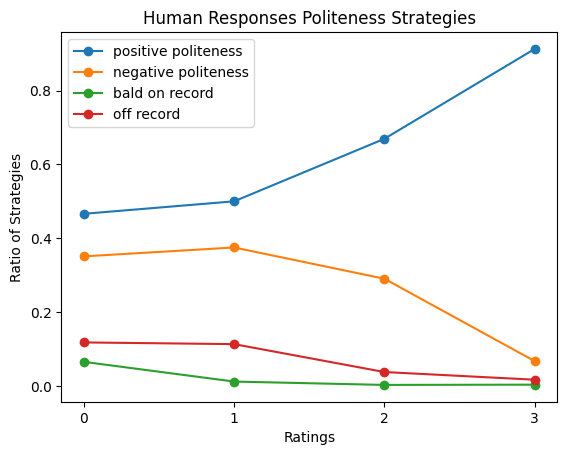

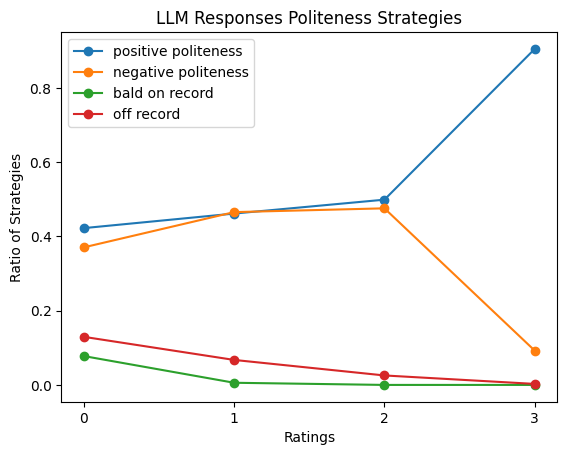

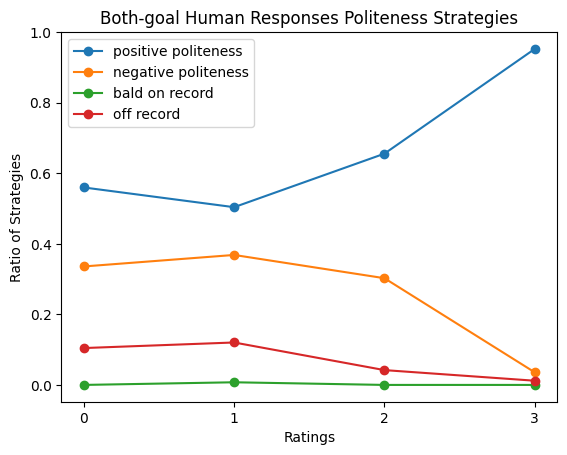

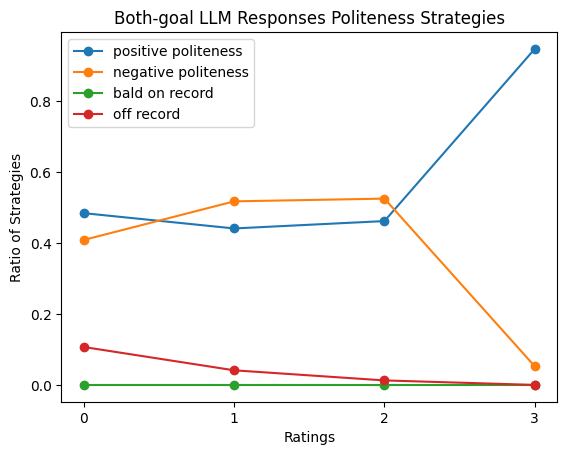

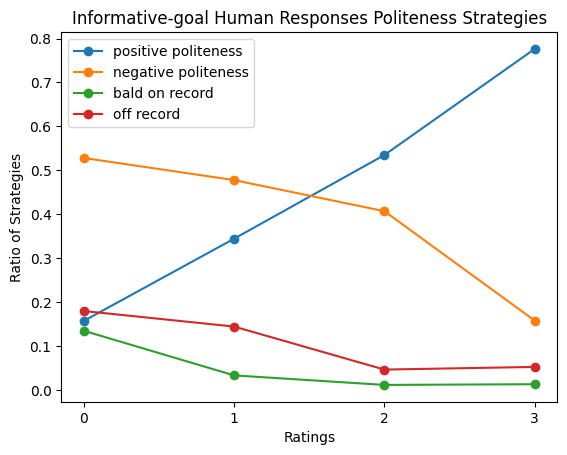

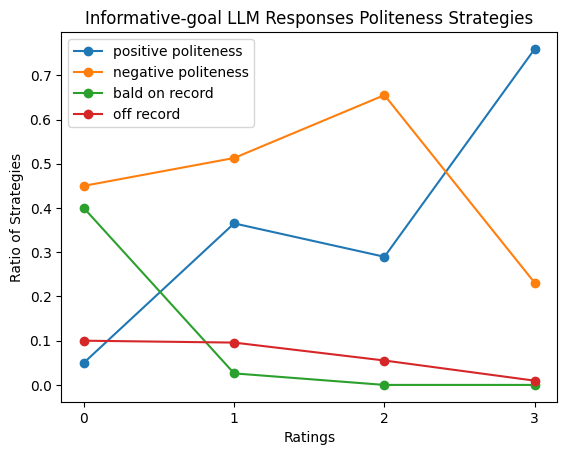

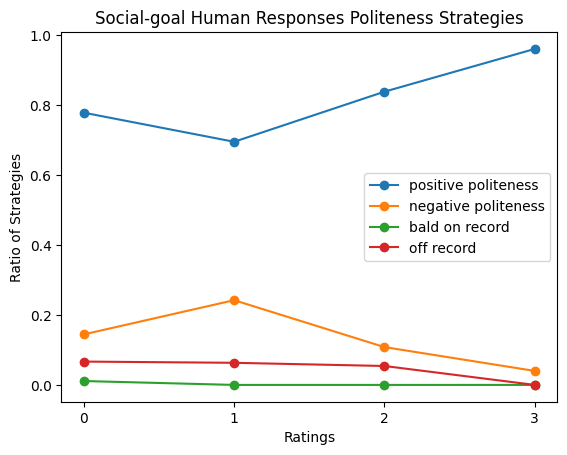

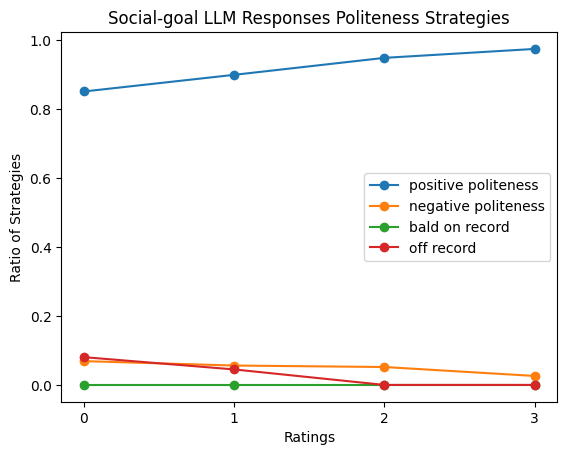

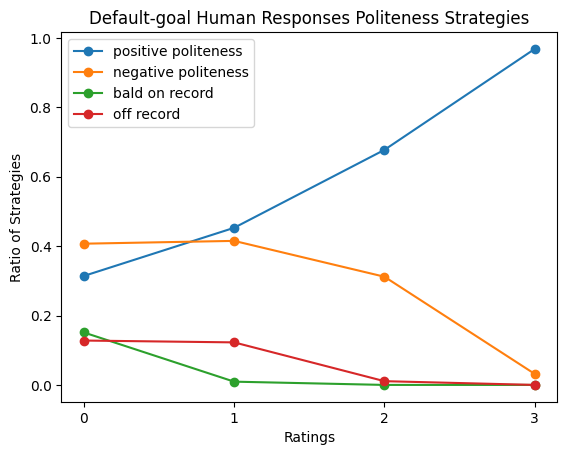

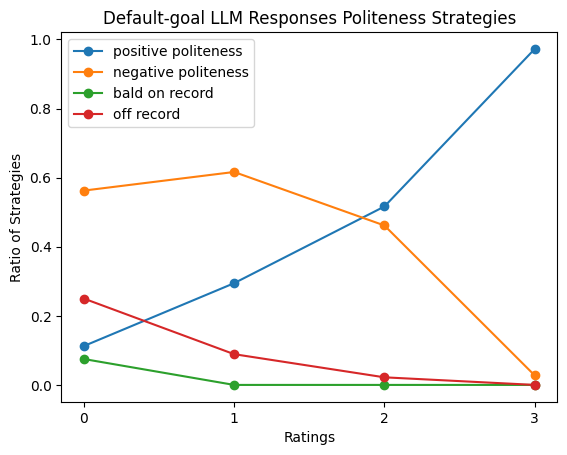

In [15]:
# with rating goes up, the frequency of positive politeness should go up, and the frequency of negative politeness should go down
# i need a line plot for this to show for human responses, what is the trend, for llm responses, what is the trend

# two line plots, one is for human responses, one is for llm responses
# in each plot, the x-axis is the ratings [0, 1, 2, 3], the y-axis is the ratio of each strategy, there are four lines, one for each strategy

# for human-response plot: strategy_frequency_rating_zero_human_responses_ratio, strategy_frequency_rating_one_human_responses_ratio, strategy_frequency_rating_two_human_responses_ratio, strategy_frequency_rating_three_human_responses_ratio
# example of what dict looks like: {'positive politeness': 0.9128, 'negative politeness': 0.0671, 'bald on record': 0.0034, 'off record': 0.0168}

import matplotlib.pyplot as plt
import numpy as np

# x-axis
x = ["0", "1", "2", "3"]
# y-axis
y_positive_human = [strategy_frequency_rating_zero_human_responses_ratio['positive politeness'], strategy_frequency_rating_one_human_responses_ratio['positive politeness'], strategy_frequency_rating_two_human_responses_ratio['positive politeness'], strategy_frequency_rating_three_human_responses_ratio['positive politeness']]
y_negative_human = [strategy_frequency_rating_zero_human_responses_ratio['negative politeness'], strategy_frequency_rating_one_human_responses_ratio['negative politeness'], strategy_frequency_rating_two_human_responses_ratio['negative politeness'], strategy_frequency_rating_three_human_responses_ratio['negative politeness']]
y_bald_human = [strategy_frequency_rating_zero_human_responses_ratio['bald on record'], strategy_frequency_rating_one_human_responses_ratio['bald on record'], strategy_frequency_rating_two_human_responses_ratio['bald on record'], strategy_frequency_rating_three_human_responses_ratio['bald on record']]
y_off_human = [strategy_frequency_rating_zero_human_responses_ratio['off record'], strategy_frequency_rating_one_human_responses_ratio['off record'], strategy_frequency_rating_two_human_responses_ratio['off record'], strategy_frequency_rating_three_human_responses_ratio['off record']]

# plot the human responses
plt.plot(x, y_positive_human, label='positive politeness', marker='o')
plt.plot(x, y_negative_human, label='negative politeness', marker='o')
plt.plot(x, y_bald_human, label='bald on record', marker='o')
plt.plot(x, y_off_human, label='off record', marker='o')

# add title and labels
plt.title('Human Responses Politeness Strategies')

plt.xlabel('Ratings')
plt.ylabel('Ratio of Strategies')

# add legend
plt.legend()

# show the plot
plt.show()

# for llm-response plot: strategy_frequency_rating_zero_llm_responses_ratio, strategy_frequency_rating_one_llm_responses_ratio, strategy_frequency_rating_two_llm_responses_ratio, strategy_frequency_rating_three_llm_responses_ratio
# example of what dict looks like: {'positive politeness': 0.9128, 'negative politeness': 0.0671, 'bald on record': 0.0034, 'off record': 0.0168}
# x-axis
x = ["0", "1", "2", "3"]
# y-axis
y_positive_llm = [strategy_frequency_rating_zero_llm_responses_ratio['positive politeness'], strategy_frequency_rating_one_llm_responses_ratio['positive politeness'], strategy_frequency_rating_two_llm_responses_ratio['positive politeness'], strategy_frequency_rating_three_llm_responses_ratio['positive politeness']]
y_negative_llm = [strategy_frequency_rating_zero_llm_responses_ratio['negative politeness'], strategy_frequency_rating_one_llm_responses_ratio['negative politeness'], strategy_frequency_rating_two_llm_responses_ratio['negative politeness'], strategy_frequency_rating_three_llm_responses_ratio['negative politeness']]
y_bald_llm = [strategy_frequency_rating_zero_llm_responses_ratio['bald on record'], strategy_frequency_rating_one_llm_responses_ratio['bald on record'], strategy_frequency_rating_two_llm_responses_ratio['bald on record'], strategy_frequency_rating_three_llm_responses_ratio['bald on record']]
y_off_llm = [strategy_frequency_rating_zero_llm_responses_ratio['off record'], strategy_frequency_rating_one_llm_responses_ratio['off record'], strategy_frequency_rating_two_llm_responses_ratio['off record'], strategy_frequency_rating_three_llm_responses_ratio['off record']]

# plot the llm responses
plt.plot(x, y_positive_llm, label='positive politeness', marker='o')
plt.plot(x, y_negative_llm, label='negative politeness', marker='o')
plt.plot(x, y_bald_llm, label='bald on record', marker='o')
plt.plot(x, y_off_llm, label='off record', marker='o')
# add title and labels
plt.title('LLM Responses Politeness Strategies')
plt.xlabel('Ratings')
plt.ylabel('Ratio of Strategies')

# add legend
plt.legend()

# show the plot
plt.show()

# for rating_zero_both_human_responses_golden_politeness_strategies, rating_one_both_human_responses_golden_politeness_strategies, rating_two_both_human_responses_golden_politeness_strategies, rating_three_both_human_responses_golden_politeness_strategies
# example of what dict looks like: {'positive politeness': 0.9128, 'negative politeness': 0.0671, 'bald on record': 0.0034, 'off record': 0.0168}
# x-axis
x = ["0", "1", "2", "3"]
# y-axis
y_positive_both_human = [strategy_frequency_rating_zero_both_human_responses_ratio['positive politeness'], strategy_frequency_rating_one_both_human_responses_ratio['positive politeness'], strategy_frequency_rating_two_both_human_responses_ratio['positive politeness'], strategy_frequency_rating_three_both_human_responses_ratio['positive politeness']]
y_negative_both_human = [strategy_frequency_rating_zero_both_human_responses_ratio['negative politeness'], strategy_frequency_rating_one_both_human_responses_ratio['negative politeness'], strategy_frequency_rating_two_both_human_responses_ratio['negative politeness'], strategy_frequency_rating_three_both_human_responses_ratio['negative politeness']]
y_bald_both_human = [strategy_frequency_rating_zero_both_human_responses_ratio['bald on record'], strategy_frequency_rating_one_both_human_responses_ratio['bald on record'], strategy_frequency_rating_two_both_human_responses_ratio['bald on record'], strategy_frequency_rating_three_both_human_responses_ratio['bald on record']]
y_off_both_human = [strategy_frequency_rating_zero_both_human_responses_ratio['off record'], strategy_frequency_rating_one_both_human_responses_ratio['off record'], strategy_frequency_rating_two_both_human_responses_ratio['off record'], strategy_frequency_rating_three_both_human_responses_ratio['off record']]

# plot the both human responses
plt.plot(x, y_positive_both_human, label='positive politeness', marker='o')
plt.plot(x, y_negative_both_human, label='negative politeness', marker='o')
plt.plot(x, y_bald_both_human, label='bald on record', marker='o')
plt.plot(x, y_off_both_human, label='off record', marker='o')

# add title and labels
plt.title('Both-goal Human Responses Politeness Strategies')
plt.xlabel('Ratings')
plt.ylabel('Ratio of Strategies')

# add legend
plt.legend()
# show the plot
plt.show()

# for rating_zero_both_llm_responses_golden_politeness_strategies, rating_one_both_llm_responses_golden_politeness_strategies, rating_two_both_llm_responses_golden_politeness_strategies, rating_three_both_llm_responses_golden_politeness_strategies
# example of what dict looks like: {'positive politeness': 0.9128, 'negative politeness': 0.0671, 'bald on record': 0.0034, 'off record': 0.0168}
# x-axis
x = ["0", "1", "2", "3"]
# y-axis
y_positive_both_llm = [strategy_frequency_rating_zero_both_llm_responses_ratio['positive politeness'], strategy_frequency_rating_one_both_llm_responses_ratio['positive politeness'], strategy_frequency_rating_two_both_llm_responses_ratio['positive politeness'], strategy_frequency_rating_three_both_llm_responses_ratio['positive politeness']]
y_negative_both_llm = [strategy_frequency_rating_zero_both_llm_responses_ratio['negative politeness'], strategy_frequency_rating_one_both_llm_responses_ratio['negative politeness'], strategy_frequency_rating_two_both_llm_responses_ratio['negative politeness'], strategy_frequency_rating_three_both_llm_responses_ratio['negative politeness']]
y_bald_both_llm = [strategy_frequency_rating_zero_both_llm_responses_ratio['bald on record'], strategy_frequency_rating_one_both_llm_responses_ratio['bald on record'], strategy_frequency_rating_two_both_llm_responses_ratio['bald on record'], strategy_frequency_rating_three_both_llm_responses_ratio['bald on record']]
y_off_both_llm = [strategy_frequency_rating_zero_both_llm_responses_ratio['off record'], strategy_frequency_rating_one_both_llm_responses_ratio['off record'], strategy_frequency_rating_two_both_llm_responses_ratio['off record'], strategy_frequency_rating_three_both_llm_responses_ratio['off record']]

# plot the both llm responses
plt.plot(x, y_positive_both_llm, label='positive politeness', marker='o')
plt.plot(x, y_negative_both_llm, label='negative politeness', marker='o')
plt.plot(x, y_bald_both_llm, label='bald on record', marker='o')
plt.plot(x, y_off_both_llm, label='off record', marker='o')

# add title and labels
plt.title('Both-goal LLM Responses Politeness Strategies')
plt.xlabel('Ratings')
plt.ylabel('Ratio of Strategies')

# add legend
plt.legend()

# show the plot
plt.show()

# for rating_zero_informative_human_responses_golden_politeness_strategies, rating_one_informative_human_responses_golden_politeness_strategies, rating_two_informative_human_responses_golden_politeness_strategies, rating_three_informative_human_responses_golden_politeness_strategies
# example of what dict looks like: {'positive politeness': 0.9128, 'negative politeness': 0.0671, 'bald on record': 0.0034, 'off record': 0.0168}
# x-axis
x = ["0", "1", "2", "3"]
# y-axis
y_positive_informative_human = [strategy_frequency_rating_zero_informative_human_responses_ratio['positive politeness'], strategy_frequency_rating_one_informative_human_responses_ratio['positive politeness'], strategy_frequency_rating_two_informative_human_responses_ratio['positive politeness'], strategy_frequency_rating_three_informative_human_responses_ratio['positive politeness']]
y_negative_informative_human = [strategy_frequency_rating_zero_informative_human_responses_ratio['negative politeness'], strategy_frequency_rating_one_informative_human_responses_ratio['negative politeness'], strategy_frequency_rating_two_informative_human_responses_ratio['negative politeness'], strategy_frequency_rating_three_informative_human_responses_ratio['negative politeness']]
y_bald_informative_human = [strategy_frequency_rating_zero_informative_human_responses_ratio['bald on record'], strategy_frequency_rating_one_informative_human_responses_ratio['bald on record'], strategy_frequency_rating_two_informative_human_responses_ratio['bald on record'], strategy_frequency_rating_three_informative_human_responses_ratio['bald on record']]
y_off_informative_human = [strategy_frequency_rating_zero_informative_human_responses_ratio['off record'], strategy_frequency_rating_one_informative_human_responses_ratio['off record'], strategy_frequency_rating_two_informative_human_responses_ratio['off record'], strategy_frequency_rating_three_informative_human_responses_ratio['off record']]

# plot the informative human responses
plt.plot(x, y_positive_informative_human, label='positive politeness', marker='o')
plt.plot(x, y_negative_informative_human, label='negative politeness', marker='o')
plt.plot(x, y_bald_informative_human, label='bald on record', marker='o')
plt.plot(x, y_off_informative_human, label='off record', marker='o')

# add title and labels
plt.title('Informative-goal Human Responses Politeness Strategies')
plt.xlabel('Ratings')
plt.ylabel('Ratio of Strategies')

# add legend
plt.legend()
# show the plot
plt.show()

# for rating_zero_informative_llm_responses_golden_politeness_strategies, rating_one_informative_llm_responses_golden_politeness_strategies, rating_two_informative_llm_responses_golden_politeness_strategies, rating_three_informative_llm_responses_golden_politeness_strategies
# example of what dict looks like: {'positive politeness': 0.9128, 'negative politeness': 0.0671, 'bald on record': 0.0034, 'off record': 0.0168}
# x-axis
x = ["0", "1", "2", "3"]
# y-axis
y_positive_informative_llm = [strategy_frequency_rating_zero_informative_llm_responses_ratio['positive politeness'], strategy_frequency_rating_one_informative_llm_responses_ratio['positive politeness'], strategy_frequency_rating_two_informative_llm_responses_ratio['positive politeness'], strategy_frequency_rating_three_informative_llm_responses_ratio['positive politeness']]
y_negative_informative_llm = [strategy_frequency_rating_zero_informative_llm_responses_ratio['negative politeness'], strategy_frequency_rating_one_informative_llm_responses_ratio['negative politeness'], strategy_frequency_rating_two_informative_llm_responses_ratio['negative politeness'], strategy_frequency_rating_three_informative_llm_responses_ratio['negative politeness']]
y_bald_informative_llm = [strategy_frequency_rating_zero_informative_llm_responses_ratio['bald on record'], strategy_frequency_rating_one_informative_llm_responses_ratio['bald on record'], strategy_frequency_rating_two_informative_llm_responses_ratio['bald on record'], strategy_frequency_rating_three_informative_llm_responses_ratio['bald on record']]
y_off_informative_llm = [strategy_frequency_rating_zero_informative_llm_responses_ratio['off record'], strategy_frequency_rating_one_informative_llm_responses_ratio['off record'], strategy_frequency_rating_two_informative_llm_responses_ratio['off record'], strategy_frequency_rating_three_informative_llm_responses_ratio['off record']]

# plot the informative llm responses
plt.plot(x, y_positive_informative_llm, label='positive politeness', marker='o')
plt.plot(x, y_negative_informative_llm, label='negative politeness', marker='o')
plt.plot(x, y_bald_informative_llm, label='bald on record', marker='o')
plt.plot(x, y_off_informative_llm, label='off record', marker='o')

# add title and labels
plt.title('Informative-goal LLM Responses Politeness Strategies')
plt.xlabel('Ratings')
plt.ylabel('Ratio of Strategies')

# add legend
plt.legend()
# show the plot
plt.show()

# for rating_zero_social_human_responses_golden_politeness_strategies, rating_one_social_human_responses_golden_politeness_strategies, rating_two_social_human_responses_golden_politeness_strategies, rating_three_social_human_responses_golden_politeness_strategies
# example of what dict looks like: {'positive politeness': 0.9128, 'negative politeness': 0.0671, 'bald on record': 0.0034, 'off record': 0.0168}
# x-axis
x = ["0", "1", "2", "3"]
# y-axis
y_positive_social_human = [strategy_frequency_rating_zero_social_human_responses_ratio['positive politeness'], strategy_frequency_rating_one_social_human_responses_ratio['positive politeness'], strategy_frequency_rating_two_social_human_responses_ratio['positive politeness'], strategy_frequency_rating_three_social_human_responses_ratio['positive politeness']]
y_negative_social_human = [strategy_frequency_rating_zero_social_human_responses_ratio['negative politeness'], strategy_frequency_rating_one_social_human_responses_ratio['negative politeness'], strategy_frequency_rating_two_social_human_responses_ratio['negative politeness'], strategy_frequency_rating_three_social_human_responses_ratio['negative politeness']]
y_bald_social_human = [strategy_frequency_rating_zero_social_human_responses_ratio['bald on record'], strategy_frequency_rating_one_social_human_responses_ratio['bald on record'], strategy_frequency_rating_two_social_human_responses_ratio['bald on record'], strategy_frequency_rating_three_social_human_responses_ratio['bald on record']]
y_off_social_human = [strategy_frequency_rating_zero_social_human_responses_ratio['off record'], strategy_frequency_rating_one_social_human_responses_ratio['off record'], strategy_frequency_rating_two_social_human_responses_ratio['off record'], strategy_frequency_rating_three_social_human_responses_ratio['off record']]

# plot the social human responses
plt.plot(x, y_positive_social_human, label='positive politeness', marker='o')
plt.plot(x, y_negative_social_human, label='negative politeness', marker='o')
plt.plot(x, y_bald_social_human, label='bald on record', marker='o')
plt.plot(x, y_off_social_human, label='off record', marker='o')

# add title and labels
plt.title('Social-goal Human Responses Politeness Strategies')
plt.xlabel('Ratings')
plt.ylabel('Ratio of Strategies')

# add legend
plt.legend()
# show the plot
plt.show()

# for rating_zero_social_llm_responses_golden_politeness_strategies, rating_one_social_llm_responses_golden_politeness_strategies, rating_two_social_llm_responses_golden_politeness_strategies, rating_three_social_llm_responses_golden_politeness_strategies
# example of what dict looks like: {'positive politeness': 0.9128, 'negative politeness': 0.0671, 'bald on record': 0.0034, 'off record': 0.0168}
# x-axis
x = ["0", "1", "2", "3"]
# y-axis
y_positive_social_llm = [strategy_frequency_rating_zero_social_llm_responses_ratio['positive politeness'], strategy_frequency_rating_one_social_llm_responses_ratio['positive politeness'], strategy_frequency_rating_two_social_llm_responses_ratio['positive politeness'], strategy_frequency_rating_three_social_llm_responses_ratio['positive politeness']]
y_negative_social_llm = [strategy_frequency_rating_zero_social_llm_responses_ratio['negative politeness'], strategy_frequency_rating_one_social_llm_responses_ratio['negative politeness'], strategy_frequency_rating_two_social_llm_responses_ratio['negative politeness'], strategy_frequency_rating_three_social_llm_responses_ratio['negative politeness']]
y_bald_social_llm = [strategy_frequency_rating_zero_social_llm_responses_ratio['bald on record'], strategy_frequency_rating_one_social_llm_responses_ratio['bald on record'], strategy_frequency_rating_two_social_llm_responses_ratio['bald on record'], strategy_frequency_rating_three_social_llm_responses_ratio['bald on record']]
y_off_social_llm = [strategy_frequency_rating_zero_social_llm_responses_ratio['off record'], strategy_frequency_rating_one_social_llm_responses_ratio['off record'], strategy_frequency_rating_two_social_llm_responses_ratio['off record'], strategy_frequency_rating_three_social_llm_responses_ratio['off record']]

# plot the social llm responses
plt.plot(x, y_positive_social_llm, label='positive politeness', marker='o')
plt.plot(x, y_negative_social_llm, label='negative politeness', marker='o')
plt.plot(x, y_bald_social_llm, label='bald on record', marker='o')
plt.plot(x, y_off_social_llm, label='off record', marker='o')

# add title and labels
plt.title('Social-goal LLM Responses Politeness Strategies')
plt.xlabel('Ratings')
plt.ylabel('Ratio of Strategies')

# add legend
plt.legend()
# show the plot
plt.show()

# for rating_zero_default_human_responses_golden_politeness_strategies, rating_one_default_human_responses_golden_politeness_strategies, rating_two_default_human_responses_golden_politeness_strategies, rating_three_default_human_responses_golden_politeness_strategies
# example of what dict looks like: {'positive politeness': 0.9128, 'negative politeness': 0.0671, 'bald on record': 0.0034, 'off record': 0.0168}
# x-axis
x = ["0", "1", "2", "3"]
# y-axis
y_positive_default_human = [strategy_frequency_rating_zero_default_human_responses_ratio['positive politeness'], strategy_frequency_rating_one_default_human_responses_ratio['positive politeness'], strategy_frequency_rating_two_default_human_responses_ratio['positive politeness'], strategy_frequency_rating_three_default_human_responses_ratio['positive politeness']]
y_negative_default_human = [strategy_frequency_rating_zero_default_human_responses_ratio['negative politeness'], strategy_frequency_rating_one_default_human_responses_ratio['negative politeness'], strategy_frequency_rating_two_default_human_responses_ratio['negative politeness'], strategy_frequency_rating_three_default_human_responses_ratio['negative politeness']]
y_bald_default_human = [strategy_frequency_rating_zero_default_human_responses_ratio['bald on record'], strategy_frequency_rating_one_default_human_responses_ratio['bald on record'], strategy_frequency_rating_two_default_human_responses_ratio['bald on record'], strategy_frequency_rating_three_default_human_responses_ratio['bald on record']]
y_off_default_human = [strategy_frequency_rating_zero_default_human_responses_ratio['off record'], strategy_frequency_rating_one_default_human_responses_ratio['off record'], strategy_frequency_rating_two_default_human_responses_ratio['off record'], strategy_frequency_rating_three_default_human_responses_ratio['off record']]

# plot the default human responses
plt.plot(x, y_positive_default_human, label='positive politeness', marker='o')
plt.plot(x, y_negative_default_human, label='negative politeness', marker='o')
plt.plot(x, y_bald_default_human, label='bald on record', marker='o')
plt.plot(x, y_off_default_human, label='off record', marker='o')

# add title and labels
plt.title('Default-goal Human Responses Politeness Strategies')
plt.xlabel('Ratings')
plt.ylabel('Ratio of Strategies')

# add legend
plt.legend()
# show the plot
plt.show()

# for rating_zero_default_llm_responses_golden_politeness_strategies, rating_one_default_llm_responses_golden_politeness_strategies, rating_two_default_llm_responses_golden_politeness_strategies, rating_three_default_llm_responses_golden_politeness_strategies
# example of what dict looks like: {'positive politeness': 0.9128, 'negative politeness': 0.0671, 'bald on record': 0.0034, 'off record': 0.0168}
# x-axis
x = ["0", "1", "2", "3"]
# y-axis
y_positive_default_llm = [strategy_frequency_rating_zero_default_llm_responses_ratio['positive politeness'], strategy_frequency_rating_one_default_llm_responses_ratio['positive politeness'], strategy_frequency_rating_two_default_llm_responses_ratio['positive politeness'], strategy_frequency_rating_three_default_llm_responses_ratio['positive politeness']]
y_negative_default_llm = [strategy_frequency_rating_zero_default_llm_responses_ratio['negative politeness'], strategy_frequency_rating_one_default_llm_responses_ratio['negative politeness'], strategy_frequency_rating_two_default_llm_responses_ratio['negative politeness'], strategy_frequency_rating_three_default_llm_responses_ratio['negative politeness']]
y_bald_default_llm = [strategy_frequency_rating_zero_default_llm_responses_ratio['bald on record'], strategy_frequency_rating_one_default_llm_responses_ratio['bald on record'], strategy_frequency_rating_two_default_llm_responses_ratio['bald on record'], strategy_frequency_rating_three_default_llm_responses_ratio['bald on record']]
y_off_default_llm = [strategy_frequency_rating_zero_default_llm_responses_ratio['off record'], strategy_frequency_rating_one_default_llm_responses_ratio['off record'], strategy_frequency_rating_two_default_llm_responses_ratio['off record'], strategy_frequency_rating_three_default_llm_responses_ratio['off record']]
# plot the default llm responses
plt.plot(x, y_positive_default_llm, label='positive politeness', marker='o')
plt.plot(x, y_negative_default_llm, label='negative politeness', marker='o')
plt.plot(x, y_bald_default_llm, label='bald on record', marker='o')
plt.plot(x, y_off_default_llm, label='off record', marker='o')

# add title and labels
plt.title('Default-goal LLM Responses Politeness Strategies')
plt.xlabel('Ratings')
plt.ylabel('Ratio of Strategies')

# add legend
plt.legend()
# show the plot
plt.show()

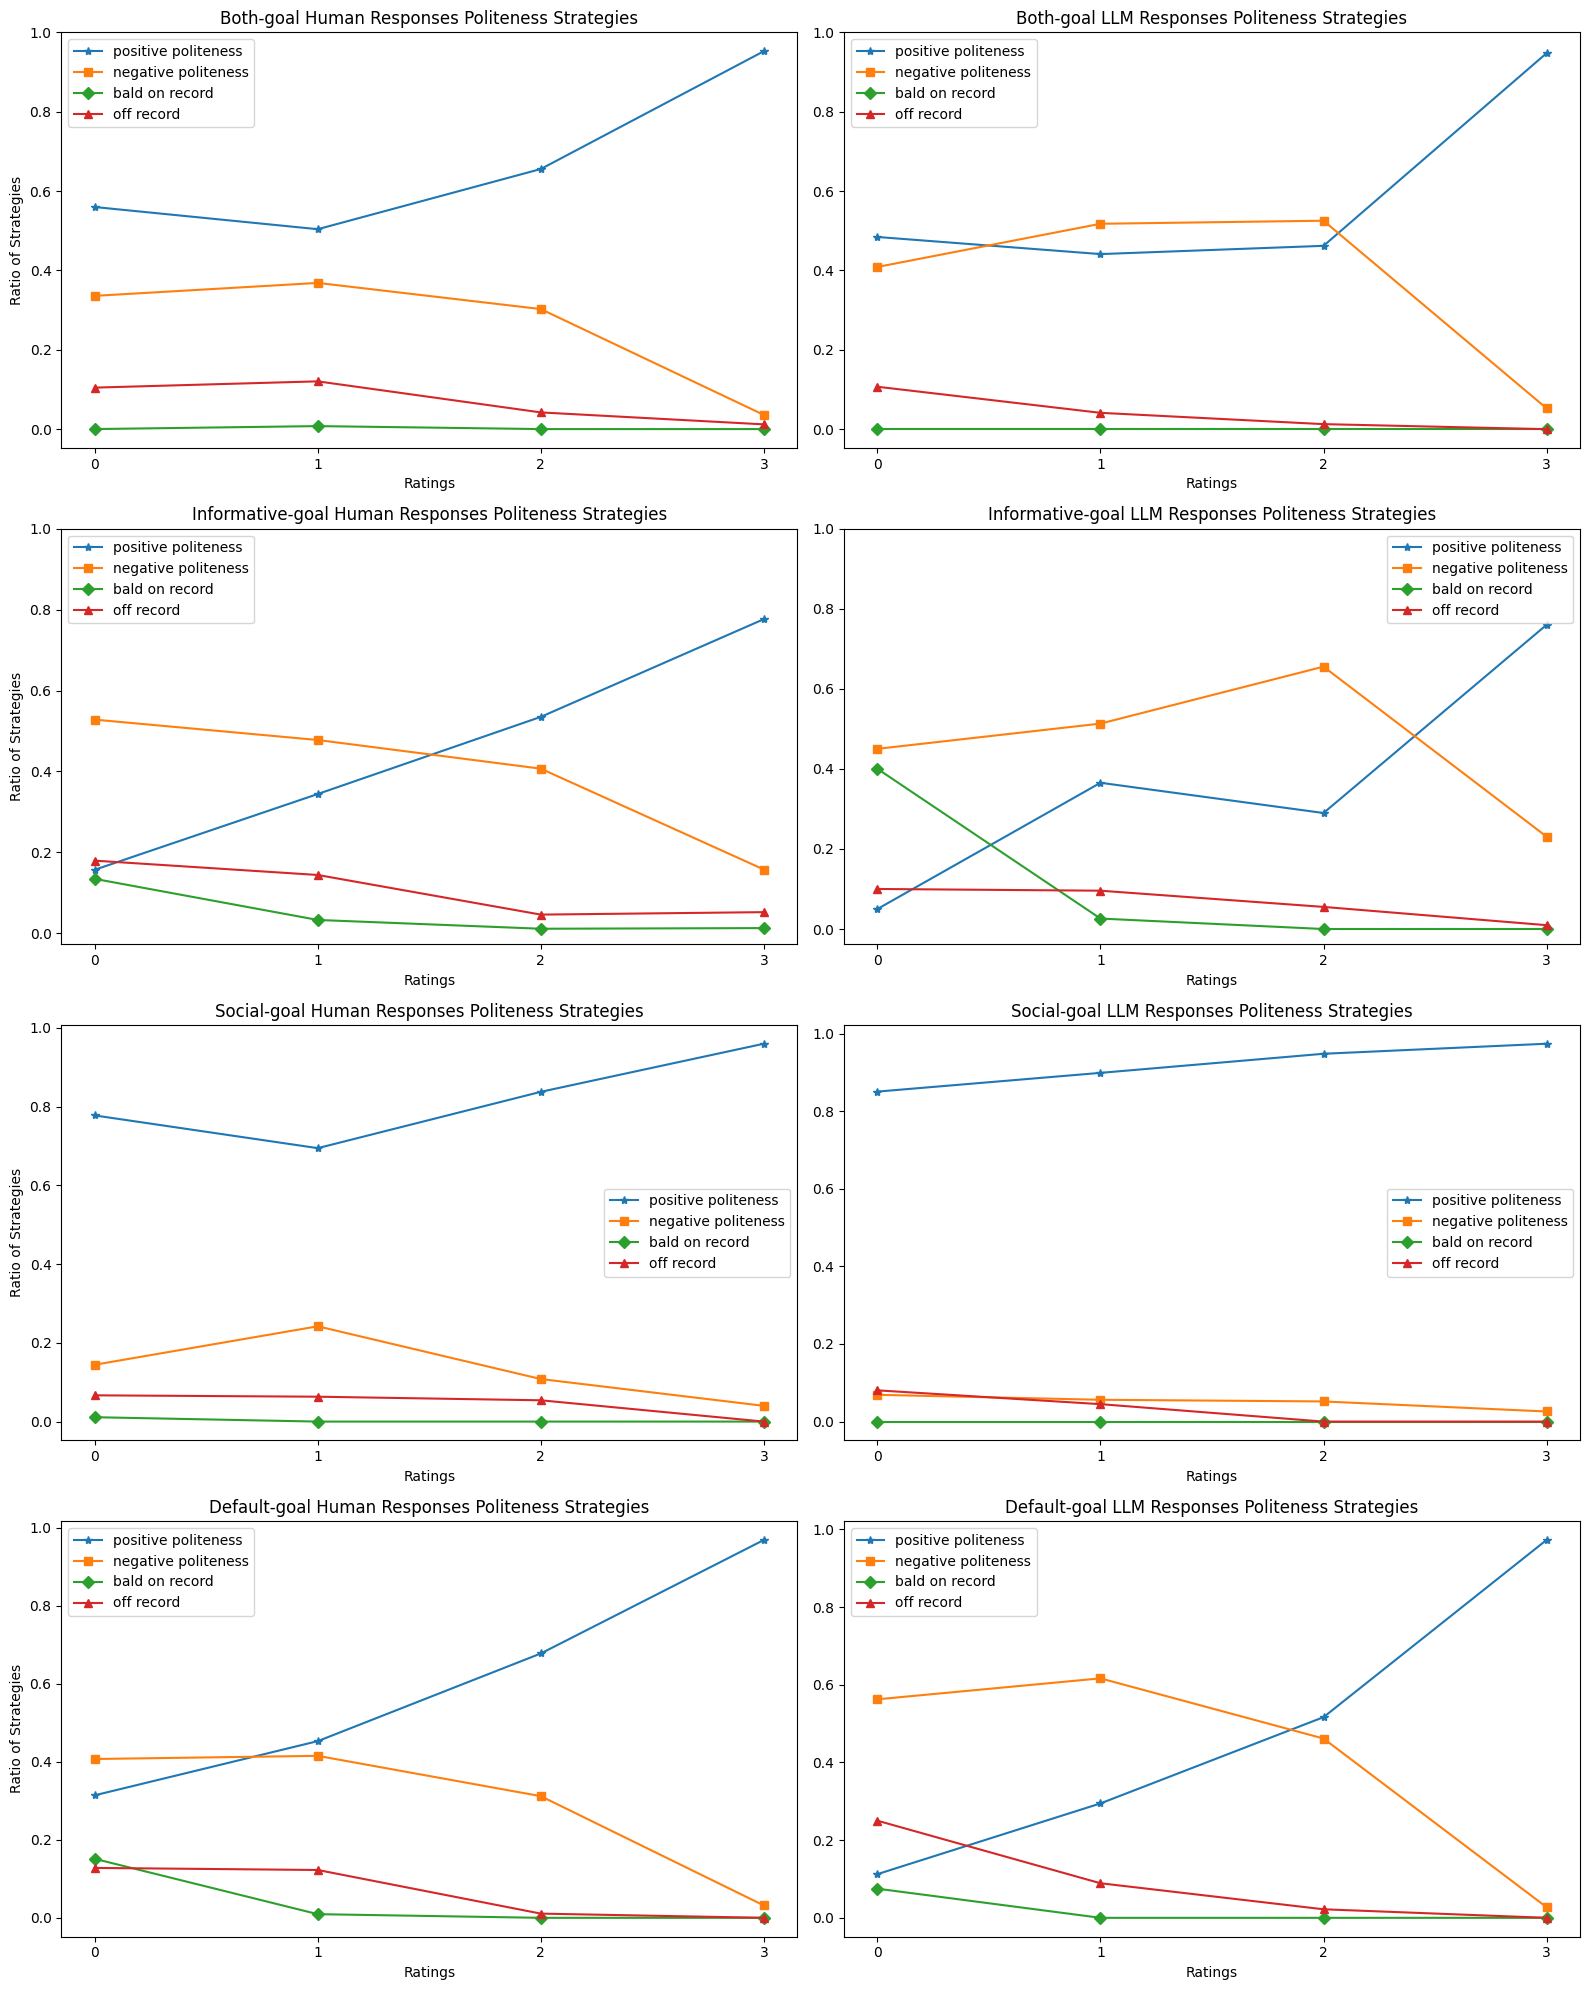

In [16]:
import matplotlib.pyplot as plt

x = ["0", "1", "2", "3"]

# Define markers for the four strategies
strategy_markers = {
    'positive politeness': '*',   # circle
    'negative politeness': 's',   # square
    'bald on record': 'D',        # diamond
    'off record': '^'             # triangle up
}

# Create figure and axes
fig, axs = plt.subplots(4, 2, figsize=(16, 20))
axs = axs.flatten()

# Data groups for each subplot
data_sets = [
    ("Both-goal Human Responses Politeness Strategies", y_positive_both_human, y_negative_both_human, y_bald_both_human, y_off_both_human),
    ("Both-goal LLM Responses Politeness Strategies", y_positive_both_llm, y_negative_both_llm, y_bald_both_llm, y_off_both_llm),
    ("Informative-goal Human Responses Politeness Strategies", y_positive_informative_human, y_negative_informative_human, y_bald_informative_human, y_off_informative_human),
    ("Informative-goal LLM Responses Politeness Strategies", y_positive_informative_llm, y_negative_informative_llm, y_bald_informative_llm, y_off_informative_llm),
    ("Social-goal Human Responses Politeness Strategies", y_positive_social_human, y_negative_social_human, y_bald_social_human, y_off_social_human),
    ("Social-goal LLM Responses Politeness Strategies", y_positive_social_llm, y_negative_social_llm, y_bald_social_llm, y_off_social_llm),
    ("Default-goal Human Responses Politeness Strategies", y_positive_default_human, y_negative_default_human, y_bald_default_human, y_off_default_human),
    ("Default-goal LLM Responses Politeness Strategies", y_positive_default_llm, y_negative_default_llm, y_bald_default_llm, y_off_default_llm),
]

# Plotting each subplot
for i, (title, y_pos, y_neg, y_bald, y_off) in enumerate(data_sets):
    axs[i].plot(x, y_pos, label='positive politeness', marker=strategy_markers['positive politeness'])
    axs[i].plot(x, y_neg, label='negative politeness', marker=strategy_markers['negative politeness'])
    axs[i].plot(x, y_bald, label='bald on record', marker=strategy_markers['bald on record'])
    axs[i].plot(x, y_off, label='off record', marker=strategy_markers['off record'])
    
    axs[i].set_title(title)
    axs[i].set_xlabel("Ratings")
    if i % 2 == 0:
        axs[i].set_ylabel("Ratio of Strategies")

    axs[i].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axs[i].legend()

plt.tight_layout()
plt.show()

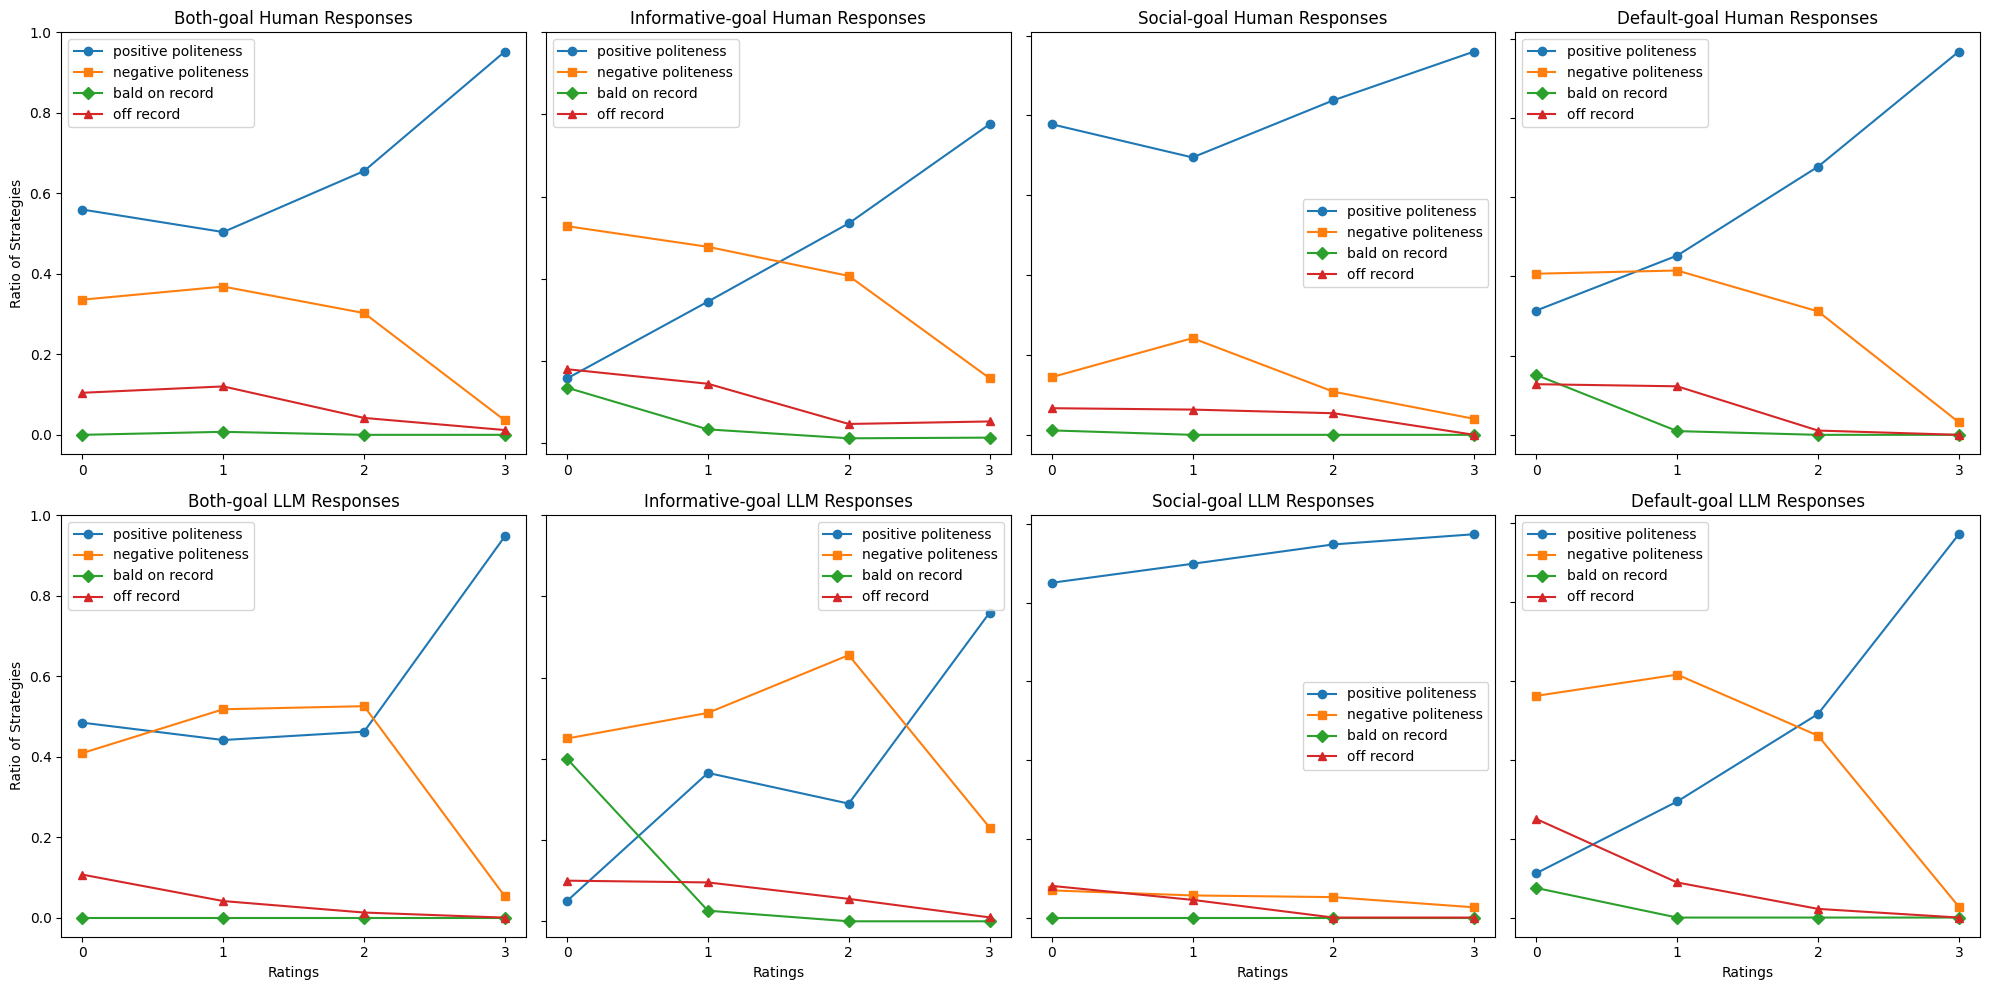

In [17]:
import matplotlib.pyplot as plt

x = ["0", "1", "2", "3"]

# Define markers for the four strategies
strategy_markers = {
    'positive politeness': 'o',   # circle
    'negative politeness': 's',   # square
    'bald on record': 'D',        # diamond
    'off record': '^'             # triangle up
}

# Create figure and axes: 2 rows, 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

# Data groups ordered by: [Human...], [LLM...]
data_sets = [
    ("Both-goal Human Responses", y_positive_both_human, y_negative_both_human, y_bald_both_human, y_off_both_human),
    ("Informative-goal Human Responses", y_positive_informative_human, y_negative_informative_human, y_bald_informative_human, y_off_informative_human),
    ("Social-goal Human Responses", y_positive_social_human, y_negative_social_human, y_bald_social_human, y_off_social_human),
    ("Default-goal Human Responses", y_positive_default_human, y_negative_default_human, y_bald_default_human, y_off_default_human),
    ("Both-goal LLM Responses", y_positive_both_llm, y_negative_both_llm, y_bald_both_llm, y_off_both_llm),
    ("Informative-goal LLM Responses", y_positive_informative_llm, y_negative_informative_llm, y_bald_informative_llm, y_off_informative_llm),
    ("Social-goal LLM Responses", y_positive_social_llm, y_negative_social_llm, y_bald_social_llm, y_off_social_llm),
    ("Default-goal LLM Responses", y_positive_default_llm, y_negative_default_llm, y_bald_default_llm, y_off_default_llm),
]

# Plotting each subplot
for i, (title, y_pos, y_neg, y_bald, y_off) in enumerate(data_sets):
    axs[i].plot(x, y_pos, label='positive politeness', marker=strategy_markers['positive politeness'])
    axs[i].plot(x, y_neg, label='negative politeness', marker=strategy_markers['negative politeness'])
    axs[i].plot(x, y_bald, label='bald on record', marker=strategy_markers['bald on record'])
    axs[i].plot(x, y_off, label='off record', marker=strategy_markers['off record'])

    axs[i].set_title(title)

    # X-axis label only on second row (indices 4–7)
    if i >= 4:
        axs[i].set_xlabel("Ratings")

    # Y-axis label only on first column (indices 0 and 4)
    if i % 4 == 0:
        axs[i].set_ylabel("Ratio of Strategies")
        # Only set y-ticks with labels for the leftmost column
        axs[i].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    else:
        # For all other columns, hide the y-tick labels
        axs[i].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        axs[i].set_yticklabels([])

    axs[i].legend()

plt.tight_layout()
plt.show()

# save the plot as pdf
fig.savefig('../plots/ratio of politeness_strategies change across ratings and goals.pdf', bbox_inches='tight')

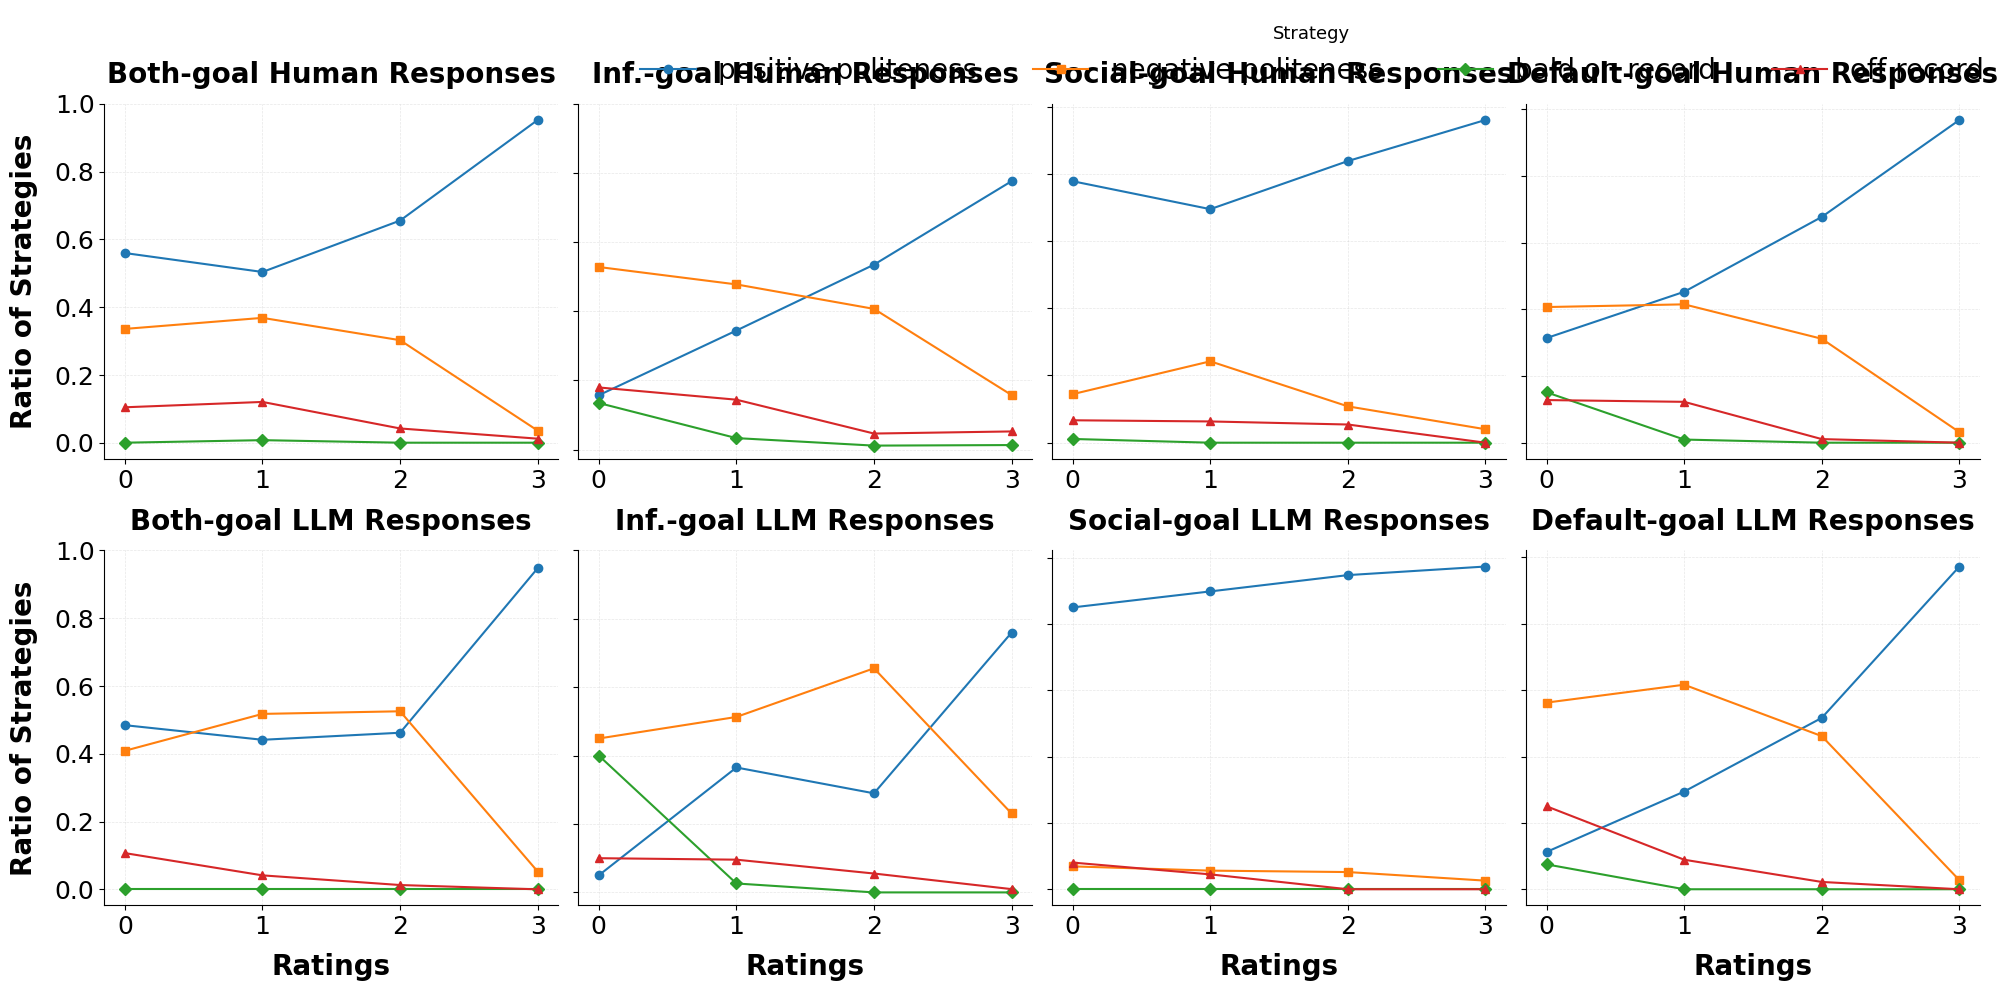

In [20]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

x = ["0", "1", "2", "3"]

# Define strategy names and markers
strategies = [
    ('positive politeness', 'o'),
    ('negative politeness', 's'),
    ('bald on record', 'D'),
    ('off record', '^')
]

# Create figure and axes: 2 rows, 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

# Create bold font
bold_font = font_manager.FontProperties(weight='bold')

# Titles and dataset
data_sets = [
    ("Both-goal Human Responses", y_positive_both_human, y_negative_both_human, y_bald_both_human, y_off_both_human),
    ("Inf.-goal Human Responses", y_positive_informative_human, y_negative_informative_human, y_bald_informative_human, y_off_informative_human),
    ("Social-goal Human Responses", y_positive_social_human, y_negative_social_human, y_bald_social_human, y_off_social_human),
    ("Default-goal Human Responses", y_positive_default_human, y_negative_default_human, y_bald_default_human, y_off_default_human),
    ("Both-goal LLM Responses", y_positive_both_llm, y_negative_both_llm, y_bald_both_llm, y_off_both_llm),
    ("Inf.-goal LLM Responses", y_positive_informative_llm, y_negative_informative_llm, y_bald_informative_llm, y_off_informative_llm),
    ("Social-goal LLM Responses", y_positive_social_llm, y_negative_social_llm, y_bald_social_llm, y_off_social_llm),
    ("Default-goal LLM Responses", y_positive_default_llm, y_negative_default_llm, y_bald_default_llm, y_off_default_llm),
]

# Plotting each subplot
for i, (title, y_pos, y_neg, y_bald, y_off) in enumerate(data_sets):
    ax = axs[i]
    
    for (strategy, marker), y_data in zip(strategies, [y_pos, y_neg, y_bald, y_off]):
        ax.plot(x, y_data, label=strategy, marker=marker, markersize=6)
    
    ax.set_title(title, fontsize=20, fontweight='bold', pad=15)

    if i >= 4:
        ax.set_xlabel("Ratings", fontsize=20, fontweight='bold', labelpad=10)

    if i % 4 == 0:
        ax.set_ylabel("Ratio of Strategies", fontsize=20, fontweight='bold', labelpad=12)
    else:
        ax.set_yticklabels([])

    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis='both', labelsize=18)

    # Add light grid
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add a single shared legend (outside of grid)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=4, fontsize=20, title='Strategy', title_fontsize=13, frameon=False)



plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Save as PDF
fig.savefig('../plots/ratio of politeness_strategies change across ratings and goals.pdf', format='pdf', bbox_inches='tight')

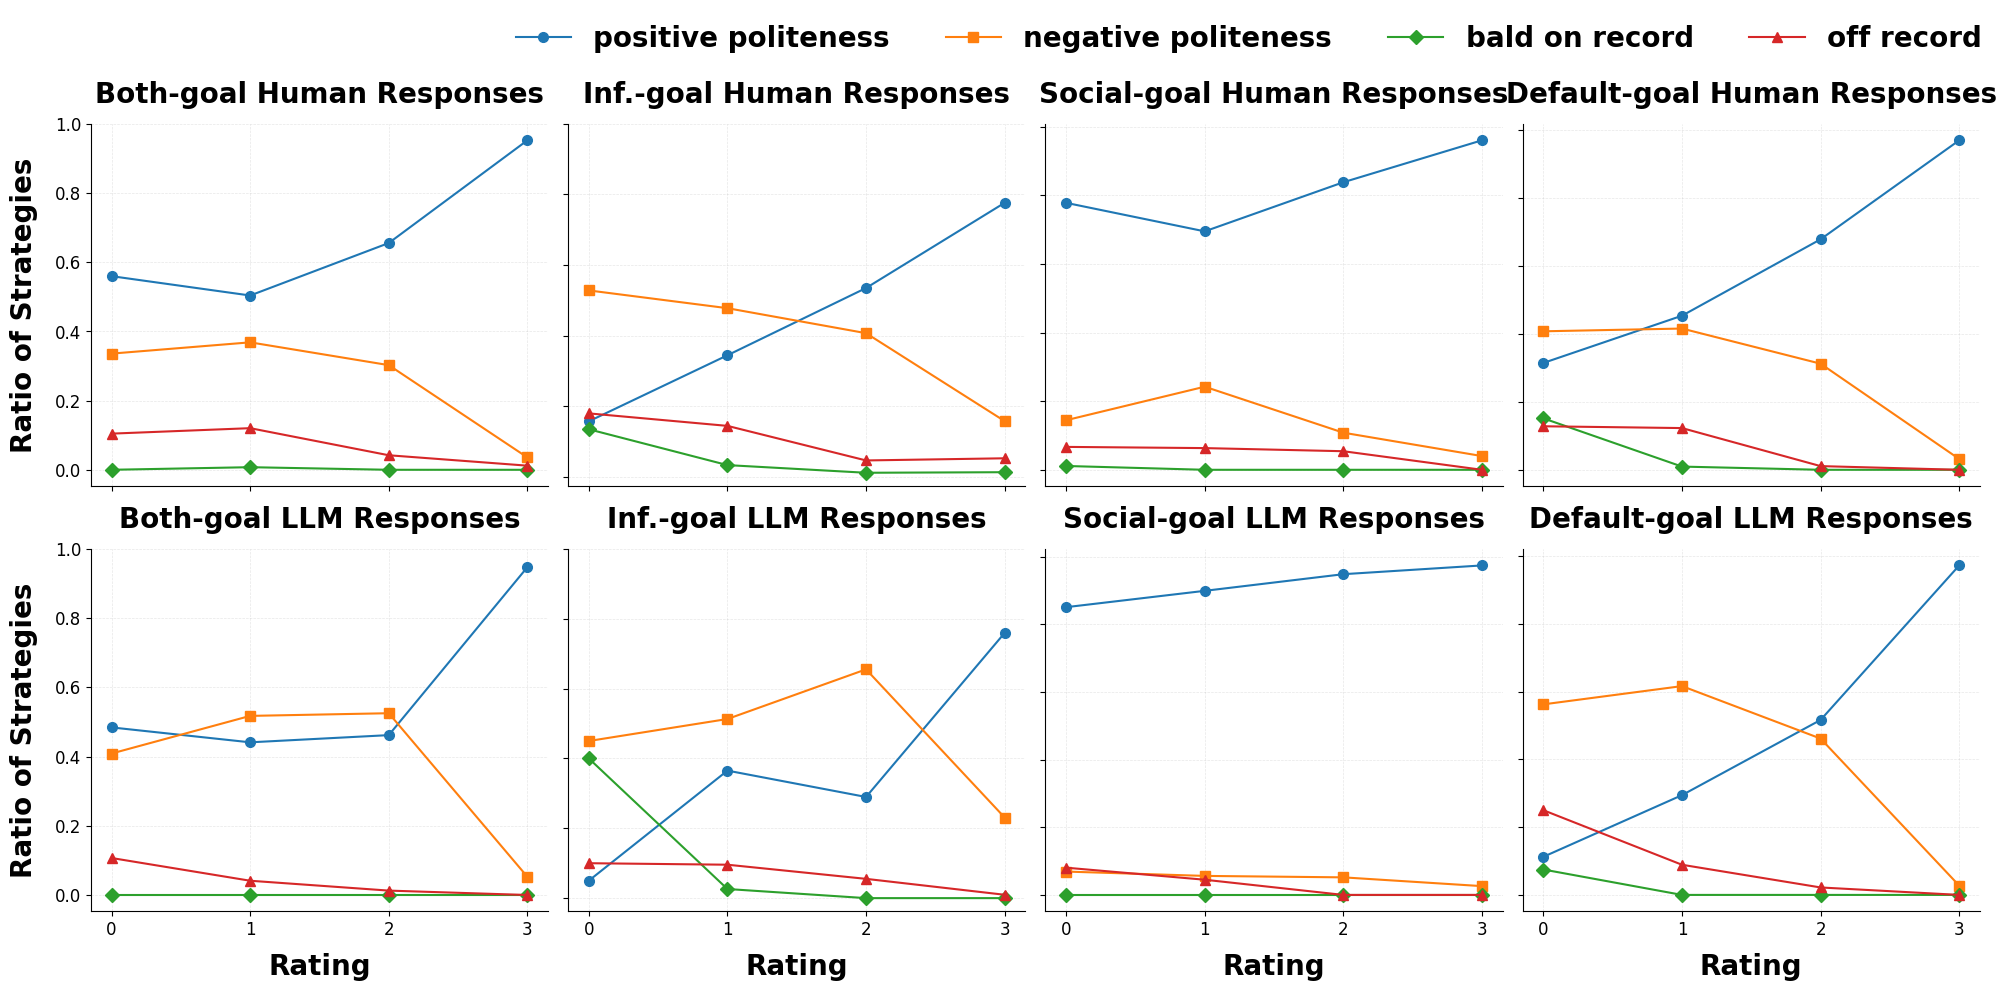

In [23]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

x = ["0", "1", "2", "3"]

# Define strategy names and markers
strategies = [
    ('positive politeness', 'o'),
    ('negative politeness', 's'),
    ('bald on record', 'D'),
    ('off record', '^')
]

# Create figure and axes: 2 rows, 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

# Create bold font
bold_font = font_manager.FontProperties(weight='bold')

# Titles and dataset
data_sets = [
    ("Both-goal Human Responses", y_positive_both_human, y_negative_both_human, y_bald_both_human, y_off_both_human),
    ("Inf.-goal Human Responses", y_positive_informative_human, y_negative_informative_human, y_bald_informative_human, y_off_informative_human),
    ("Social-goal Human Responses", y_positive_social_human, y_negative_social_human, y_bald_social_human, y_off_social_human),
    ("Default-goal Human Responses", y_positive_default_human, y_negative_default_human, y_bald_default_human, y_off_default_human),
    ("Both-goal LLM Responses", y_positive_both_llm, y_negative_both_llm, y_bald_both_llm, y_off_both_llm),
    ("Inf.-goal LLM Responses", y_positive_informative_llm, y_negative_informative_llm, y_bald_informative_llm, y_off_informative_llm),
    ("Social-goal LLM Responses", y_positive_social_llm, y_negative_social_llm, y_bald_social_llm, y_off_social_llm),
    ("Default-goal LLM Responses", y_positive_default_llm, y_negative_default_llm, y_bald_default_llm, y_off_default_llm),
]

# Plotting each subplot
for i, (title, y_pos, y_neg, y_bald, y_off) in enumerate(data_sets):
    ax = axs[i]
    
    for (strategy, marker), y_data in zip(strategies, [y_pos, y_neg, y_bald, y_off]):
        ax.plot(x, y_data, label=strategy, marker=marker, markersize=7)
    
    ax.set_title(title, fontsize=20, fontweight='bold', pad=15)

    # if i >= 4:
    #     ax.set_xlabel("Ratings", fontsize=17, fontweight='bold', labelpad=10)

    if i >= 4:
        ax.set_xlabel("Rating", fontsize=20, fontweight='bold', labelpad=10)
        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels(["0", "1", "2", "3"], fontsize=18)
    else:
        ax.set_xticklabels([])
    
    if i % 4 == 0:
        ax.set_ylabel("Ratio of Strategies", fontsize=20, fontweight='bold', labelpad=12)
    else:
        ax.set_yticklabels([])

    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis='both', labelsize=12)

    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add a single shared legend with bold text and title
handles, labels = axs[0].get_legend_handles_labels()
legend = fig.legend(
    handles,
    labels,
    loc='upper right',
    ncol=4,
    fontsize=20,
    # title='Strategy',
    # title_fontsize=14,
    frameon=False
)

# Make legend text and title bold
for text in legend.get_texts():
    text.set_fontweight('bold')
legend.get_title().set_fontweight('bold')

plt.tight_layout(rect=[0, 0, 1, 0.93])  # leave space for legend at top
plt.show()

# Save as PDF
fig.savefig('../plots/ratio of politeness_strategies change across ratings and goals.pdf', format='pdf', bbox_inches='tight')

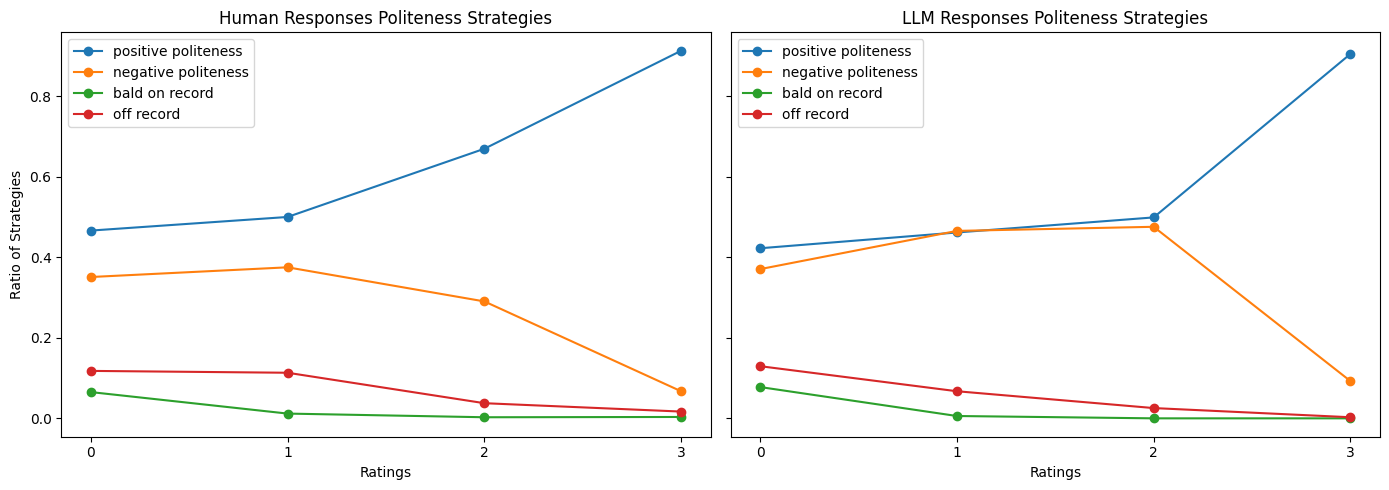

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# x-axis
x = ["0", "1", "2", "3"]

# y-axis data for human responses
y_positive_human = [
    strategy_frequency_rating_zero_human_responses_ratio['positive politeness'],
    strategy_frequency_rating_one_human_responses_ratio['positive politeness'],
    strategy_frequency_rating_two_human_responses_ratio['positive politeness'],
    strategy_frequency_rating_three_human_responses_ratio['positive politeness']
]
y_negative_human = [
    strategy_frequency_rating_zero_human_responses_ratio['negative politeness'],
    strategy_frequency_rating_one_human_responses_ratio['negative politeness'],
    strategy_frequency_rating_two_human_responses_ratio['negative politeness'],
    strategy_frequency_rating_three_human_responses_ratio['negative politeness']
]
y_bald_human = [
    strategy_frequency_rating_zero_human_responses_ratio['bald on record'],
    strategy_frequency_rating_one_human_responses_ratio['bald on record'],
    strategy_frequency_rating_two_human_responses_ratio['bald on record'],
    strategy_frequency_rating_three_human_responses_ratio['bald on record']
]
y_off_human = [
    strategy_frequency_rating_zero_human_responses_ratio['off record'],
    strategy_frequency_rating_one_human_responses_ratio['off record'],
    strategy_frequency_rating_two_human_responses_ratio['off record'],
    strategy_frequency_rating_three_human_responses_ratio['off record']
]

# y-axis data for LLM responses
y_positive_llm = [
    strategy_frequency_rating_zero_llm_responses_ratio['positive politeness'],
    strategy_frequency_rating_one_llm_responses_ratio['positive politeness'],
    strategy_frequency_rating_two_llm_responses_ratio['positive politeness'],
    strategy_frequency_rating_three_llm_responses_ratio['positive politeness']
]
y_negative_llm = [
    strategy_frequency_rating_zero_llm_responses_ratio['negative politeness'],
    strategy_frequency_rating_one_llm_responses_ratio['negative politeness'],
    strategy_frequency_rating_two_llm_responses_ratio['negative politeness'],
    strategy_frequency_rating_three_llm_responses_ratio['negative politeness']
]
y_bald_llm = [
    strategy_frequency_rating_zero_llm_responses_ratio['bald on record'],
    strategy_frequency_rating_one_llm_responses_ratio['bald on record'],
    strategy_frequency_rating_two_llm_responses_ratio['bald on record'],
    strategy_frequency_rating_three_llm_responses_ratio['bald on record']
]
y_off_llm = [
    strategy_frequency_rating_zero_llm_responses_ratio['off record'],
    strategy_frequency_rating_one_llm_responses_ratio['off record'],
    strategy_frequency_rating_two_llm_responses_ratio['off record'],
    strategy_frequency_rating_three_llm_responses_ratio['off record']
]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot human responses
axs[0].plot(x, y_positive_human, label='positive politeness', marker='o')
axs[0].plot(x, y_negative_human, label='negative politeness', marker='o')
axs[0].plot(x, y_bald_human, label='bald on record', marker='o')
axs[0].plot(x, y_off_human, label='off record', marker='o')
axs[0].set_title('Human Responses Politeness Strategies')
axs[0].set_xlabel('Ratings')
axs[0].set_ylabel('Ratio of Strategies')
axs[0].legend()

# Plot LLM responses
axs[1].plot(x, y_positive_llm, label='positive politeness', marker='o')
axs[1].plot(x, y_negative_llm, label='negative politeness', marker='o')
axs[1].plot(x, y_bald_llm, label='bald on record', marker='o')
axs[1].plot(x, y_off_llm, label='off record', marker='o')
axs[1].set_title('LLM Responses Politeness Strategies')
axs[1].set_xlabel('Ratings')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

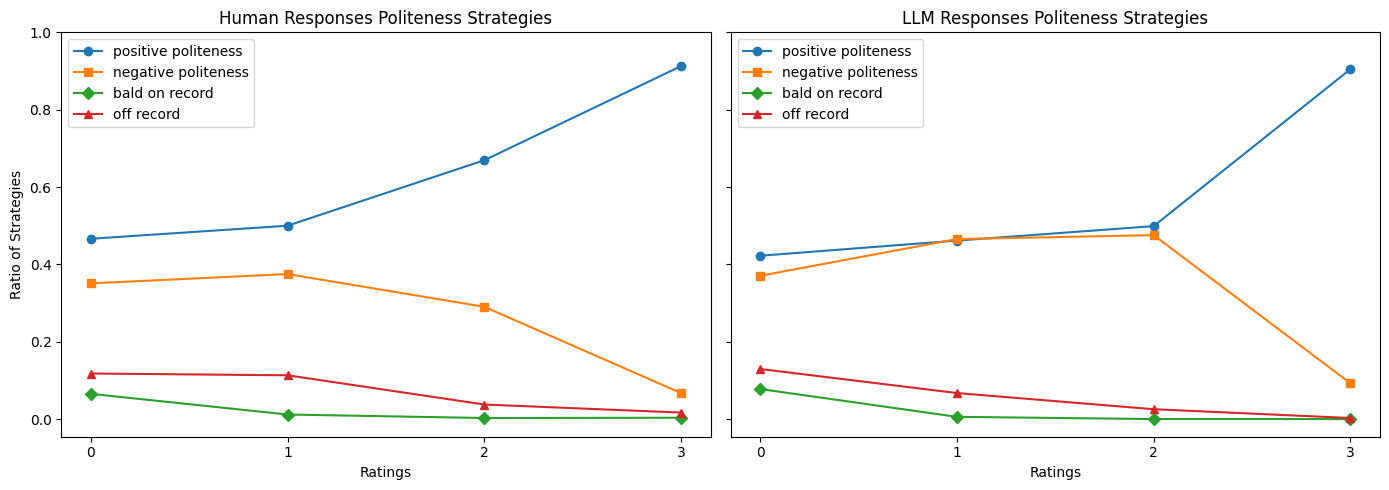

In [59]:
import matplotlib.pyplot as plt

x = ["0", "1", "2", "3"]

# Define strategy names and markers
strategies = [
    ('positive politeness', 'o'),
    ('negative politeness', 's'),
    ('bald on record', 'D'),
    ('off record', '^')
]

# Group response data
human_data = {
    s: [strategy_frequency_rating_zero_human_responses_ratio[s],
        strategy_frequency_rating_one_human_responses_ratio[s],
        strategy_frequency_rating_two_human_responses_ratio[s],
        strategy_frequency_rating_three_human_responses_ratio[s]]
    for s, _ in strategies
}

llm_data = {
    s: [strategy_frequency_rating_zero_llm_responses_ratio[s],
        strategy_frequency_rating_one_llm_responses_ratio[s],
        strategy_frequency_rating_two_llm_responses_ratio[s],
        strategy_frequency_rating_three_llm_responses_ratio[s]]
    for s, _ in strategies
}

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
titles = ['Human Responses Politeness Strategies', 'LLM Responses Politeness Strategies']
data_sets = [human_data, llm_data]

# Plotting
for ax, title, data in zip(axs, titles, data_sets):
    for (strategy, marker) in strategies:
        ax.plot(x, data[strategy], label=strategy, marker=marker)
    ax.set_title(title)
    ax.set_xlabel('Ratings')
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.legend()

axs[0].set_ylabel('Ratio of Strategies')

plt.tight_layout()
plt.show()

# save the plot as pdf
fig.savefig('../plots/ratio of politeness_strategies change across ratings.pdf', format='pdf', bbox_inches='tight')

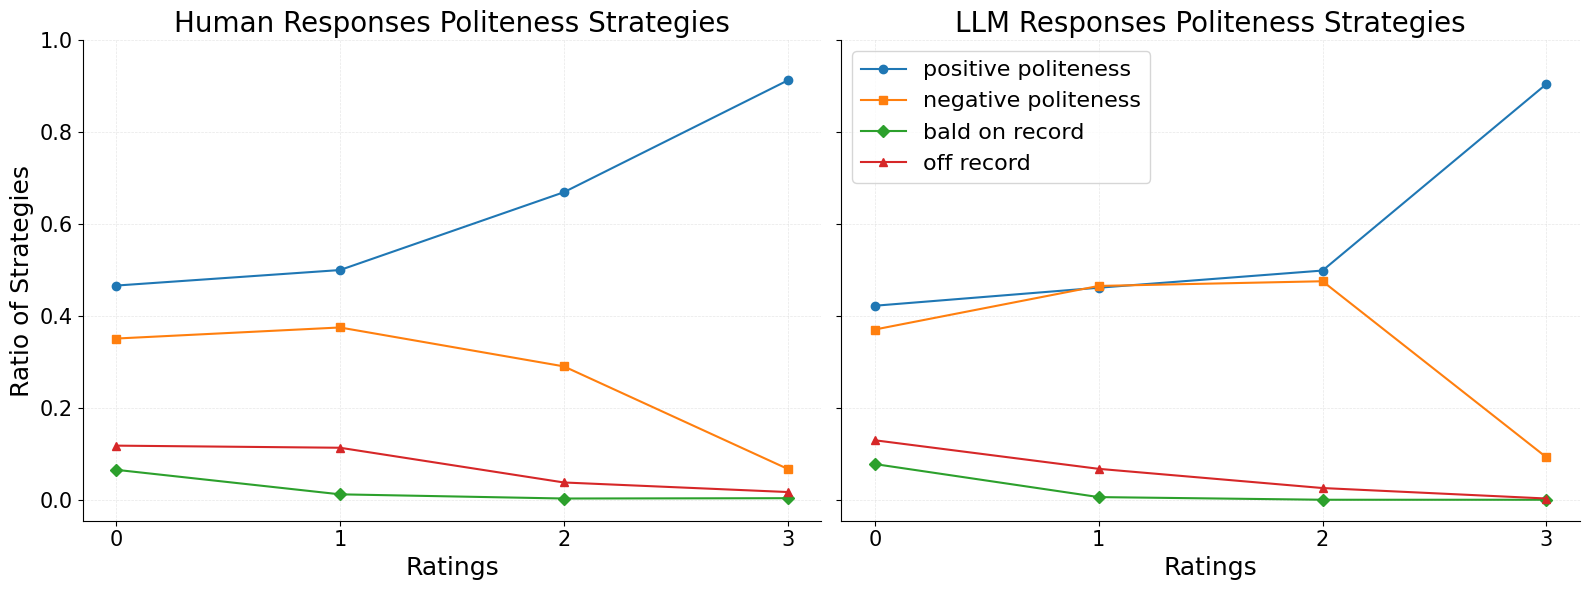

In [72]:
import matplotlib.pyplot as plt

x = ["0", "1", "2", "3"]

# Define strategy names and markers
strategies = [
    ('positive politeness', 'o'),
    ('negative politeness', 's'),
    ('bald on record', 'D'),
    ('off record', '^')
]

# Group response data
human_data = {
    s: [strategy_frequency_rating_zero_human_responses_ratio[s],
        strategy_frequency_rating_one_human_responses_ratio[s],
        strategy_frequency_rating_two_human_responses_ratio[s],
        strategy_frequency_rating_three_human_responses_ratio[s]]
    for s, _ in strategies
}

llm_data = {
    s: [strategy_frequency_rating_zero_llm_responses_ratio[s],
        strategy_frequency_rating_one_llm_responses_ratio[s],
        strategy_frequency_rating_two_llm_responses_ratio[s],
        strategy_frequency_rating_three_llm_responses_ratio[s]]
    for s, _ in strategies
}

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
titles = ['Human Responses Politeness Strategies', 'LLM Responses Politeness Strategies']
data_sets = [human_data, llm_data]

# Plotting
for ax, title, data in zip(axs, titles, data_sets):
    for (strategy, marker) in strategies:
        ax.plot(x, data[strategy], label=strategy, marker=marker)

    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Ratings', fontsize=18)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis='both', labelsize=15)
    

    # Add very light grid
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axs[0].set_ylabel('Ratio of Strategies', fontsize=18)
axs[1].legend(fontsize=16)

plt.tight_layout()
plt.show()

# Save the plot as a PDF
fig.savefig('../plots/ratio of politeness_strategies change across ratings.pdf', format='pdf', bbox_inches='tight')

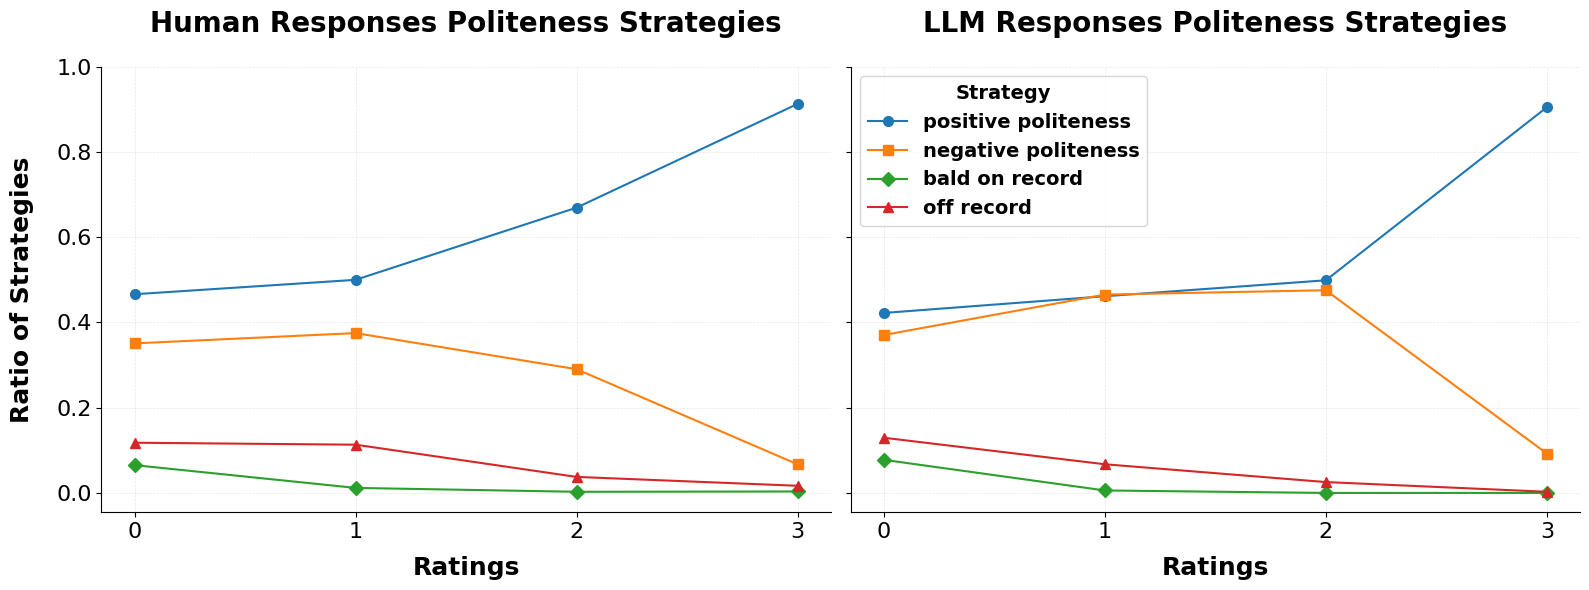

In [115]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

x = ["0", "1", "2", "3"]

# Define strategy names and markers
strategies = [
    ('positive politeness', 'o'),
    ('negative politeness', 's'),
    ('bald on record', 'D'),
    ('off record', '^')
]

# Group response data
human_data = {
    s: [strategy_frequency_rating_zero_human_responses_ratio[s],
        strategy_frequency_rating_one_human_responses_ratio[s],
        strategy_frequency_rating_two_human_responses_ratio[s],
        strategy_frequency_rating_three_human_responses_ratio[s]]
    for s, _ in strategies
}

llm_data = {
    s: [strategy_frequency_rating_zero_llm_responses_ratio[s],
        strategy_frequency_rating_one_llm_responses_ratio[s],
        strategy_frequency_rating_two_llm_responses_ratio[s],
        strategy_frequency_rating_three_llm_responses_ratio[s]]
    for s, _ in strategies
}

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
titles = ['Human Responses Politeness Strategies', 'LLM Responses Politeness Strategies']
data_sets = [human_data, llm_data]

# Create bold font
bold_font = font_manager.FontProperties(weight='bold')


title_pad = 25  # Increase this value to add more space

# Plotting
for ax, title, data in zip(axs, titles, data_sets):
    for (strategy, marker) in strategies:
        ax.plot(x, data[strategy], label=strategy, marker=marker, markersize=7)

    # Make title bold with increased font size
    ax.set_title(title, fontsize=20, fontweight='bold', pad=title_pad)
    
    # Make x-label bold
    ax.set_xlabel('Ratings', fontsize=18, fontweight='bold', labelpad=10)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis='both', labelsize=16)

    # Add very light grid
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Make y-label bold
axs[0].set_ylabel('Ratio of Strategies', fontsize=18, fontweight='bold', labelpad=16)

# Make legend bold
# legend = axs[1].legend(fontsize=16)
legend = axs[1].legend(fontsize=14, title='Strategy', title_fontsize=14)
for text in legend.get_texts():
    text.set_fontweight('bold')

legend.get_title().set_fontweight('bold')


plt.tight_layout()
plt.show()

# Save the plot as a PDF
fig.savefig('../plots/ratio of politeness_strategies change across ratings.pdf', format='pdf', bbox_inches='tight')

In [60]:
# Calculate word frequencies for each group
all_gpt_4_1_politeness_strategies_freq = {}
all_claude_3_7_politeness_strategies_freq = {}
all_golden_politeness_strategies_freq = {}
all_human_responses_golden_politeness_strategies_freq = {}
all_llm_responses_golden_politeness_strategies_freq = {}
both_goal_responses_golden_politeness_strategies_freq = {}
informative_goal_responses_golden_politeness_strategies_freq = {}
social_goal_responses_golden_politeness_strategies_freq = {}
default_goal_responses_golden_politeness_strategies_freq = {}
zero_rating_responses_golden_politeness_strategies_freq = {}
one_rating_responses_golden_politeness_strategies_freq = {}
two_rating_responses_golden_politeness_strategies_freq = {}
three_rating_responses_golden_politeness_strategies_freq = {}
preferred_responses_golden_politeness_strategies_freq = {}
non_preferred_responses_golden_politeness_strategies_freq = {}

for strategy in all_gpt_4_1_politeness_strategies:
    all_gpt_4_1_politeness_strategies_freq[strategy] = all_gpt_4_1_politeness_strategies_freq.get(strategy, 0) + 1
    
for strategy in all_claude_3_7_politeness_strategies:
    all_claude_3_7_politeness_strategies_freq[strategy] = all_claude_3_7_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in all_golden_politeness_strategies:
    all_golden_politeness_strategies_freq[strategy] = all_golden_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in all_human_responses_golden_politeness_strategies:
    all_human_responses_golden_politeness_strategies_freq[strategy] = all_human_responses_golden_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in all_llm_responses_golden_politeness_strategies:
    all_llm_responses_golden_politeness_strategies_freq[strategy] = all_llm_responses_golden_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in both_goal_responses_golden_politeness_strategies:
    both_goal_responses_golden_politeness_strategies_freq[strategy] = both_goal_responses_golden_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in informative_goal_responses_golden_politeness_strategies:
    informative_goal_responses_golden_politeness_strategies_freq[strategy] = informative_goal_responses_golden_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in social_goal_responses_golden_politeness_strategies:
    social_goal_responses_golden_politeness_strategies_freq[strategy] = social_goal_responses_golden_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in default_goal_responses_golden_politeness_strategies:
    default_goal_responses_golden_politeness_strategies_freq[strategy] = default_goal_responses_golden_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in zero_rating_responses_golden_politeness_strategies:
    zero_rating_responses_golden_politeness_strategies_freq[strategy] = zero_rating_responses_golden_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in one_rating_responses_golden_politeness_strategies:
    one_rating_responses_golden_politeness_strategies_freq[strategy] = one_rating_responses_golden_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in two_rating_responses_golden_politeness_strategies:
    two_rating_responses_golden_politeness_strategies_freq[strategy] = two_rating_responses_golden_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in three_rating_responses_golden_politeness_strategies:
    three_rating_responses_golden_politeness_strategies_freq[strategy] = three_rating_responses_golden_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in preferred_responses_golden_politeness_strategies:
    preferred_responses_golden_politeness_strategies_freq[strategy] = preferred_responses_golden_politeness_strategies_freq.get(strategy, 0) + 1

for strategy in non_preferred_responses_golden_politeness_strategies:
    non_preferred_responses_golden_politeness_strategies_freq[strategy] = non_preferred_responses_golden_politeness_strategies_freq.get(strategy, 0) + 1

# rank the politeness strategies by their frequency, and get the top 10 politeness strategies
    
all_gpt_4_1_politeness_strategies_freq = dict(sorted(all_gpt_4_1_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
all_claude_3_7_politeness_strategies_freq = dict(sorted(all_claude_3_7_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
all_golden_politeness_strategies_freq = dict(sorted(all_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
all_human_responses_golden_politeness_strategies_freq = dict(sorted(all_human_responses_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
all_llm_responses_golden_politeness_strategies_freq = dict(sorted(all_llm_responses_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
both_goal_responses_golden_politeness_strategies_freq = dict(sorted(both_goal_responses_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
informative_goal_responses_golden_politeness_strategies_freq = dict(sorted(informative_goal_responses_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
social_goal_responses_golden_politeness_strategies_freq = dict(sorted(social_goal_responses_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
default_goal_responses_golden_politeness_strategies_freq = dict(sorted(default_goal_responses_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
zero_rating_responses_golden_politeness_strategies_freq = dict(sorted(zero_rating_responses_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
one_rating_responses_golden_politeness_strategies_freq = dict(sorted(one_rating_responses_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
two_rating_responses_golden_politeness_strategies_freq = dict(sorted(two_rating_responses_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
three_rating_responses_golden_politeness_strategies_freq = dict(sorted(three_rating_responses_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
preferred_responses_golden_politeness_strategies_freq = dict(sorted(preferred_responses_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))
non_preferred_responses_golden_politeness_strategies_freq = dict(sorted(non_preferred_responses_golden_politeness_strategies_freq.items(), key=lambda item: item[1], reverse=True))

# get the top 10 politeness strategies
top_10_gpt_4_1_politeness_strategies_freq = dict(list(all_gpt_4_1_politeness_strategies_freq.items())[:10])
print("Top 10 GPT-4.1 Politeness Strategies Frequency:")
for strategy, freq in top_10_gpt_4_1_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_claude_3_7_politeness_strategies_freq = dict(list(all_claude_3_7_politeness_strategies_freq.items())[:10])
print("\nTop 10 Claude 3.7 Politeness Strategies Frequency:")
for strategy, freq in top_10_claude_3_7_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_golden_politeness_strategies_freq = dict(list(all_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_human_responses_golden_politeness_strategies_freq = dict(list(all_human_responses_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 Human Responses Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_human_responses_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_llm_responses_golden_politeness_strategies_freq = dict(list(all_llm_responses_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 LLM Responses Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_llm_responses_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_both_goal_responses_golden_politeness_strategies_freq = dict(list(both_goal_responses_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 Both Goal Responses Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_both_goal_responses_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_informative_goal_responses_golden_politeness_strategies_freq = dict(list(informative_goal_responses_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 Informative Goal Responses Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_informative_goal_responses_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_social_goal_responses_golden_politeness_strategies_freq = dict(list(social_goal_responses_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 Social Goal Responses Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_social_goal_responses_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_default_goal_responses_golden_politeness_strategies_freq = dict(list(default_goal_responses_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 Default Goal Responses Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_default_goal_responses_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_zero_rating_responses_golden_politeness_strategies_freq = dict(list(zero_rating_responses_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 Zero Rating Responses Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_zero_rating_responses_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_one_rating_responses_golden_politeness_strategies_freq = dict(list(one_rating_responses_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 One Rating Responses Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_one_rating_responses_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_two_rating_responses_golden_politeness_strategies_freq = dict(list(two_rating_responses_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 Two Rating Responses Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_two_rating_responses_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_three_rating_responses_golden_politeness_strategies_freq = dict(list(three_rating_responses_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 Three Rating Responses Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_three_rating_responses_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_preferred_responses_golden_politeness_strategies_freq = dict(list(preferred_responses_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 Preferred Responses Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_preferred_responses_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")

top_10_non_preferred_responses_golden_politeness_strategies_freq = dict(list(non_preferred_responses_golden_politeness_strategies_freq.items())[:10])
print("\nTop 10 Non Preferred Responses Golden Politeness Strategies Frequency:")
for strategy, freq in top_10_non_preferred_responses_golden_politeness_strategies_freq.items():
    print(f"{strategy}: {freq}")


Top 10 GPT-4.1 Politeness Strategies Frequency:
positive politeness-positive lexicon: 854
positive politeness-exaggerate interest, approval, sympathy: 436
negative politeness-question, hedge: 269
off record-understate: 243
positive politeness-be optimistic: 122
positive politeness-notice, attend to hearer's interests, wants, needs: 110
negative politeness-counterfactual modal forms: 82
off record-be vague: 80
positive politeness-avoid disagreement: 68
positive politeness-use in-group identity markers: 55

Top 10 Claude 3.7 Politeness Strategies Frequency:
positive politeness-positive lexicon: 997
positive politeness-exaggerate interest, approval, sympathy: 543
negative politeness-question, hedge: 525
positive politeness-avoid disagreement: 326
off record-understate: 326
negative politeness-minimize the imposition: 264
positive politeness-be optimistic: 202
positive politeness-notice, attend to hearer's interests, wants, needs: 141
negative politeness-counterfactual modal forms: 132
neg

#### Divergence analysis

In [85]:
import math
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import jensenshannon

def normalize_dict(word_dict):
    """Convert word counts to probabilities (normalize to sum to 1)"""
    total = sum(word_dict.values())
    return {word: count/total for word, count in word_dict.items()}

def dict_to_probability_vector(word_dict, all_words):
    """Convert dictionary to probability vector with consistent word ordering"""
    prob_dict = normalize_dict(word_dict)
    return np.array([prob_dict.get(word, 0.000001) for word in all_words])

def jensen_shannon_divergence(dict1, dict2):
    """Calculate Jensen-Shannon divergence between two word frequency dictionaries"""
    # Get all unique words from both dictionaries
    all_words = sorted(set(dict1.keys()) | set(dict2.keys()))
    
    # Convert to probability vectors
    p1 = dict_to_probability_vector(dict1, all_words)
    p2 = dict_to_probability_vector(dict2, all_words)
    
    # Calculate JSD (scipy's jensenshannon returns the square root of JSD)
    # We square it to get the actual JSD
    jsd = jensenshannon(p1, p2) ** 2
    
    return jsd


def create_null_distribution(dict1, dict2, n_permutations=1000, method='shuffle'):
    """
    Create null distribution by randomly shuffling word assignments
    while preserving total counts
    
    Parameters:
    - method: 'shuffle' (shuffles individual tokens) or 'resample' (resamples from combined pool)
    """
    if method == 'shuffle':
        # Original method: shuffle individual tokens
        # Combine all words and their total counts
        combined_dict = defaultdict(int)
        for word, count in dict1.items():
            combined_dict[word] += count
        for word, count in dict2.items():
            combined_dict[word] += count
        
        # Get total counts for each dictionary
        total1 = sum(dict1.values())
        total2 = sum(dict2.values())
        
        null_jsds = []
        
        for _ in range(n_permutations):
            # Create a list of all word tokens
            all_tokens = []
            for word, count in combined_dict.items():
                all_tokens.extend([word] * count)
            
            # Randomly shuffle all tokens
            random.shuffle(all_tokens)
            
            # Split randomly into two groups matching original sizes
            shuffled_dict1 = defaultdict(int)
            shuffled_dict2 = defaultdict(int)
            
            for i, word in enumerate(all_tokens):
                if i < total1:
                    shuffled_dict1[word] += 1
                else:
                    shuffled_dict2[word] += 1
            
            # Calculate JSD for this permutation
            jsd = jensen_shannon_divergence(shuffled_dict1, shuffled_dict2)
            null_jsds.append(jsd)
    
    elif method == 'resample':
        # Alternative method: resample from combined probability distribution
        # Combine dictionaries to get overall word probabilities
        combined_dict = defaultdict(int)
        for word, count in dict1.items():
            combined_dict[word] += count
        for word, count in dict2.items():
            combined_dict[word] += count
        
        # Convert to probabilities
        total_combined = sum(combined_dict.values())
        words = list(combined_dict.keys())
        probs = [combined_dict[word] / total_combined for word in words]
        
        # Get original total counts
        total1 = sum(dict1.values())
        total2 = sum(dict2.values())
        
        null_jsds = []
        
        for _ in range(n_permutations):
            # Resample words for each dictionary
            sample1 = np.random.choice(words, size=total1, p=probs)
            sample2 = np.random.choice(words, size=total2, p=probs)
            
            # Count frequencies
            resampled_dict1 = defaultdict(int)
            resampled_dict2 = defaultdict(int)
            
            for word in sample1:
                resampled_dict1[word] += 1
            for word in sample2:
                resampled_dict2[word] += 1
            
            # Calculate JSD for this permutation
            jsd = jensen_shannon_divergence(resampled_dict1, resampled_dict2)
            null_jsds.append(jsd)
    
    else:
        raise ValueError("method must be 'shuffle' or 'resample'")
    
    return null_jsds

def calculate_p_value(observed_jsd, null_distribution):
    """Calculate p-value based on null distribution"""
    # Count how many null values are greater than or equal to observed
    greater_or_equal = sum(1 for null_jsd in null_distribution if null_jsd >= observed_jsd)
    p_value = greater_or_equal / len(null_distribution)
    return p_value

def compare_word_distributions(dict1, dict2, n_permutations=1000, null_method='shuffle'):
    """
    Complete analysis comparing two word frequency dictionaries
    
    Parameters:
    - dict1, dict2: dictionaries with word frequencies
    - n_permutations: number of permutations for null distribution
    - null_method: 'shuffle' (default) or 'resample' for different null models
    """
    # Calculate observed JSD
    observed_jsd = jensen_shannon_divergence(dict1, dict2)
    
    # Generate null distribution
    null_distribution = create_null_distribution(dict1, dict2, n_permutations, method=null_method)
    
    # Calculate p-value
    p_value = calculate_p_value(observed_jsd, null_distribution)
    
    # Calculate statistics
    null_mean = np.mean(null_distribution)
    null_std = np.std(null_distribution)
    null_percentiles = np.percentile(null_distribution, [5, 25, 50, 75, 95])
    
    results = {
        'observed_jsd': observed_jsd,
        'p_value': p_value,
        'null_mean': null_mean,
        'null_std': null_std,
        'null_percentiles': {
            '5%': null_percentiles[0],
            '25%': null_percentiles[1],
            '50%': null_percentiles[2],
            '75%': null_percentiles[3],
            '95%': null_percentiles[4]
        },
        'null_distribution': null_distribution
    }
    
    return results

def visualize_results(results, title="JSD Analysis Results"):
    """Create visualization of null distribution and observed JSD"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Histogram of null distribution
    ax1.hist(results['null_distribution'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
    ax1.axvline(results['observed_jsd'], color='red', linestyle='--', linewidth=2, label=f'Observed JSD: {results["observed_jsd"]:.4f}')
    ax1.axvline(results['null_mean'], color='green', linestyle='-', linewidth=2, label=f'Null Mean: {results["null_mean"]:.4f}')
    ax1.set_xlabel('Jensen-Shannon Divergence')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Null Distribution of JSD')
    ax1.legend()
    
    # Plot 2: Box plot comparison
    box_data = [results['null_distribution'], [results['observed_jsd']]]
    ax2.boxplot(box_data, tick_labels=['Null Distribution', 'Observed'])
    ax2.set_ylabel('Jensen-Shannon Divergence')
    ax2.set_title('JSD Comparison')
    
    plt.suptitle(f'{title}\np-value: {results["p_value"]:.6f}', fontsize=14)
    plt.tight_layout()
    plt.show()

def analyze_your_data(dict1, dict2, null_method='shuffle'):    
    results = compare_word_distributions(dict1, dict2, n_permutations=1000, null_method=null_method)
    visualize_results(results)
    print(f"\nDictionary 1 Summary:")
    print(f"  Total words: {sum(dict1.values())}")
    print(f"  Unique words: {len(dict1)}")
    print(f"  Most frequent: {max(dict1.items(), key=lambda x: x[1])}")
    
    print(f"\nDictionary 2 Summary:")
    print(f"  Total words: {sum(dict2.values())}")
    print(f"  Unique words: {len(dict2)}")
    print(f"  Most frequent: {max(dict2.items(), key=lambda x: x[1])}")
    
    print(f"\nStatistical Analysis:")
    print(f"  Observed JSD: {results['observed_jsd']:.6f}")
    print(f"  P-value: {results['p_value']:.6f}")
    print(f"  Null distribution mean: {results['null_mean']:.6f}")
    print(f"  Null distribution std: {results['null_std']:.6f}")

gpt4-1 vs. claude-3.7 agreement


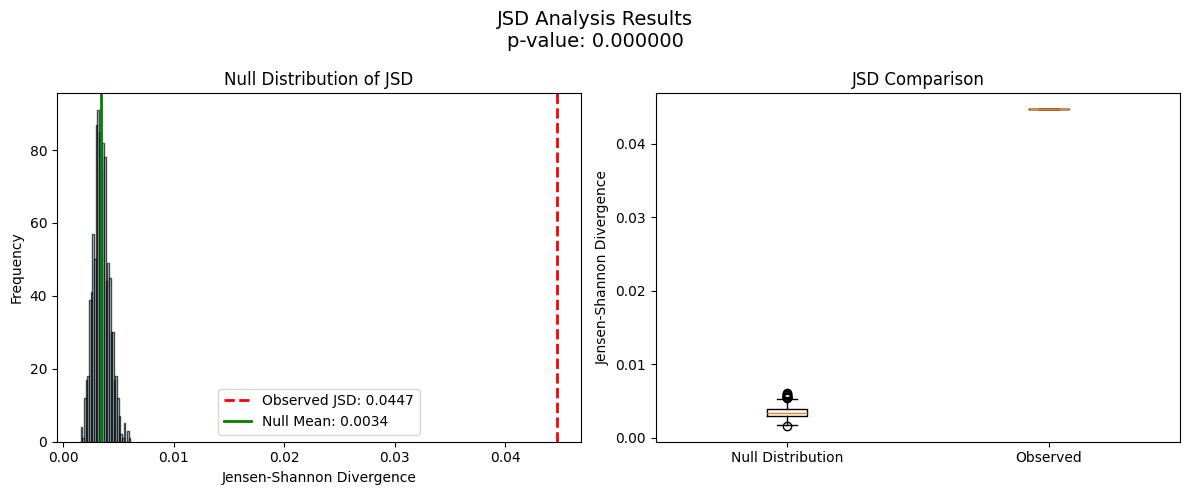


Dictionary 1 Summary:
  Total words: 2559
  Unique words: 36
  Most frequent: ('positive politeness-positive lexicon', 854)

Dictionary 2 Summary:
  Total words: 4154
  Unique words: 40
  Most frequent: ('positive politeness-positive lexicon', 997)

Statistical Analysis:
  Observed JSD: 0.044703
  P-value: 0.000000
  Null distribution mean: 0.003435
  Null distribution std: 0.000726
human vs. llm agreement


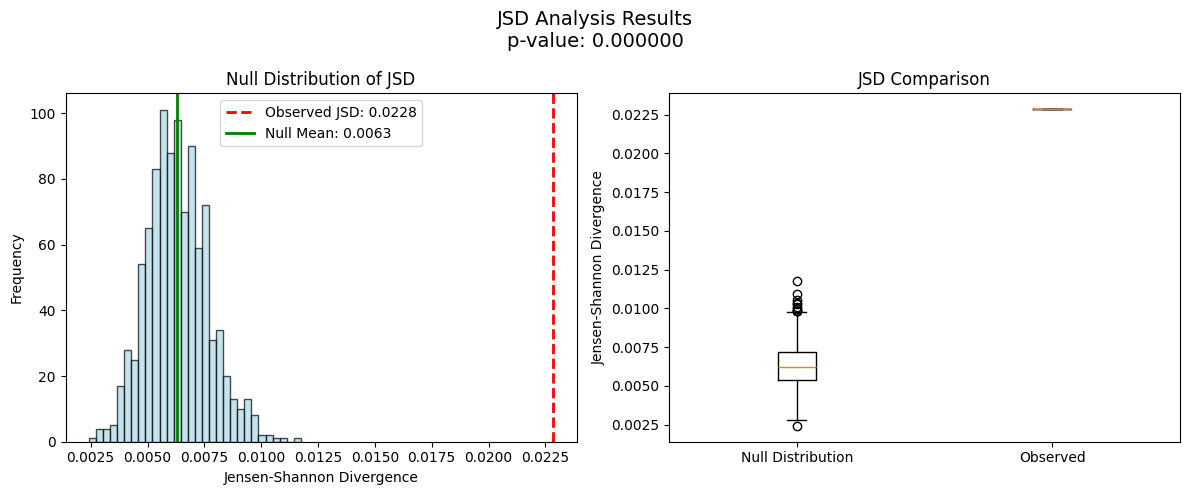


Dictionary 1 Summary:
  Total words: 1493
  Unique words: 39
  Most frequent: ('positive politeness-positive lexicon', 461)

Dictionary 2 Summary:
  Total words: 1745
  Unique words: 27
  Most frequent: ('positive politeness-positive lexicon', 551)

Statistical Analysis:
  Observed JSD: 0.022850
  P-value: 0.000000
  Null distribution mean: 0.006314
  Null distribution std: 0.001347
preferred vs. non-preferred agreement


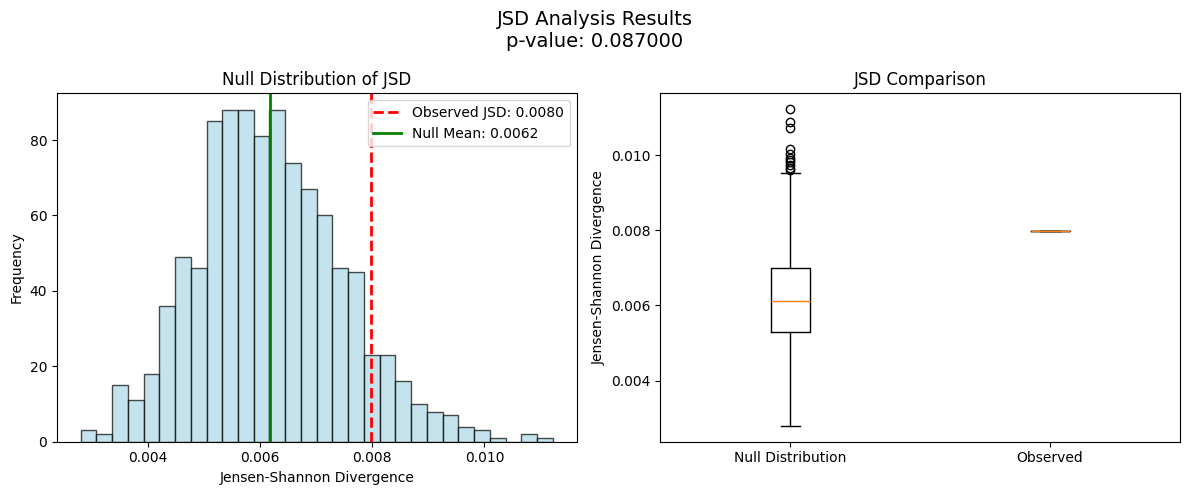


Dictionary 1 Summary:
  Total words: 1753
  Unique words: 36
  Most frequent: ('positive politeness-positive lexicon', 536)

Dictionary 2 Summary:
  Total words: 1558
  Unique words: 35
  Most frequent: ('positive politeness-positive lexicon', 518)

Statistical Analysis:
  Observed JSD: 0.007980
  P-value: 0.087000
  Null distribution mean: 0.006180
  Null distribution std: 0.001303


In [87]:
import numpy as np
print("gpt4-1 vs. claude-3.7 agreement")
analyze_your_data(all_gpt_4_1_politeness_strategies_freq, all_claude_3_7_politeness_strategies_freq, null_method = "resample")

print("human vs. llm agreement")
analyze_your_data(all_human_responses_golden_politeness_strategies_freq, all_llm_responses_golden_politeness_strategies_freq, null_method = "resample")

print("preferred vs. non-preferred agreement")
analyze_your_data(preferred_responses_golden_politeness_strategies_freq, non_preferred_responses_golden_politeness_strategies_freq, null_method = "resample")

In [244]:
import numpy as np
from scipy.spatial.distance import jensenshannon
import random
from collections import defaultdict
import json
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import pandas as pd

def normalize_dict(word_dict):
    """Convert word counts to probabilities (normalize to sum to 1)"""
    total = sum(word_dict.values())
    return {word: count/total for word, count in word_dict.items()}

def dict_to_probability_vector(word_dict, all_words):
    """Convert dictionary to probability vector with consistent word ordering"""
    prob_dict = normalize_dict(word_dict)
    return np.array([prob_dict.get(word, 0) for word in all_words])

def jensen_shannon_divergence(dict1, dict2):
    """Calculate Jensen-Shannon divergence between two word frequency dictionaries"""
    # Get all unique words from both dictionaries
    all_words = sorted(set(dict1.keys()) | set(dict2.keys()))
    
    # Convert to probability vectors
    p1 = dict_to_probability_vector(dict1, all_words)
    p2 = dict_to_probability_vector(dict2, all_words)
    
    # Calculate JSD (scipy's jensenshannon returns the square root of JSD)
    # We square it to get the actual JSD
    jsd = jensenshannon(p1, p2) ** 2
    
    return jsd

def create_pairwise_null_distribution(dict_list, n_permutations=1000, method='shuffle'):
    """
    Create null distribution for all pairwise comparisons between dictionaries
    
    Parameters:
    - dict_list: list of dictionaries [dict1, dict2, dict3, dict4]
    - n_permutations: number of permutations for null distribution
    - method: 'shuffle' or 'resample'
    
    Returns:
    - Dictionary with keys as tuples of indices (i,j) and values as list of JSD values
    """
    # Number of dictionaries
    n_dicts = len(dict_list)
    
    # Create all pairwise combinations
    pairs = list(itertools.combinations(range(n_dicts), 2))
    
    # Initialize results dictionary
    null_distributions = {pair: [] for pair in pairs}
    
    if method == 'shuffle':
        # Combine all words and their total counts
        combined_dict = defaultdict(int)
        for d in dict_list:
            for word, count in d.items():
                combined_dict[word] += count
        
        # Get total counts for each dictionary
        totals = [sum(d.values()) for d in dict_list]
        
        # For each permutation
        for _ in range(n_permutations):
            # Create a list of all word tokens
            all_tokens = []
            for word, count in combined_dict.items():
                all_tokens.extend([word] * count)
            
            # Randomly shuffle all tokens
            random.shuffle(all_tokens)
            
            # Split shuffled tokens into n_dicts groups
            shuffled_dicts = []
            start_idx = 0
            
            for total in totals:
                shuffled_dict = defaultdict(int)
                end_idx = start_idx + total
                
                for word in all_tokens[start_idx:end_idx]:
                    shuffled_dict[word] += 1
                
                shuffled_dicts.append(shuffled_dict)
                start_idx = end_idx
            
            # Calculate JSD for each pair in this permutation
            for (i, j) in pairs:
                jsd = jensen_shannon_divergence(shuffled_dicts[i], shuffled_dicts[j])
                null_distributions[(i, j)].append(jsd)
    
    elif method == 'resample':
        # Combine dictionaries to get overall word probabilities
        combined_dict = defaultdict(int)
        for d in dict_list:
            for word, count in d.items():
                combined_dict[word] += count
        
        # Convert to probabilities
        total_combined = sum(combined_dict.values())
        words = list(combined_dict.keys())
        probs = [combined_dict[word] / total_combined for word in words]
        
        # Get original total counts
        totals = [sum(d.values()) for d in dict_list]
        
        # For each permutation
        for _ in range(n_permutations):
            # Resample words for each dictionary
            shuffled_dicts = []
            
            for total in totals:
                sample = np.random.choice(words, size=total, p=probs)
                
                # Count frequencies
                resampled_dict = defaultdict(int)
                for word in sample:
                    resampled_dict[word] += 1
                
                shuffled_dicts.append(resampled_dict)
            
            # Calculate JSD for each pair in this permutation
            for (i, j) in pairs:
                jsd = jensen_shannon_divergence(shuffled_dicts[i], shuffled_dicts[j])
                null_distributions[(i, j)].append(jsd)
    
    else:
        raise ValueError("method must be 'shuffle' or 'resample'")
    
    return null_distributions

def multi_dict_jsd_analysis(dict_list, names=None, n_permutations=1000, method='shuffle'):
    """
    Complete analysis comparing multiple dictionaries
    
    Parameters:
    - dict_list: list of dictionaries [dict1, dict2, dict3, dict4]
    - names: optional list of names for the dictionaries
    - n_permutations: number of permutations for null distribution
    - method: 'shuffle' or 'resample'
    
    Returns:
    - Dictionary with results
    """
    n_dicts = len(dict_list)
    
    if names is None:
        names = [f"Dict {i+1}" for i in range(n_dicts)]
    
    # Calculate all pairwise observed JSDs
    pairs = list(itertools.combinations(range(n_dicts), 2))
    observed_jsds = {}
    
    for (i, j) in pairs:
        observed_jsds[(i, j)] = jensen_shannon_divergence(dict_list[i], dict_list[j])
    
    # Generate null distributions
    null_distributions = create_pairwise_null_distribution(
        dict_list, n_permutations=n_permutations, method=method
    )
    
    # Calculate p-values and statistics
    results = {
        'names': names,
        'n_dicts': n_dicts,
        'observed_jsds': {},
        'p_values': {},
        'null_means': {},
        'null_stds': {},
        'null_percentiles': {},
        'significant': {},
        'null_distributions': {}
    }
    
    for (i, j) in pairs:
        pair_name = f"{names[i]} vs {names[j]}"
        observed_jsd = observed_jsds[(i, j)]
        null_dist = null_distributions[(i, j)]
        
        # Calculate p-value
        greater_or_equal = sum(1 for null_jsd in null_dist if null_jsd >= observed_jsd)
        p_value = greater_or_equal / len(null_dist)
        
        # Calculate statistics
        null_mean = np.mean(null_dist)
        null_std = np.std(null_dist)
        null_percentiles = np.percentile(null_dist, [5, 25, 50, 75, 95])
        
        # Store results
        results['observed_jsds'][pair_name] = observed_jsd
        results['p_values'][pair_name] = p_value
        results['null_means'][pair_name] = null_mean
        results['null_stds'][pair_name] = null_std
        results['null_percentiles'][pair_name] = {
            '5%': null_percentiles[0],
            '25%': null_percentiles[1],
            '50%': null_percentiles[2],
            '75%': null_percentiles[3],
            '95%': null_percentiles[4]
        }
        results['significant'][pair_name] = p_value < 0.05
        results['null_distributions'][pair_name] = null_dist
    
    return results

def create_jsd_matrix(dict_list, names=None):
    """Create a matrix of pairwise JSD values"""
    n_dicts = len(dict_list)
    
    if names is None:
        names = [f"Dict {i+1}" for i in range(n_dicts)]
    
    # Initialize matrix
    jsd_matrix = np.zeros((n_dicts, n_dicts))
    
    # Calculate all pairwise JSDs
    for i in range(n_dicts):
        for j in range(n_dicts):
            if i != j:
                jsd_matrix[i, j] = jensen_shannon_divergence(dict_list[i], dict_list[j])
    
    return jsd_matrix, names

def visualize_jsd_matrix(jsd_matrix, names, title="Pairwise JSD Matrix"):
    """Visualize the matrix of pairwise JSD values"""
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(jsd_matrix, dtype=bool))
    
    # Use a custom diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    # Draw the heatmap
    sns.heatmap(jsd_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=True, fmt=".3f", xticklabels=names, yticklabels=names)
    
    plt.title(title)
    plt.tight_layout()
    return plt.gcf()

def visualize_multi_results(results, title="Multiple Dictionary JSD Analysis"):
    """Create visualizations for multi-dictionary JSD analysis"""
    n_pairs = len(results['observed_jsds'])
    n_cols = min(3, n_pairs)
    n_rows = (n_pairs + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    
    if n_pairs == 1:
        axes = np.array([axes])
    
    axes = axes.flatten()
    
    for i, (pair_name, observed_jsd) in enumerate(results['observed_jsds'].items()):
        if i < len(axes):
            ax = axes[i]
            null_dist = results['null_distributions'][pair_name]
            
            # Histogram
            ax.hist(null_dist, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
            ax.axvline(observed_jsd, color='red', linestyle='--', linewidth=2, 
                       label=f'Observed: {observed_jsd:.4f}')
            ax.axvline(results['null_means'][pair_name], color='green', linestyle='-', linewidth=2,
                          label=f'Null Mean: {results["null_means"][pair_name]:.4f}')
            
            # Add p-value and significance
            p_value = results['p_values'][pair_name]
            if p_value < 0.001:
                significance = "p < 0.001 ***"
            elif p_value < 0.01:
                significance = f"p = {p_value:.4f} **"
            elif p_value < 0.05:
                significance = f"p = {p_value:.4f} *"
            else:
                significance = f"p = {p_value:.4f} (n.s.)"
            
            ax.set_title(f"{pair_name}\n{significance}")
            ax.set_xlabel('Jensen-Shannon Divergence')
            ax.set_ylabel('Frequency')
            ax.legend()
    
    # Hide any unused subplots
    for i in range(n_pairs, len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

def create_multi_summary_report(dict_list, results, names=None):
    """Create a summary report for multi-dictionary analysis"""
    n_dicts = len(dict_list)
    
    if names is None:
        names = [f"Dict {i+1}" for i in range(n_dicts)]
    
    print("="*80)
    print("MULTIPLE DICTIONARY WORD FREQUENCY DISTRIBUTION COMPARISON REPORT")
    print("="*80)
    
    # Summary of dictionaries
    for i, d in enumerate(dict_list):
        print(f"\n{names[i]} Summary:")
        print(f"  Total words: {sum(d.values())}")
        print(f"  Unique words: {len(d)}")
        try:
            print(f"  Most frequent: {max(d.items(), key=lambda x: x[1])}")
        except ValueError:
            print("  No words found")
    
    # Pairwise comparisons
    print("\nPairwise Comparisons:")
    for pair_name in results['observed_jsds']:
        observed_jsd = results['observed_jsds'][pair_name]
        p_value = results['p_values'][pair_name]
        
     #    # Format significance markers
     #    if p_value < 0.001:
     #        significance = "***"
     #    elif p_value < 0.01:
     #        significance = "**"
     #    elif p_value < 0.05:
     #        significance = "*"
     #    else:
     #        significance = "n.s."
        
        print(f"  {pair_name}:")
        print(f"    - JSD: {observed_jsd:.6f}")
        print(f"    - p-value: {p_value:.6f}")
     #    print(f"    - p-value: {p_value:.6f} {significance}")
    
    # Overall summary
    print("\nOverall Summary:")
    # Find most similar pair
    most_similar_pair = min(results['observed_jsds'].items(), key=lambda x: x[1])
    # Find most different pair
    most_different_pair = max(results['observed_jsds'].items(), key=lambda x: x[1])
    
    print(f"  Most similar pair: {most_similar_pair[0]} (JSD: {most_similar_pair[1]:.6f})")
    print(f"  Most different pair: {most_different_pair[0]} (JSD: {most_different_pair[1]:.6f})")
    
    # Count significant differences
    sig_count = sum(1 for is_sig in results['significant'].values() if is_sig)
    total_pairs = len(results['significant'])
    
    print(f"  Significant differences: {sig_count} out of {total_pairs} pairs")
    
    print("="*80)




MULTIPLE DICTIONARY WORD FREQUENCY DISTRIBUTION COMPARISON REPORT

all_gpt_4_1_politeness_strategies Summary:
  Total words: 2559
  Unique words: 36
  Most frequent: ('positive politeness-positive lexicon', 854)

all_claude_3_7_politeness_strategies Summary:
  Total words: 4154
  Unique words: 40
  Most frequent: ('positive politeness-positive lexicon', 997)

all_golden_politeness_strategies Summary:
  Total words: 3238
  Unique words: 40
  Most frequent: ('positive politeness-positive lexicon', 1012)

Pairwise Comparisons:
  all_gpt_4_1_politeness_strategies vs all_claude_3_7_politeness_strategies:
    - JSD: 0.044731
    - p-value: 0.000000
  all_gpt_4_1_politeness_strategies vs all_golden_politeness_strategies:
    - JSD: 0.072782
    - p-value: 0.000000
  all_claude_3_7_politeness_strategies vs all_golden_politeness_strategies:
    - JSD: 0.025568
    - p-value: 0.000000

Overall Summary:
  Most similar pair: all_claude_3_7_politeness_strategies vs all_golden_politeness_strategies 

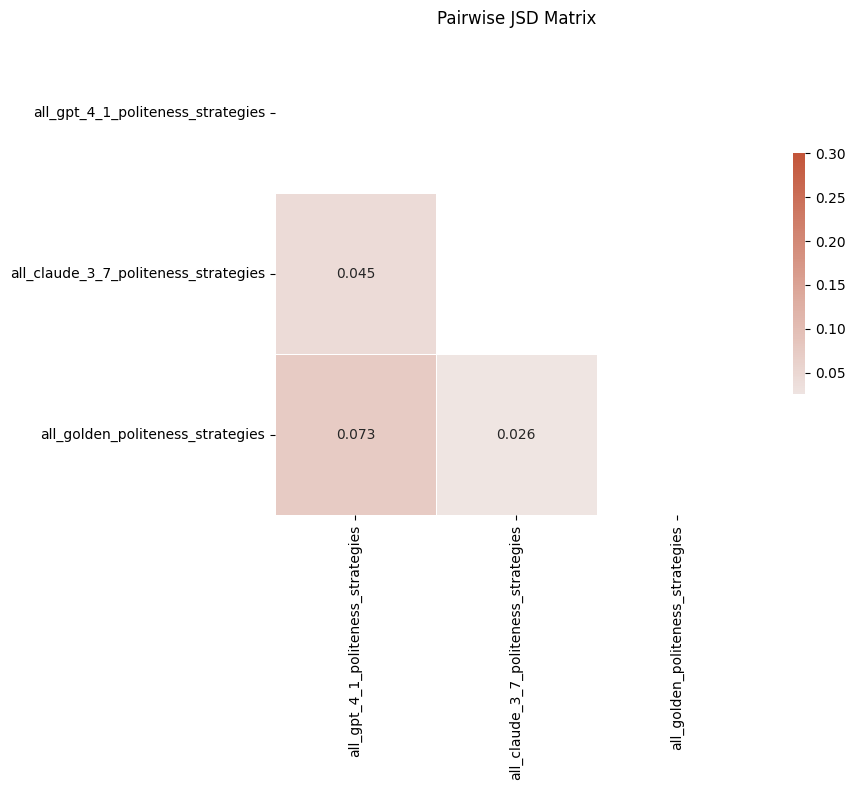

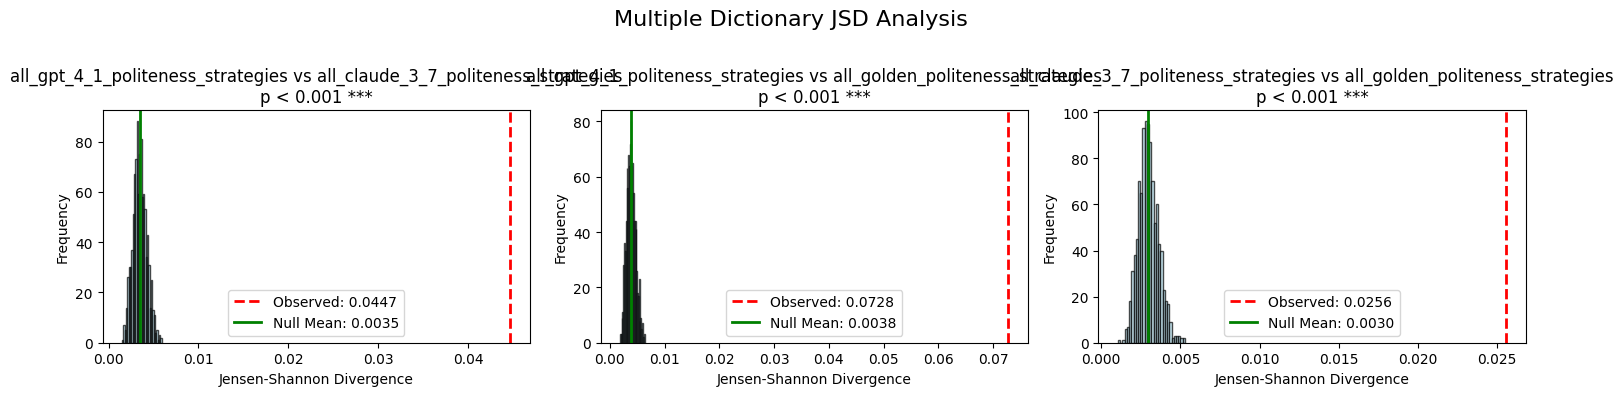

In [245]:


# Names for the dictionaries
names = ["all_gpt_4_1_politeness_strategies", "all_claude_3_7_politeness_strategies", "all_golden_politeness_strategies"]

# Create list of dictionaries
dict_list = [all_gpt_4_1_politeness_strategies_freq, all_claude_3_7_politeness_strategies_freq, all_golden_politeness_strategies_freq]

# Run the analysis
results = multi_dict_jsd_analysis(dict_list, names=names, n_permutations=1000, method = "resample")

# Generate report
create_multi_summary_report(dict_list, results, names=names)

# Create and save visualizations
jsd_matrix, matrix_names = create_jsd_matrix(dict_list, names=names)
matrix_fig = visualize_jsd_matrix(jsd_matrix, matrix_names)
#     matrix_fig.savefig("jsd_matrix.png")

results_fig = visualize_multi_results(results)
#     results_fig.savefig("multi_jsd_analysis.png")

print("Analysis complete! Visualizations and results have been saved.")

MULTIPLE DICTIONARY WORD FREQUENCY DISTRIBUTION COMPARISON REPORT

both-goal responses Summary:
  Total words: 1071
  Unique words: 27
  Most frequent: ('positive politeness-positive lexicon', 313)

informative-goal responses Summary:
  Total words: 765
  Unique words: 30
  Most frequent: ('positive politeness-positive lexicon', 209)

social-goal responses Summary:
  Total words: 664
  Unique words: 32
  Most frequent: ('positive politeness-positive lexicon', 298)

default-goal responses Summary:
  Total words: 738
  Unique words: 29
  Most frequent: ('positive politeness-positive lexicon', 192)

Pairwise Comparisons:
  both-goal responses vs informative-goal responses:
    - JSD: 0.060058
    - p-value: 0.000000
  both-goal responses vs social-goal responses:
    - JSD: 0.106877
    - p-value: 0.000000
  both-goal responses vs default-goal responses:
    - JSD: 0.032520
    - p-value: 0.000000
  informative-goal responses vs social-goal responses:
    - JSD: 0.180240
    - p-value: 0.

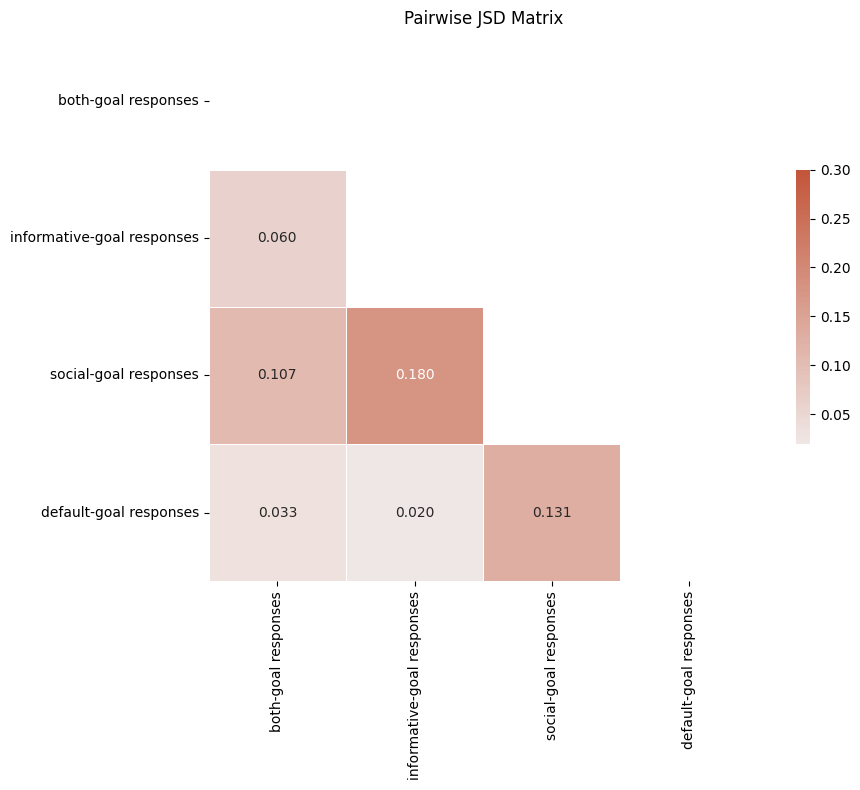

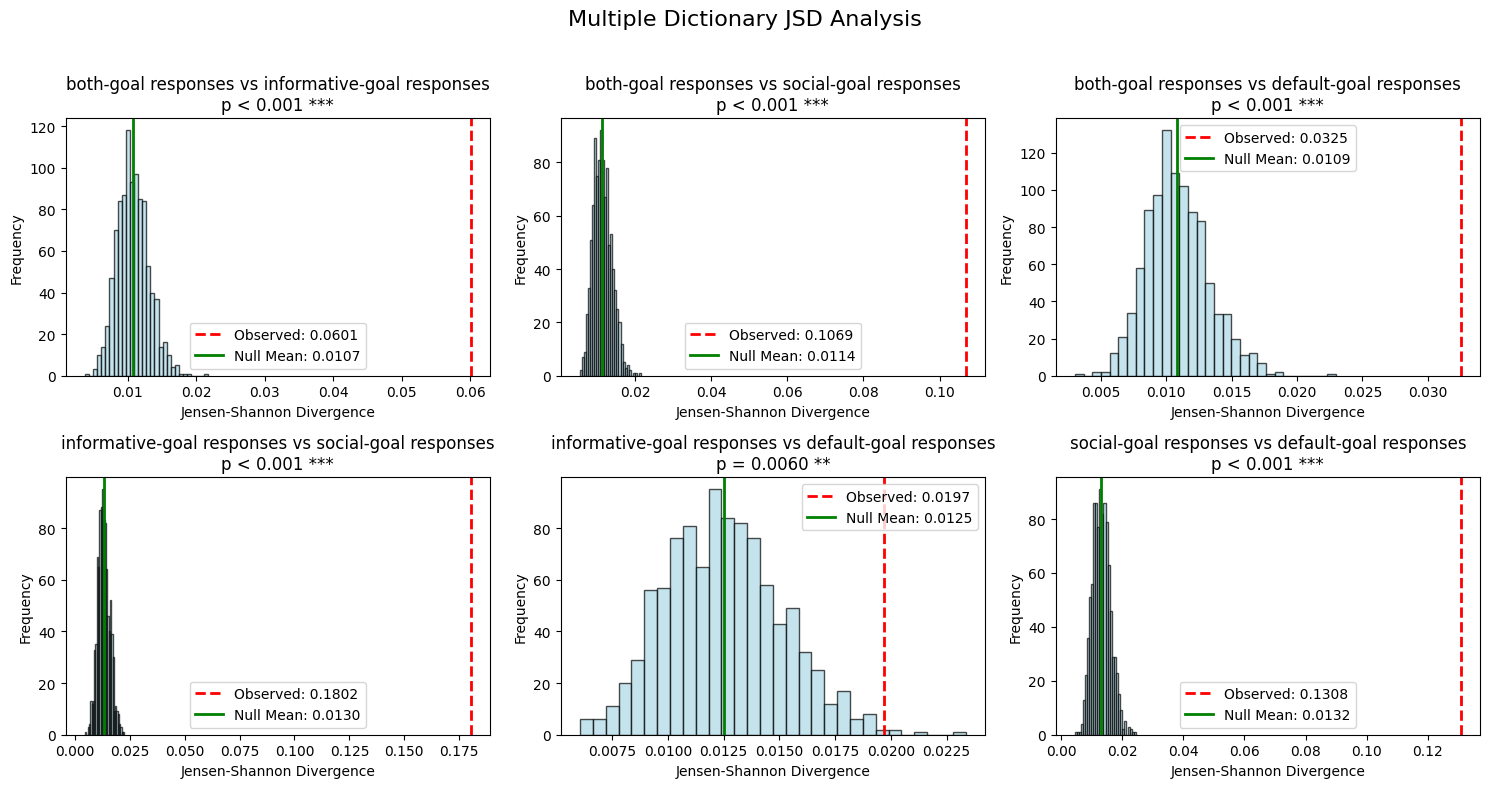

In [246]:


# Names for the dictionaries
names = ["both-goal responses", "informative-goal responses", "social-goal responses", "default-goal responses"]

# Create list of dictionaries
dict_list = [both_goal_responses_golden_politeness_strategies_freq, informative_goal_responses_golden_politeness_strategies_freq, social_goal_responses_golden_politeness_strategies_freq, default_goal_responses_golden_politeness_strategies_freq]

# Run the analysis
results = multi_dict_jsd_analysis(dict_list, names=names, n_permutations=1000, method = "resample")

# Generate report
create_multi_summary_report(dict_list, results, names=names)

# Create and save visualizations
jsd_matrix, matrix_names = create_jsd_matrix(dict_list, names=names)
matrix_fig = visualize_jsd_matrix(jsd_matrix, matrix_names)
#     matrix_fig.savefig("jsd_matrix.png")

results_fig = visualize_multi_results(results)
#     results_fig.savefig("multi_jsd_analysis.png")

print("Analysis complete! Visualizations and results have been saved.")

MULTIPLE DICTIONARY WORD FREQUENCY DISTRIBUTION COMPARISON REPORT

zero-rating responses Summary:
  Total words: 785
  Unique words: 35
  Most frequent: ('negative politeness-question, hedge', 121)

one-rating responses Summary:
  Total words: 944
  Unique words: 31
  Most frequent: ('negative politeness-question, hedge', 171)

two-rating responses Summary:
  Total words: 843
  Unique words: 22
  Most frequent: ('positive politeness-positive lexicon', 331)

three-rating responses Summary:
  Total words: 666
  Unique words: 22
  Most frequent: ('positive politeness-positive lexicon', 413)

Pairwise Comparisons:
  zero-rating responses vs one-rating responses:
    - JSD: 0.048840
    - p-value: 0.000000
  zero-rating responses vs two-rating responses:
    - JSD: 0.115306
    - p-value: 0.000000
  zero-rating responses vs three-rating responses:
    - JSD: 0.286011
    - p-value: 0.000000
  one-rating responses vs two-rating responses:
    - JSD: 0.078833
    - p-value: 0.000000
  one-rat

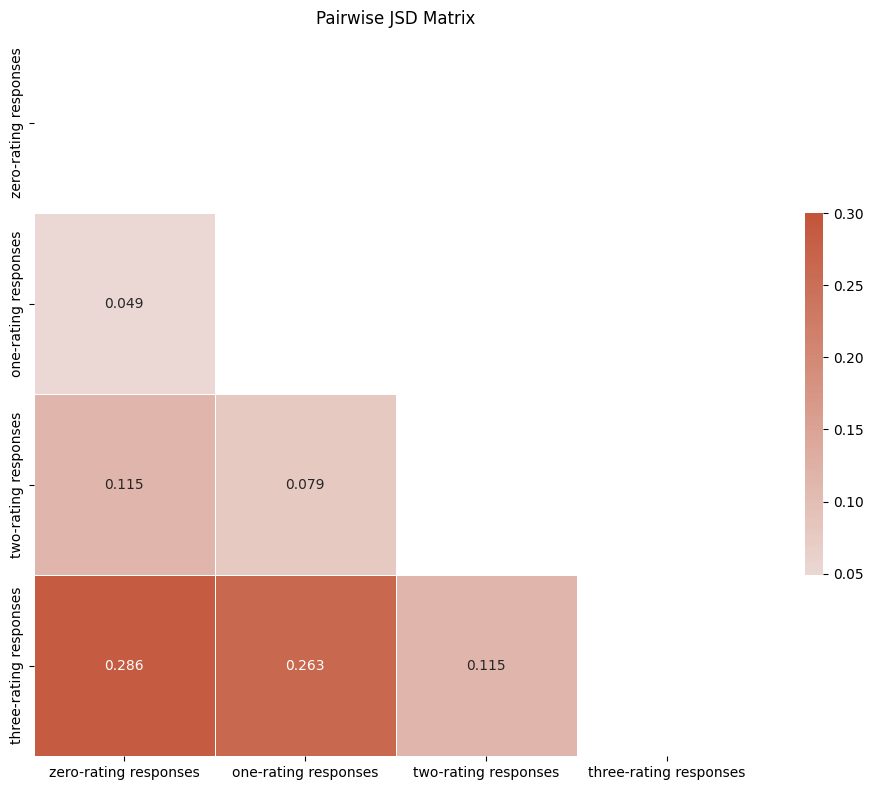

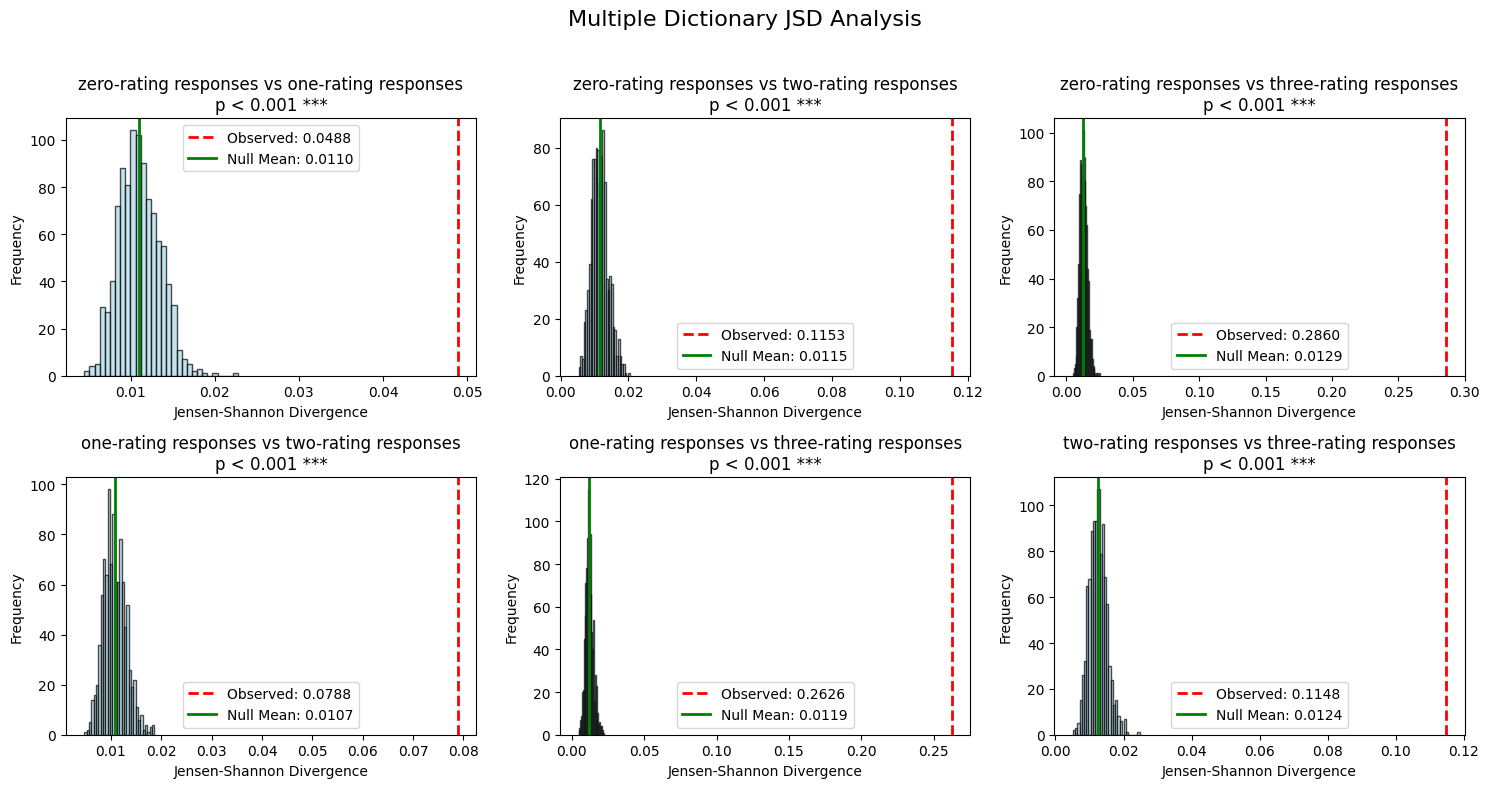

In [247]:


# Names for the dictionaries
names = ["zero-rating responses", "one-rating responses", "two-rating responses", "three-rating responses"]

# Create list of dictionaries
dict_list = [zero_rating_responses_golden_politeness_strategies_freq, one_rating_responses_golden_politeness_strategies_freq, two_rating_responses_golden_politeness_strategies_freq, three_rating_responses_golden_politeness_strategies_freq]

# Run the analysis
results = multi_dict_jsd_analysis(dict_list, names=names, n_permutations=1000, method = "resample")

# Generate report
create_multi_summary_report(dict_list, results, names=names)

# Create and save visualizations
jsd_matrix, matrix_names = create_jsd_matrix(dict_list, names=names)
matrix_fig = visualize_jsd_matrix(jsd_matrix, matrix_names)
#     matrix_fig.savefig("jsd_matrix.png")

results_fig = visualize_multi_results(results)
#     results_fig.savefig("multi_jsd_analysis.png")

print("Analysis complete! Visualizations and results have been saved.")

### Link back from open-ended responses to yoon & tessler multi-choice responses

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import pandas as pd
raw_all_responses = pd.read_csv("../../final_human_llm_raw_responses.csv")

raw_all_responses["rating"] = raw_all_responses["stimulus"].apply(get_rating)
raw_all_responses["goal"] = raw_all_responses["stimulus"].apply(get_goal)

# raw_all_responses.columns
# Index(['stimulus', 'claude_responses', 'gpt4o_responses', 'llama3_responses',
#        'responses_1', 'responses_2', 'responses_3', 'rating', 'goal'],
#       dtype='object')

pattern = r"\b(?:it's|its|it is|it was|it is not|it's not|its not|it isn't|it isnt|it was not|it wasnt|it wasn't|'s|is|was|is not|'s not|isn't|isnt|was not|wasn't|wasnt|not)\b(?:\s+\w+){0,2}?\s+(?:amazing|okay|bad|terrible|good|decent|nice|ok|awesome|alright|fantastic|perfect|fabulous|excellent|great|favorite|best|acceptable)\b"

# for columns claude_responses, gpt4o_responses, llama3_responses, responses_1, responses_2, responses_3, only keep the rows that match the pattern
claude_responses = raw_all_responses[raw_all_responses["claude_responses"].str.contains(pattern, na=False)]
claude_responses = claude_responses[["stimulus", "claude_responses", "rating", "goal"]]
claude_responses.reset_index(drop=True, inplace=True)

gpt4o_responses = raw_all_responses[raw_all_responses["gpt4o_responses"].str.contains(pattern, na=False)]
gpt4o_responses = gpt4o_responses[["stimulus", "gpt4o_responses", "rating", "goal"]]
gpt4o_responses.reset_index(drop=True, inplace=True)

llama3_responses = raw_all_responses[raw_all_responses["llama3_responses"].str.contains(pattern, na=False)]
llama3_responses = llama3_responses[["stimulus", "llama3_responses", "rating", "goal"]]
llama3_responses.reset_index(drop=True, inplace=True)

responses_1 = raw_all_responses[raw_all_responses["responses_1"].str.contains(pattern, na=False)]
responses_1 = responses_1[["stimulus", "responses_1", "rating", "goal"]]
responses_1.reset_index(drop=True, inplace=True)

responses_2 = raw_all_responses[raw_all_responses["responses_2"].str.contains(pattern, na=False)]
responses_2 = responses_2[["stimulus", "responses_2", "rating", "goal"]]
responses_2.reset_index(drop=True, inplace=True)

responses_3 = raw_all_responses[raw_all_responses["responses_3"].str.contains(pattern, na=False)]
responses_3 = responses_3[["stimulus", "responses_3", "rating", "goal"]]
responses_3.reset_index(drop=True, inplace=True)




In [11]:
all_responses_with_yoon_tessler = len(claude_responses) + len(gpt4o_responses) + len(llama3_responses) + len(responses_1) + len(responses_2) + len(responses_3)

all_responses_with_yoon_tessler

527

In [12]:
# get the rows where the rating is 0 or 1 and the goal is both or social
claude_responses_0_1_both_social = claude_responses[(claude_responses["rating"] <= 1) & (claude_responses["goal"].isin(["both", "social"]))]
gpt4o_responses_0_1_both_social = gpt4o_responses[(gpt4o_responses["rating"] <= 1) & (gpt4o_responses["goal"].isin(["both", "social"]))]
llama3_responses_0_1_both_social = llama3_responses[(llama3_responses["rating"] <= 1) & (llama3_responses["goal"].isin(["both", "social"]))]
responses_1_0_1_both_social = responses_1[(responses_1["rating"] <= 1) & (responses_1["goal"].isin(["both", "social"]))]
responses_2_0_1_both_social = responses_2[(responses_2["rating"] <= 1) & (responses_2["goal"].isin(["both", "social"]))]
responses_3_0_1_both_social = responses_3[(responses_3["rating"] <= 1) & (responses_3["goal"].isin(["both", "social"]))]

# get the rows where the rating is 0 or 1, regardless of the goal
claude_responses_0_1 = claude_responses[claude_responses["rating"] <= 1]
gpt4o_responses_0_1 = gpt4o_responses[gpt4o_responses["rating"] <= 1]
llama3_responses_0_1 = llama3_responses[llama3_responses["rating"] <= 1]
responses_1_0_1 = responses_1[responses_1["rating"] <= 1]
responses_2_0_1 = responses_2[responses_2["rating"] <= 1]
responses_3_0_1 = responses_3[responses_3["rating"] <= 1]

claude_responses_0_both = claude_responses[(claude_responses["rating"] == 0) & (claude_responses["goal"] == "both")]
gpt4o_responses_0_both = gpt4o_responses[(gpt4o_responses["rating"] == 0) & (gpt4o_responses["goal"] == "both")]
llama3_responses_0_both = llama3_responses[(llama3_responses["rating"] == 0) & (llama3_responses["goal"] == "both")]
responses_1_0_both = responses_1[(responses_1["rating"] == 0) & (responses_1["goal"] == "both")]
responses_2_0_both = responses_2[(responses_2["rating"] == 0) & (responses_2["goal"] == "both")]
responses_3_0_both = responses_3[(responses_3["rating"] == 0) & (responses_3["goal"] == "both")]

claude_responses_0_social = claude_responses[(claude_responses["rating"] == 0) & (claude_responses["goal"] == "social")]
gpt4o_responses_0_social = gpt4o_responses[(gpt4o_responses["rating"] == 0) & (gpt4o_responses["goal"] == "social")]
llama3_responses_0_social = llama3_responses[(llama3_responses["rating"] == 0) & (llama3_responses["goal"] == "social")]
responses_1_0_social = responses_1[(responses_1["rating"] == 0) & (responses_1["goal"] == "social")]
responses_2_0_social = responses_2[(responses_2["rating"] == 0) & (responses_2["goal"] == "social")]
responses_3_0_social = responses_3[(responses_3["rating"] == 0) & (responses_3["goal"] == "social")]

claude_responses_0_informative = claude_responses[(claude_responses["rating"] == 0) & (claude_responses["goal"] == "informative")]
gpt4o_responses_0_informative = gpt4o_responses[(gpt4o_responses["rating"] == 0) & (gpt4o_responses["goal"] == "informative")]
llama3_responses_0_informative = llama3_responses[(llama3_responses["rating"] == 0) & (llama3_responses["goal"] == "informative")]
responses_1_0_informative = responses_1[(responses_1["rating"] == 0) & (responses_1["goal"] == "informative")]
responses_2_0_informative = responses_2[(responses_2["rating"] == 0) & (responses_2["goal"] == "informative")]
responses_3_0_informative = responses_3[(responses_3["rating"] == 0) & (responses_3["goal"] == "informative")]

claude_responses_0_default = claude_responses[(claude_responses["rating"] == 0) & (claude_responses["goal"] == "default")]
gpt4o_responses_0_default = gpt4o_responses[(gpt4o_responses["rating"] == 0) & (gpt4o_responses["goal"] == "default")]
llama3_responses_0_default = llama3_responses[(llama3_responses["rating"] == 0) & (llama3_responses["goal"] == "default")]
responses_1_0_default = responses_1[(responses_1["rating"] == 0) & (responses_1["goal"] == "default")]
responses_2_0_default = responses_2[(responses_2["rating"] == 0) & (responses_2["goal"] == "default")]
responses_3_0_default = responses_3[(responses_3["rating"] == 0) & (responses_3["goal"] == "default")]

claude_responses_1_both = claude_responses[(claude_responses["rating"] == 1) & (claude_responses["goal"] == "both")]
gpt4o_responses_1_both = gpt4o_responses[(gpt4o_responses["rating"] == 1) & (gpt4o_responses["goal"] == "both")]
llama3_responses_1_both = llama3_responses[(llama3_responses["rating"] == 1) & (llama3_responses["goal"] == "both")]
responses_1_1_both = responses_1[(responses_1["rating"] == 1) & (responses_1["goal"] == "both")]
responses_2_1_both = responses_2[(responses_2["rating"] == 1) & (responses_2["goal"] == "both")]
responses_3_1_both = responses_3[(responses_3["rating"] == 1) & (responses_3["goal"] == "both")]

claude_responses_1_social = claude_responses[(claude_responses["rating"] == 1) & (claude_responses["goal"] == "social")]
gpt4o_responses_1_social = gpt4o_responses[(gpt4o_responses["rating"] == 1) & (gpt4o_responses["goal"] == "social")]
llama3_responses_1_social = llama3_responses[(llama3_responses["rating"] == 1) & (llama3_responses["goal"] == "social")]
responses_1_1_social = responses_1[(responses_1["rating"] == 1) & (responses_1["goal"] == "social")]
responses_2_1_social = responses_2[(responses_2["rating"] == 1) & (responses_2["goal"] == "social")]
responses_3_1_social = responses_3[(responses_3["rating"] == 1) & (responses_3["goal"] == "social")]

claude_responses_1_informative = claude_responses[(claude_responses["rating"] == 1) & (claude_responses["goal"] == "informative")]
gpt4o_responses_1_informative = gpt4o_responses[(gpt4o_responses["rating"] == 1) & (gpt4o_responses["goal"] == "informative")]
llama3_responses_1_informative = llama3_responses[(llama3_responses["rating"] == 1) & (llama3_responses["goal"] == "informative")]
responses_1_1_informative = responses_1[(responses_1["rating"] == 1) & (responses_1["goal"] == "informative")]
responses_2_1_informative = responses_2[(responses_2["rating"] == 1) & (responses_2["goal"] == "informative")]
responses_3_1_informative = responses_3[(responses_3["rating"] == 1) & (responses_3["goal"] == "informative")]

claude_responses_1_default = claude_responses[(claude_responses["rating"] == 1) & (claude_responses["goal"] == "default")]
gpt4o_responses_1_default = gpt4o_responses[(gpt4o_responses["rating"] == 1) & (gpt4o_responses["goal"] == "default")]
llama3_responses_1_default = llama3_responses[(llama3_responses["rating"] == 1) & (llama3_responses["goal"] == "default")]
responses_1_1_default = responses_1[(responses_1["rating"] == 1) & (responses_1["goal"] == "default")]
responses_2_1_default = responses_2[(responses_2["rating"] == 1) & (responses_2["goal"] == "default")]
responses_3_1_default = responses_3[(responses_3["rating"] == 1) & (responses_3["goal"] == "default")]

claude_responses_2_both = claude_responses[(claude_responses["rating"] == 2) & (claude_responses["goal"] == "both")]
gpt4o_responses_2_both = gpt4o_responses[(gpt4o_responses["rating"] == 2) & (gpt4o_responses["goal"] == "both")]
llama3_responses_2_both = llama3_responses[(llama3_responses["rating"] == 2) & (llama3_responses["goal"] == "both")]
responses_1_2_both = responses_1[(responses_1["rating"] == 2) & (responses_1["goal"] == "both")]
responses_2_2_both = responses_2[(responses_2["rating"] == 2) & (responses_2["goal"] == "both")]
responses_3_2_both = responses_3[(responses_3["rating"] == 2) & (responses_3["goal"] == "both")]

claude_responses_2_social = claude_responses[(claude_responses["rating"] == 2) & (claude_responses["goal"] == "social")]
gpt4o_responses_2_social = gpt4o_responses[(gpt4o_responses["rating"] == 2) & (gpt4o_responses["goal"] == "social")]
llama3_responses_2_social = llama3_responses[(llama3_responses["rating"] == 2) & (llama3_responses["goal"] == "social")]
responses_1_2_social = responses_1[(responses_1["rating"] == 2) & (responses_1["goal"] == "social")]
responses_2_2_social = responses_2[(responses_2["rating"] == 2) & (responses_2["goal"] == "social")]
responses_3_2_social = responses_3[(responses_3["rating"] == 2) & (responses_3["goal"] == "social")]

claude_responses_2_informative = claude_responses[(claude_responses["rating"] == 2) & (claude_responses["goal"] == "informative")]
gpt4o_responses_2_informative = gpt4o_responses[(gpt4o_responses["rating"] == 2) & (gpt4o_responses["goal"] == "informative")]
llama3_responses_2_informative = llama3_responses[(llama3_responses["rating"] == 2) & (llama3_responses["goal"] == "informative")]
responses_1_2_informative = responses_1[(responses_1["rating"] == 2) & (responses_1["goal"] == "informative")]
responses_2_2_informative = responses_2[(responses_2["rating"] == 2) & (responses_2["goal"] == "informative")]
responses_3_2_informative = responses_3[(responses_3["rating"] == 2) & (responses_3["goal"] == "informative")]

claude_responses_2_default = claude_responses[(claude_responses["rating"] == 2) & (claude_responses["goal"] == "default")]
gpt4o_responses_2_default = gpt4o_responses[(gpt4o_responses["rating"] == 2) & (gpt4o_responses["goal"] == "default")]
llama3_responses_2_default = llama3_responses[(llama3_responses["rating"] == 2) & (llama3_responses["goal"] == "default")]
responses_1_2_default = responses_1[(responses_1["rating"] == 2) & (responses_1["goal"] == "default")]
responses_2_2_default = responses_2[(responses_2["rating"] == 2) & (responses_2["goal"] == "default")]
responses_3_2_default = responses_3[(responses_3["rating"] == 2) & (responses_3["goal"] == "default")]

claude_responses_3_both = claude_responses[(claude_responses["rating"] == 3) & (claude_responses["goal"] == "both")]
gpt4o_responses_3_both = gpt4o_responses[(gpt4o_responses["rating"] == 3) & (gpt4o_responses["goal"] == "both")]
llama3_responses_3_both = llama3_responses[(llama3_responses["rating"] == 3) & (llama3_responses["goal"] == "both")]
responses_1_3_both = responses_1[(responses_1["rating"] == 3) & (responses_1["goal"] == "both")]
responses_2_3_both = responses_2[(responses_2["rating"] == 3) & (responses_2["goal"] == "both")]
responses_3_3_both = responses_3[(responses_3["rating"] == 3) & (responses_3["goal"] == "both")]

claude_responses_3_social = claude_responses[(claude_responses["rating"] == 3) & (claude_responses["goal"] == "social")]
gpt4o_responses_3_social = gpt4o_responses[(gpt4o_responses["rating"] == 3) & (gpt4o_responses["goal"] == "social")]
llama3_responses_3_social = llama3_responses[(llama3_responses["rating"] == 3) & (llama3_responses["goal"] == "social")]
responses_1_3_social = responses_1[(responses_1["rating"] == 3) & (responses_1["goal"] == "social")]
responses_2_3_social = responses_2[(responses_2["rating"] == 3) & (responses_2["goal"] == "social")]
responses_3_3_social = responses_3[(responses_3["rating"] == 3) & (responses_3["goal"] == "social")]

claude_responses_3_informative = claude_responses[(claude_responses["rating"] == 3) & (claude_responses["goal"] == "informative")]
gpt4o_responses_3_informative = gpt4o_responses[(gpt4o_responses["rating"] == 3) & (gpt4o_responses["goal"] == "informative")]
llama3_responses_3_informative = llama3_responses[(llama3_responses["rating"] == 3) & (llama3_responses["goal"] == "informative")]
responses_1_3_informative = responses_1[(responses_1["rating"] == 3) & (responses_1["goal"] == "informative")]
responses_2_3_informative = responses_2[(responses_2["rating"] == 3) & (responses_2["goal"] == "informative")]
responses_3_3_informative = responses_3[(responses_3["rating"] == 3) & (responses_3["goal"] == "informative")]

claude_responses_3_default = claude_responses[(claude_responses["rating"] == 3) & (claude_responses["goal"] == "default")]
gpt4o_responses_3_default = gpt4o_responses[(gpt4o_responses["rating"] == 3) & (gpt4o_responses["goal"] == "default")]
llama3_responses_3_default = llama3_responses[(llama3_responses["rating"] == 3) & (llama3_responses["goal"] == "default")]
responses_1_3_default = responses_1[(responses_1["rating"] == 3) & (responses_1["goal"] == "default")]
responses_2_3_default = responses_2[(responses_2["rating"] == 3) & (responses_2["goal"] == "default")]
responses_3_3_default = responses_3[(responses_3["rating"] == 3) & (responses_3["goal"] == "default")]

In [13]:
number_of_0_1_both_social_responses = len(claude_responses_0_1_both_social) + len(gpt4o_responses_0_1_both_social) + len(llama3_responses_0_1_both_social) + len(responses_1_0_1_both_social) + len(responses_2_0_1_both_social) + len(responses_3_0_1_both_social)
number_of_0_1_responses = len(claude_responses_0_1) + len(gpt4o_responses_0_1) + len(llama3_responses_0_1) + len(responses_1_0_1) + len(responses_2_0_1) + len(responses_3_0_1)

number_of_0_both = len(claude_responses_0_both) + len(gpt4o_responses_0_both) + len(llama3_responses_0_both) + len(responses_1_0_both) + len(responses_2_0_both) + len(responses_3_0_both)
number_of_0_social = len(claude_responses_0_social) + len(gpt4o_responses_0_social) + len(llama3_responses_0_social) + len(responses_1_0_social) + len(responses_2_0_social) + len(responses_3_0_social)
number_of_0_informative = len(claude_responses_0_informative) + len(gpt4o_responses_0_informative) + len(llama3_responses_0_informative) + len(responses_1_0_informative) + len(responses_2_0_informative) + len(responses_3_0_informative)
number_of_0_default = len(claude_responses_0_default) + len(gpt4o_responses_0_default) + len(llama3_responses_0_default) + len(responses_1_0_default) + len(responses_2_0_default) + len(responses_3_0_default)

number_of_1_both = len(claude_responses_1_both) + len(gpt4o_responses_1_both) + len(llama3_responses_1_both) + len(responses_1_1_both) + len(responses_2_1_both) + len(responses_3_1_both)
number_of_1_social = len(claude_responses_1_social) + len(gpt4o_responses_1_social) + len(llama3_responses_1_social) + len(responses_1_1_social) + len(responses_2_1_social) + len(responses_3_1_social)
number_of_1_informative = len(claude_responses_1_informative) + len(gpt4o_responses_1_informative) + len(llama3_responses_1_informative) + len(responses_1_1_informative) + len(responses_2_1_informative) + len(responses_3_1_informative)
number_of_1_default = len(claude_responses_1_default) + len(gpt4o_responses_1_default) + len(llama3_responses_1_default) + len(responses_1_1_default) + len(responses_2_1_default) + len(responses_3_1_default)

number_of_2_both = len(claude_responses_2_both) + len(gpt4o_responses_2_both) + len(llama3_responses_2_both) + len(responses_1_2_both) + len(responses_2_2_both) + len(responses_3_2_both)
number_of_2_social = len(claude_responses_2_social) + len(gpt4o_responses_2_social) + len(llama3_responses_2_social) + len(responses_1_2_social) + len(responses_2_2_social) + len(responses_3_2_social)
number_of_2_informative = len(claude_responses_2_informative) + len(gpt4o_responses_2_informative) + len(llama3_responses_2_informative) + len(responses_1_2_informative) + len(responses_2_2_informative) + len(responses_3_2_informative)
number_of_2_default = len(claude_responses_2_default) + len(gpt4o_responses_2_default) + len(llama3_responses_2_default) + len(responses_1_2_default) + len(responses_2_2_default) + len(responses_3_2_default)

number_of_3_both = len(claude_responses_3_both) + len(gpt4o_responses_3_both) + len(llama3_responses_3_both) + len(responses_1_3_both) + len(responses_2_3_both) + len(responses_3_3_both)
number_of_3_social = len(claude_responses_3_social) + len(gpt4o_responses_3_social) + len(llama3_responses_3_social) + len(responses_1_3_social) + len(responses_2_3_social) + len(responses_3_3_social)
number_of_3_informative = len(claude_responses_3_informative) + len(gpt4o_responses_3_informative) + len(llama3_responses_3_informative) + len(responses_1_3_informative) + len(responses_2_3_informative) + len(responses_3_3_informative)
number_of_3_default = len(claude_responses_3_default) + len(gpt4o_responses_3_default) + len(llama3_responses_3_default) + len(responses_1_3_default) + len(responses_2_3_default) + len(responses_3_3_default)

number_of_0_both, number_of_0_social, number_of_0_informative, number_of_0_default, number_of_1_both, number_of_1_social, number_of_1_informative, number_of_1_default, number_of_2_both, number_of_2_social, number_of_2_informative, number_of_2_default, number_of_3_both, number_of_3_social, number_of_3_informative, number_of_3_default

(14, 20, 13, 11, 21, 44, 18, 45, 43, 37, 48, 45, 48, 43, 39, 38)

In [14]:

# for all the dataframe above, analyze under 0 or 1 rating, both or social goal condition, how often the responses use the negation
# I will get the count and the percentage of the negation responses under each group and overall

# # for all the dataframe above, how often the responses use the negation
# I will get the count and the percentage of the negation responses under each group and overall

# negation_pattern = r"\b((?:it is not|it's not|it’s not|its not|aint|ain't||ain’t|it isn't|it isn’t|it isnt|it was not|it wasnt|it wasn't|it wasn’t|is not|'s not|’s not|isn't|isn’t|isnt|was not|wasn't|wasn’t|wasnt|not)(?:\s+\w+){0,2}?\s+(?:amazing|okay|bad|terrible|good|decent|nice|ok|awesome|alright|fantastic|perfect|excellent|great|favorite|best|acceptable))\b"
negation_pattern = r"\b((?:it is not|it's not|its not|it isn't|it isnt|it was not|it wasnt|it wasn't|is not|'s not|isn't|isnt|was not|wasn't|wasnt|not)(?:\s+\w+){0,2}?\s+(?:amazing|okay|bad|terrible|good|decent|nice|ok|awesome|alright|fantastic|perfect|excellent|great|favorite|best|fabulous|acceptable))\b"

# for columns claude_responses, gpt4o_responses, llama3_responses, responses_1, responses_2, responses_3, only keep the rows that match the pattern
claude_negation_responses = claude_responses[claude_responses["claude_responses"].str.contains(negation_pattern, na=False)]
# reset the index
claude_negation_responses.reset_index(drop=True, inplace=True)

gpt4o_negation_responses = gpt4o_responses[gpt4o_responses["gpt4o_responses"].str.contains(negation_pattern, na=False)]
gpt4o_negation_responses.reset_index(drop=True, inplace=True)

llama3_negation_responses = llama3_responses[llama3_responses["llama3_responses"].str.contains(negation_pattern, na=False)]
llama3_negation_responses.reset_index(drop=True, inplace=True)

responses_1_negation_responses = responses_1[responses_1["responses_1"].str.contains(negation_pattern, na=False)]
responses_1_negation_responses.reset_index(drop=True, inplace=True)

responses_2_negation_responses = responses_2[responses_2["responses_2"].str.contains(negation_pattern, na=False)]
responses_2_negation_responses.reset_index(drop=True, inplace=True)

responses_3_negation_responses = responses_3[responses_3["responses_3"].str.contains(negation_pattern, na=False)]
responses_3_negation_responses.reset_index(drop=True, inplace=True)


/var/folders/rd/r290740569q845dpgz6y3r840000gn/T/ipykernel_52062/4267133314.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  claude_negation_responses = claude_responses[claude_responses["claude_responses"].str.contains(negation_pattern, na=False)]
/var/folders/rd/r290740569q845dpgz6y3r840000gn/T/ipykernel_52062/4267133314.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  gpt4o_negation_responses = gpt4o_responses[gpt4o_responses["gpt4o_responses"].str.contains(negation_pattern, na=False)]
/var/folders/rd/r290740569q845dpgz6y3r840000gn/T/ipykernel_52062/4267133314.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  llama3_negation_responses = llama3_responses[llama3_responses["llama3_responses"].str.contains(negatio

In [15]:
the_number_of_all_negation_responses = len(claude_negation_responses) + len(gpt4o_negation_responses) + len(llama3_negation_responses) + len(responses_1_negation_responses) + len(responses_2_negation_responses) + len(responses_3_negation_responses)

(the_number_of_all_negation_responses / all_responses_with_yoon_tessler) * 100, the_number_of_all_negation_responses, all_responses_with_yoon_tessler


(6.641366223908918, 35, 527)

In [16]:
# get the rows where the rating is 0 or 1 and the goal is both or social
claude_negation_responses_0_1_both_social = claude_negation_responses[(claude_negation_responses["rating"] <= 1) & (claude_negation_responses["goal"].isin(["both", "social"]))]

gpt4o_negation_responses_0_1_both_social = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] <= 1) & (gpt4o_negation_responses["goal"].isin(["both", "social"]))]

llama3_negation_responses_0_1_both_social = llama3_negation_responses[(llama3_negation_responses["rating"] <= 1) & (llama3_negation_responses["goal"].isin(["both", "social"]))]

responses_1_negation_responses_0_1_both_social = responses_1_negation_responses[(responses_1_negation_responses["rating"] <= 1) & (responses_1_negation_responses["goal"].isin(["both", "social"]))]

responses_2_negation_responses_0_1_both_social = responses_2_negation_responses[(responses_2_negation_responses["rating"] <= 1) & (responses_2_negation_responses["goal"].isin(["both", "social"]))]

responses_3_negation_responses_0_1_both_social = responses_3_negation_responses[(responses_3_negation_responses["rating"] <= 1) & (responses_3_negation_responses["goal"].isin(["both", "social"]))]

# now only get the rows where the rating is 0 or 1 regardless of the rating
claude_negation_responses_0_1 = claude_negation_responses[claude_negation_responses["rating"] <= 1]
gpt4o_negation_responses_0_1 = gpt4o_negation_responses[gpt4o_negation_responses["rating"] <= 1]
llama3_negation_responses_0_1 = llama3_negation_responses[llama3_negation_responses["rating"] <= 1]
responses_1_negation_responses_0_1 = responses_1_negation_responses[responses_1_negation_responses["rating"] <= 1]
responses_2_negation_responses_0_1 = responses_2_negation_responses[responses_2_negation_responses["rating"] <= 1]
responses_3_negation_responses_0_1 = responses_3_negation_responses[responses_3_negation_responses["rating"] <= 1]

claude_negation_responses_0_both = claude_negation_responses[(claude_negation_responses["rating"] == 0) & (claude_negation_responses["goal"] == "both")]
gpt4o_negation_responses_0_both = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 0) & (gpt4o_negation_responses["goal"] == "both")]
llama3_negation_responses_0_both = llama3_negation_responses[(llama3_negation_responses["rating"] == 0) & (llama3_negation_responses["goal"] == "both")]
responses_1_negation_responses_0_both = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 0) & (responses_1_negation_responses["goal"] == "both")]
responses_2_negation_responses_0_both = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 0) & (responses_2_negation_responses["goal"] == "both")]
responses_3_negation_responses_0_both = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 0) & (responses_3_negation_responses["goal"] == "both")]

claude_negation_responses_0_social = claude_negation_responses[(claude_negation_responses["rating"] == 0) & (claude_negation_responses["goal"] == "social")]
gpt4o_negation_responses_0_social = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 0) & (gpt4o_negation_responses["goal"] == "social")]
llama3_negation_responses_0_social = llama3_negation_responses[(llama3_negation_responses["rating"] == 0) & (llama3_negation_responses["goal"] == "social")]
responses_1_negation_responses_0_social = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 0) & (responses_1_negation_responses["goal"] == "social")]
responses_2_negation_responses_0_social = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 0) & (responses_2_negation_responses["goal"] == "social")]
responses_3_negation_responses_0_social = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 0) & (responses_3_negation_responses["goal"] == "social")]

claude_negation_responses_0_informative = claude_negation_responses[(claude_negation_responses["rating"] == 0) & (claude_negation_responses["goal"] == "informative")]
gpt4o_negation_responses_0_informative = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 0) & (gpt4o_negation_responses["goal"] == "informative")]
llama3_negation_responses_0_informative = llama3_negation_responses[(llama3_negation_responses["rating"] == 0) & (llama3_negation_responses["goal"] == "informative")]
responses_1_negation_responses_0_informative = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 0) & (responses_1_negation_responses["goal"] == "informative")]
responses_2_negation_responses_0_informative = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 0) & (responses_2_negation_responses["goal"] == "informative")]
responses_3_negation_responses_0_informative = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 0) & (responses_3_negation_responses["goal"] == "informative")]

claude_negation_responses_0_default = claude_negation_responses[(claude_negation_responses["rating"] == 0) & (claude_negation_responses["goal"] == "default")]
gpt4o_negation_responses_0_default = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 0) & (gpt4o_negation_responses["goal"] == "default")]
llama3_negation_responses_0_default = llama3_negation_responses[(llama3_negation_responses["rating"] == 0) & (llama3_negation_responses["goal"] == "default")]
responses_1_negation_responses_0_default = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 0) & (responses_1_negation_responses["goal"] == "default")]
responses_2_negation_responses_0_default = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 0) & (responses_2_negation_responses["goal"] == "default")]
responses_3_negation_responses_0_default = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 0) & (responses_3_negation_responses["goal"] == "default")]

claude_negation_responses_1_both = claude_negation_responses[(claude_negation_responses["rating"] == 1) & (claude_negation_responses["goal"] == "both")]
gpt4o_negation_responses_1_both = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 1) & (gpt4o_negation_responses["goal"] == "both")]
llama3_negation_responses_1_both = llama3_negation_responses[(llama3_negation_responses["rating"] == 1) & (llama3_negation_responses["goal"] == "both")]
responses_1_negation_responses_1_both = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 1) & (responses_1_negation_responses["goal"] == "both")]
responses_2_negation_responses_1_both = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 1) & (responses_2_negation_responses["goal"] == "both")]
responses_3_negation_responses_1_both = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 1) & (responses_3_negation_responses["goal"] == "both")]

claude_negation_responses_1_social = claude_negation_responses[(claude_negation_responses["rating"] == 1) & (claude_negation_responses["goal"] == "social")]
gpt4o_negation_responses_1_social = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 1) & (gpt4o_negation_responses["goal"] == "social")]
llama3_negation_responses_1_social = llama3_negation_responses[(llama3_negation_responses["rating"] == 1) & (llama3_negation_responses["goal"] == "social")]
responses_1_negation_responses_1_social = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 1) & (responses_1_negation_responses["goal"] == "social")]
responses_2_negation_responses_1_social = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 1) & (responses_2_negation_responses["goal"] == "social")]
responses_3_negation_responses_1_social = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 1) & (responses_3_negation_responses["goal"] == "social")]

claude_negation_responses_1_informative = claude_negation_responses[(claude_negation_responses["rating"] == 1) & (claude_negation_responses["goal"] == "informative")]
gpt4o_negation_responses_1_informative = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 1) & (gpt4o_negation_responses["goal"] == "informative")]
llama3_negation_responses_1_informative = llama3_negation_responses[(llama3_negation_responses["rating"] == 1) & (llama3_negation_responses["goal"] == "informative")]
responses_1_negation_responses_1_informative = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 1) & (responses_1_negation_responses["goal"] == "informative")]
responses_2_negation_responses_1_informative = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 1) & (responses_2_negation_responses["goal"] == "informative")]
responses_3_negation_responses_1_informative = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 1) & (responses_3_negation_responses["goal"] == "informative")]

claude_negation_responses_1_default = claude_negation_responses[(claude_negation_responses["rating"] == 1) & (claude_negation_responses["goal"] == "default")]
gpt4o_negation_responses_1_default = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 1) & (gpt4o_negation_responses["goal"] == "default")]
llama3_negation_responses_1_default = llama3_negation_responses[(llama3_negation_responses["rating"] == 1) & (llama3_negation_responses["goal"] == "default")]
responses_1_negation_responses_1_default = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 1) & (responses_1_negation_responses["goal"] == "default")]
responses_2_negation_responses_1_default = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 1) & (responses_2_negation_responses["goal"] == "default")]
responses_3_negation_responses_1_default = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 1) & (responses_3_negation_responses["goal"] == "default")]

claude_negation_responses_2_both = claude_negation_responses[(claude_negation_responses["rating"] == 2) & (claude_negation_responses["goal"] == "both")]
gpt4o_negation_responses_2_both = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 2) & (gpt4o_negation_responses["goal"] == "both")]
llama3_negation_responses_2_both = llama3_negation_responses[(llama3_negation_responses["rating"] == 2) & (llama3_negation_responses["goal"] == "both")]
responses_1_negation_responses_2_both = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 2) & (responses_1_negation_responses["goal"] == "both")]
responses_2_negation_responses_2_both = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 2) & (responses_2_negation_responses["goal"] == "both")]
responses_3_negation_responses_2_both = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 2) & (responses_3_negation_responses["goal"] == "both")]

claude_negation_responses_2_social = claude_negation_responses[(claude_negation_responses["rating"] == 2) & (claude_negation_responses["goal"] == "social")]
gpt4o_negation_responses_2_social = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 2) & (gpt4o_negation_responses["goal"] == "social")]
llama3_negation_responses_2_social = llama3_negation_responses[(llama3_negation_responses["rating"] == 2) & (llama3_negation_responses["goal"] == "social")]
responses_1_negation_responses_2_social = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 2) & (responses_1_negation_responses["goal"] == "social")]
responses_2_negation_responses_2_social = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 2) & (responses_2_negation_responses["goal"] == "social")]
responses_3_negation_responses_2_social = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 2) & (responses_3_negation_responses["goal"] == "social")]

claude_negation_responses_2_informative = claude_negation_responses[(claude_negation_responses["rating"] == 2) & (claude_negation_responses["goal"] == "informative")]
gpt4o_negation_responses_2_informative = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 2) & (gpt4o_negation_responses["goal"] == "informative")]
llama3_negation_responses_2_informative = llama3_negation_responses[(llama3_negation_responses["rating"] == 2) & (llama3_negation_responses["goal"] == "informative")]
responses_1_negation_responses_2_informative = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 2) & (responses_1_negation_responses["goal"] == "informative")]
responses_2_negation_responses_2_informative = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 2) & (responses_2_negation_responses["goal"] == "informative")]
responses_3_negation_responses_2_informative = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 2) & (responses_3_negation_responses["goal"] == "informative")]

claude_negation_responses_2_default = claude_negation_responses[(claude_negation_responses["rating"] == 2) & (claude_negation_responses["goal"] == "default")]
gpt4o_negation_responses_2_default = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 2) & (gpt4o_negation_responses["goal"] == "default")]
llama3_negation_responses_2_default = llama3_negation_responses[(llama3_negation_responses["rating"] == 2) & (llama3_negation_responses["goal"] == "default")]
responses_1_negation_responses_2_default = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 2) & (responses_1_negation_responses["goal"] == "default")]
responses_2_negation_responses_2_default = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 2) & (responses_2_negation_responses["goal"] == "default")]
responses_3_negation_responses_2_default = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 2) & (responses_3_negation_responses["goal"] == "default")]

claude_negation_responses_3_both = claude_negation_responses[(claude_negation_responses["rating"] == 3) & (claude_negation_responses["goal"] == "both")]
gpt4o_negation_responses_3_both = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 3) & (gpt4o_negation_responses["goal"] == "both")]
llama3_negation_responses_3_both = llama3_negation_responses[(llama3_negation_responses["rating"] == 3) & (llama3_negation_responses["goal"] == "both")]
responses_1_negation_responses_3_both = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 3) & (responses_1_negation_responses["goal"] == "both")]
responses_2_negation_responses_3_both = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 3) & (responses_2_negation_responses["goal"] == "both")]
responses_3_negation_responses_3_both = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 3) & (responses_3_negation_responses["goal"] == "both")]

claude_negation_responses_3_social = claude_negation_responses[(claude_negation_responses["rating"] == 3) & (claude_negation_responses["goal"] == "social")]
gpt4o_negation_responses_3_social = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 3) & (gpt4o_negation_responses["goal"] == "social")]
llama3_negation_responses_3_social = llama3_negation_responses[(llama3_negation_responses["rating"] == 3) & (llama3_negation_responses["goal"] == "social")]
responses_1_negation_responses_3_social = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 3) & (responses_1_negation_responses["goal"] == "social")]
responses_2_negation_responses_3_social = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 3) & (responses_2_negation_responses["goal"] == "social")]
responses_3_negation_responses_3_social = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 3) & (responses_3_negation_responses["goal"] == "social")]

claude_negation_responses_3_informative = claude_negation_responses[(claude_negation_responses["rating"] == 3) & (claude_negation_responses["goal"] == "informative")]
gpt4o_negation_responses_3_informative = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 3) & (gpt4o_negation_responses["goal"] == "informative")]
llama3_negation_responses_3_informative = llama3_negation_responses[(llama3_negation_responses["rating"] == 3) & (llama3_negation_responses["goal"] == "informative")]
responses_1_negation_responses_3_informative = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 3) & (responses_1_negation_responses["goal"] == "informative")]
responses_2_negation_responses_3_informative = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 3) & (responses_2_negation_responses["goal"] == "informative")]
responses_3_negation_responses_3_informative = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 3) & (responses_3_negation_responses["goal"] == "informative")]

claude_negation_responses_3_default = claude_negation_responses[(claude_negation_responses["rating"] == 3) & (claude_negation_responses["goal"] == "default")]
gpt4o_negation_responses_3_default = gpt4o_negation_responses[(gpt4o_negation_responses["rating"] == 3) & (gpt4o_negation_responses["goal"] == "default")]
llama3_negation_responses_3_default = llama3_negation_responses[(llama3_negation_responses["rating"] == 3) & (llama3_negation_responses["goal"] == "default")]
responses_1_negation_responses_3_default = responses_1_negation_responses[(responses_1_negation_responses["rating"] == 3) & (responses_1_negation_responses["goal"] == "default")]
responses_2_negation_responses_3_default = responses_2_negation_responses[(responses_2_negation_responses["rating"] == 3) & (responses_2_negation_responses["goal"] == "default")]
responses_3_negation_responses_3_default = responses_3_negation_responses[(responses_3_negation_responses["rating"] == 3) & (responses_3_negation_responses["goal"] == "default")]

In [17]:
number_of_0_1_both_social_negation_responses = len(claude_negation_responses_0_1_both_social) + len(gpt4o_negation_responses_0_1_both_social) + len(llama3_negation_responses_0_1_both_social) + len(responses_1_negation_responses_0_1_both_social) + len(responses_2_negation_responses_0_1_both_social) + len(responses_3_negation_responses_0_1_both_social)
number_of_0_1_negation_responses = len(claude_negation_responses_0_1) + len(gpt4o_negation_responses_0_1) + len(llama3_negation_responses_0_1) + len(responses_1_negation_responses_0_1) + len(responses_2_negation_responses_0_1) + len(responses_3_negation_responses_0_1)

number_of_0_both_negation_responses = len(claude_negation_responses_0_both) + len(gpt4o_negation_responses_0_both) + len(llama3_negation_responses_0_both) + len(responses_1_negation_responses_0_both) + len(responses_2_negation_responses_0_both) + len(responses_3_negation_responses_0_both)
number_of_0_social_negation_responses = len(claude_negation_responses_0_social) + len(gpt4o_negation_responses_0_social) + len(llama3_negation_responses_0_social) + len(responses_1_negation_responses_0_social) + len(responses_2_negation_responses_0_social) + len(responses_3_negation_responses_0_social)
number_of_0_informative_negation_responses = len(claude_negation_responses_0_informative) + len(gpt4o_negation_responses_0_informative) + len(llama3_negation_responses_0_informative) + len(responses_1_negation_responses_0_informative) + len(responses_2_negation_responses_0_informative) + len(responses_3_negation_responses_0_informative)
number_of_0_default_negation_responses = len(claude_negation_responses_0_default) + len(gpt4o_negation_responses_0_default) + len(llama3_negation_responses_0_default) + len(responses_1_negation_responses_0_default) + len(responses_2_negation_responses_0_default) + len(responses_3_negation_responses_0_default)

number_of_1_both_negation_responses = len(claude_negation_responses_1_both) + len(gpt4o_negation_responses_1_both) + len(llama3_negation_responses_1_both) + len(responses_1_negation_responses_1_both) + len(responses_2_negation_responses_1_both) + len(responses_3_negation_responses_1_both)
number_of_1_social_negation_responses = len(claude_negation_responses_1_social) + len(gpt4o_negation_responses_1_social) + len(llama3_negation_responses_1_social) + len(responses_1_negation_responses_1_social) + len(responses_2_negation_responses_1_social) + len(responses_3_negation_responses_1_social)
number_of_1_informative_negation_responses = len(claude_negation_responses_1_informative) + len(gpt4o_negation_responses_1_informative) + len(llama3_negation_responses_1_informative) + len(responses_1_negation_responses_1_informative) + len(responses_2_negation_responses_1_informative) + len(responses_3_negation_responses_1_informative)
number_of_1_default_negation_responses = len(claude_negation_responses_1_default) + len(gpt4o_negation_responses_1_default) + len(llama3_negation_responses_1_default) + len(responses_1_negation_responses_1_default) + len(responses_2_negation_responses_1_default) + len(responses_3_negation_responses_1_default)

number_of_2_both_negation_responses = len(claude_negation_responses_2_both) + len(gpt4o_negation_responses_2_both) + len(llama3_negation_responses_2_both) + len(responses_1_negation_responses_2_both) + len(responses_2_negation_responses_2_both) + len(responses_3_negation_responses_2_both)
number_of_2_social_negation_responses = len(claude_negation_responses_2_social) + len(gpt4o_negation_responses_2_social) + len(llama3_negation_responses_2_social) + len(responses_1_negation_responses_2_social) + len(responses_2_negation_responses_2_social) + len(responses_3_negation_responses_2_social)
number_of_2_informative_negation_responses = len(claude_negation_responses_2_informative) + len(gpt4o_negation_responses_2_informative) + len(llama3_negation_responses_2_informative) + len(responses_1_negation_responses_2_informative) + len(responses_2_negation_responses_2_informative) + len(responses_3_negation_responses_2_informative)
number_of_2_default_negation_responses = len(claude_negation_responses_2_default) + len(gpt4o_negation_responses_2_default) + len(llama3_negation_responses_2_default) + len(responses_1_negation_responses_2_default) + len(responses_2_negation_responses_2_default) + len(responses_3_negation_responses_2_default)

number_of_3_both_negation_responses = len(claude_negation_responses_3_both) + len(gpt4o_negation_responses_3_both) + len(llama3_negation_responses_3_both) + len(responses_1_negation_responses_3_both) + len(responses_2_negation_responses_3_both) + len(responses_3_negation_responses_3_both)
number_of_3_social_negation_responses = len(claude_negation_responses_3_social) + len(gpt4o_negation_responses_3_social) + len(llama3_negation_responses_3_social) + len(responses_1_negation_responses_3_social) + len(responses_2_negation_responses_3_social) + len(responses_3_negation_responses_3_social)
number_of_3_informative_negation_responses = len(claude_negation_responses_3_informative) + len(gpt4o_negation_responses_3_informative) + len(llama3_negation_responses_3_informative) + len(responses_1_negation_responses_3_informative) + len(responses_2_negation_responses_3_informative) + len(responses_3_negation_responses_3_informative)
number_of_3_default_negation_responses = len(claude_negation_responses_3_default) + len(gpt4o_negation_responses_3_default) + len(llama3_negation_responses_3_default) + len(responses_1_negation_responses_3_default) + len(responses_2_negation_responses_3_default) + len(responses_3_negation_responses_3_default)

all_negation_numbers = number_of_0_both_negation_responses + number_of_0_social_negation_responses + number_of_0_informative_negation_responses + number_of_0_default_negation_responses + number_of_1_both_negation_responses + number_of_1_social_negation_responses + number_of_1_informative_negation_responses + number_of_1_default_negation_responses + number_of_2_both_negation_responses + number_of_2_social_negation_responses + number_of_2_informative_negation_responses + number_of_2_default_negation_responses + number_of_3_both_negation_responses + number_of_3_social_negation_responses + number_of_3_informative_negation_responses + number_of_3_default_negation_responses

all_negation_numbers, number_of_0_both_negation_responses, number_of_0_social_negation_responses, number_of_0_informative_negation_responses, number_of_0_default_negation_responses, number_of_1_both_negation_responses, number_of_1_social_negation_responses, number_of_1_informative_negation_responses, number_of_1_default_negation_responses, number_of_2_both_negation_responses, number_of_2_social_negation_responses, number_of_2_informative_negation_responses, number_of_2_default_negation_responses, number_of_3_both_negation_responses, number_of_3_social_negation_responses, number_of_3_informative_negation_responses, number_of_3_default_negation_responses

(35, 2, 1, 9, 5, 3, 1, 3, 6, 2, 0, 1, 2, 0, 0, 0, 0)

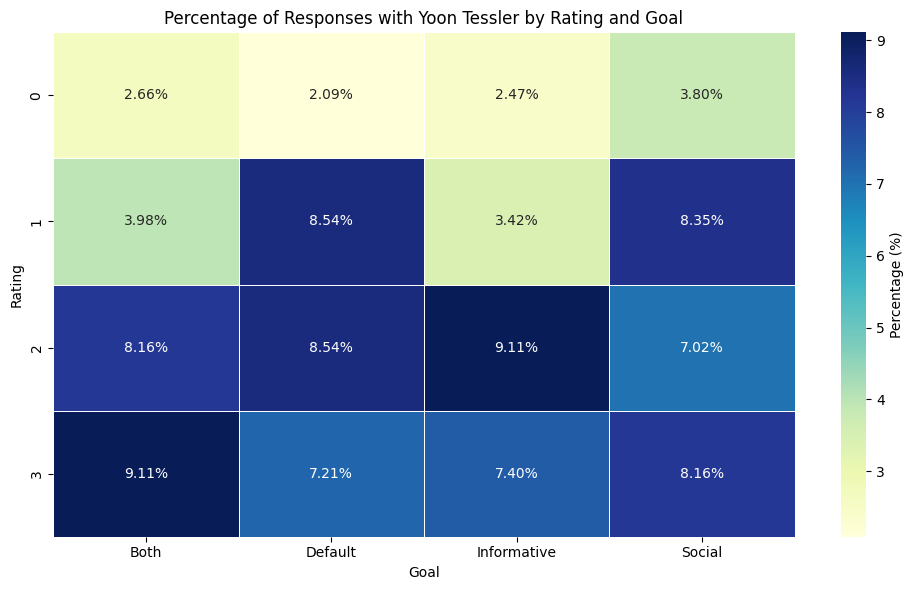

In [18]:
percentage_with_yoon_tessler_0_both = (number_of_0_both / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_0_social = (number_of_0_social / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_0_informative = (number_of_0_informative / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_0_default = (number_of_0_default / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_1_both = (number_of_1_both / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_1_social = (number_of_1_social / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_1_informative = (number_of_1_informative / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_1_default = (number_of_1_default / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_2_both = (number_of_2_both / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_2_social = (number_of_2_social / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_2_informative = (number_of_2_informative / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_2_default = (number_of_2_default / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_3_both = (number_of_3_both / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_3_social = (number_of_3_social / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_3_informative = (number_of_3_informative / all_responses_with_yoon_tessler) * 100
percentage_with_yoon_tessler_3_default = (number_of_3_default / all_responses_with_yoon_tessler) * 100

# generate a table with the results
percentage_with_yoon_tessler_responses_table = pd.DataFrame({
    "Rating+Goal": ["0 - Both", "0 - Social", "0 - Informative", "0 - Default", "1 - Both", "1 - Social", "1 - Informative", "1 - Default", "2 - Both", "2 - Social", "2 - Informative", "2 - Default", "3 - Both", "3 - Social", "3 - Informative", "3 - Default"],
    "Number of Responses": [number_of_0_both, number_of_0_social, number_of_0_informative, number_of_0_default, number_of_1_both, number_of_1_social, number_of_1_informative, number_of_1_default, number_of_2_both, number_of_2_social, number_of_2_informative, number_of_2_default, number_of_3_both, number_of_3_social, number_of_3_informative, number_of_3_default],
    "% with Yoon Tessler": [percentage_with_yoon_tessler_0_both, percentage_with_yoon_tessler_0_social, percentage_with_yoon_tessler_0_informative, percentage_with_yoon_tessler_0_default, percentage_with_yoon_tessler_1_both, percentage_with_yoon_tessler_1_social, percentage_with_yoon_tessler_1_informative, percentage_with_yoon_tessler_1_default, percentage_with_yoon_tessler_2_both, percentage_with_yoon_tessler_2_social, percentage_with_yoon_tessler_2_informative, percentage_with_yoon_tessler_2_default, percentage_with_yoon_tessler_3_both, percentage_with_yoon_tessler_3_social, percentage_with_yoon_tessler_3_informative, percentage_with_yoon_tessler_3_default]
})
# Round the percentages to two decimal places
percentage_with_yoon_tessler_responses_table["% with Yoon Tessler"] = percentage_with_yoon_tessler_responses_table["% with Yoon Tessler"].round(2)

# Create a pivot table for the heatmap
heatmap_data = percentage_with_yoon_tessler_responses_table.copy()
heatmap_data[['Rating', 'Goal']] = heatmap_data['Rating+Goal'].str.split(' - ', expand=True)
heatmap_pivot = heatmap_data.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# Create the heatmap with percentage symbols
plt.figure(figsize=(10, 6))
# Use fmt='.2f' and add % in the annotation text function
sns.heatmap(heatmap_pivot, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5, 
            annot_kws={"size": 10},
            cbar_kws={'label': 'Percentage (%)'})
# Add percentage symbols to annotations
for text in plt.gca().texts:
    text.set_text(text.get_text() + '%')
plt.title('Percentage of Responses with Yoon Tessler by Rating and Goal')
plt.tight_layout()
plt.show()




In [19]:
percentage_with_yoon_tessler_responses_table

Rating+Goal  Number of Responses  % with Yoon Tessler
0          0 - Both                   14                 2.66
1        0 - Social                   20                 3.80
2   0 - Informative                   13                 2.47
3       0 - Default                   11                 2.09
4          1 - Both                   21                 3.98
5        1 - Social                   44                 8.35
6   1 - Informative                   18                 3.42
7       1 - Default                   45                 8.54
8          2 - Both                   43                 8.16
9        2 - Social                   37                 7.02
10  2 - Informative                   48                 9.11
11      2 - Default                   45                 8.54
12         3 - Both                   48                 9.11
13       3 - Social                   43                 8.16
14  3 - Informative                   39                 7.40
15      3 - Default                   38                 7.21

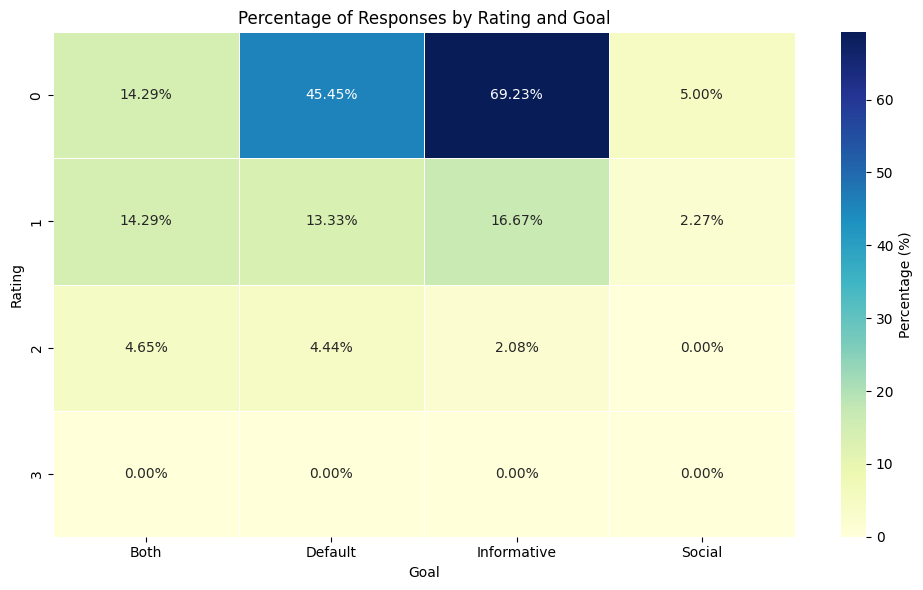

In [20]:
percentage_with_0_both_negation_responses = (number_of_0_both_negation_responses / number_of_0_both) * 100
percentage_with_0_social_negation_responses = (number_of_0_social_negation_responses / number_of_0_social) * 100
percentage_with_0_informative_negation_responses = (number_of_0_informative_negation_responses / number_of_0_informative) * 100
percentage_with_0_default_negation_responses = (number_of_0_default_negation_responses / number_of_0_default) * 100
percentage_with_1_both_negation_responses = (number_of_1_both_negation_responses / number_of_1_both) * 100
percentage_with_1_social_negation_responses = (number_of_1_social_negation_responses / number_of_1_social) * 100
percentage_with_1_informative_negation_responses = (number_of_1_informative_negation_responses / number_of_1_informative) * 100
percentage_with_1_default_negation_responses = (number_of_1_default_negation_responses / number_of_1_default) * 100
percentage_with_2_both_negation_responses = (number_of_2_both_negation_responses / number_of_2_both) * 100
percentage_with_2_social_negation_responses = (number_of_2_social_negation_responses / number_of_2_social) * 100
percentage_with_2_informative_negation_responses = (number_of_2_informative_negation_responses / number_of_2_informative) * 100
percentage_with_2_default_negation_responses = (number_of_2_default_negation_responses / number_of_2_default) * 100
percentage_with_3_both_negation_responses = (number_of_3_both_negation_responses / number_of_3_both) * 100
percentage_with_3_social_negation_responses = (number_of_3_social_negation_responses / number_of_3_social) * 100
percentage_with_3_informative_negation_responses = (number_of_3_informative_negation_responses / number_of_3_informative) * 100
percentage_with_3_default_negation_responses = (number_of_3_default_negation_responses / number_of_3_default) * 100

# generate a table with the results
percentage_with_responses_table = pd.DataFrame({
    "Rating+Goal": ["0 - Both", "0 - Social", "0 - Informative", "0 - Default", "1 - Both", "1 - Social", "1 - Informative", "1 - Default", "2 - Both", "2 - Social", "2 - Informative", "2 - Default", "3 - Both", "3 - Social", "3 - Informative", "3 - Default"],
    "Number of Responses": [number_of_0_both, number_of_0_social, number_of_0_informative, number_of_0_default, number_of_1_both, number_of_1_social, number_of_1_informative, number_of_1_default, number_of_2_both, number_of_2_social, number_of_2_informative, number_of_2_default, number_of_3_both, number_of_3_social, number_of_3_informative, number_of_3_default],
    "% with Responses": [percentage_with_0_both_negation_responses, percentage_with_0_social_negation_responses, percentage_with_0_informative_negation_responses, percentage_with_0_default_negation_responses, percentage_with_1_both_negation_responses, percentage_with_1_social_negation_responses, percentage_with_1_informative_negation_responses, percentage_with_1_default_negation_responses, percentage_with_2_both_negation_responses, percentage_with_2_social_negation_responses, percentage_with_2_informative_negation_responses, percentage_with_2_default_negation_responses, percentage_with_3_both_negation_responses, percentage_with_3_social_negation_responses, percentage_with_3_informative_negation_responses, percentage_with_3_default_negation_responses]
})

# Round the percentages to two decimal places
percentage_with_responses_table["% with Responses"] = percentage_with_responses_table["% with Responses"].round(2)

# Create a pivot table for the heatmap
heatmap_data = percentage_with_responses_table.copy()
heatmap_data[['Rating', 'Goal']] = heatmap_data['Rating+Goal'].str.split(' - ', expand=True)
heatmap_pivot = heatmap_data.pivot(index='Rating', columns='Goal', values='% with Responses')

# Create the heatmap with percentage symbols
plt.figure(figsize=(10, 6))
# Use fmt='.2f' and add % in the annotation text function
sns.heatmap(heatmap_pivot, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5, 
            annot_kws={"size": 10},
            cbar_kws={'label': 'Percentage (%)'})

# Add percentage symbols to annotations
for text in plt.gca().texts:
    text.set_text(text.get_text() + '%')
plt.title('Percentage of Responses by Rating and Goal')
plt.tight_layout()
plt.show()




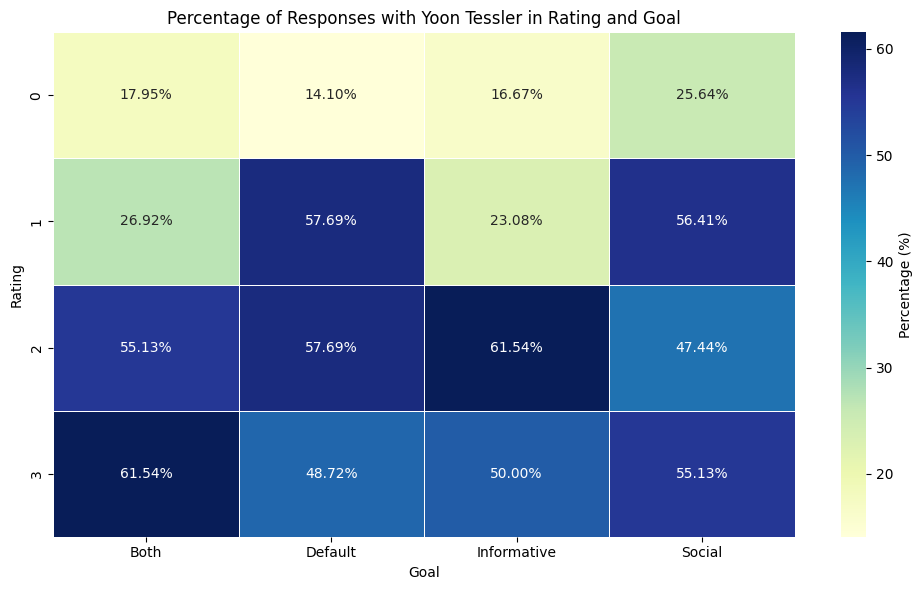

In [21]:
percentage_with_yoon_tessler_0_both_78 = (number_of_0_both / 78) * 100
percentage_with_yoon_tessler_0_social_78 = (number_of_0_social / 78) * 100
percentage_with_yoon_tessler_0_informative_78 = (number_of_0_informative / 78) * 100
percentage_with_yoon_tessler_0_default_78 = (number_of_0_default / 78) * 100
percentage_with_yoon_tessler_1_both_78 = (number_of_1_both / 78) * 100
percentage_with_yoon_tessler_1_social_78 = (number_of_1_social / 78) * 100
percentage_with_yoon_tessler_1_informative_78 = (number_of_1_informative / 78) * 100
percentage_with_yoon_tessler_1_default_78 = (number_of_1_default / 78) * 100
percentage_with_yoon_tessler_2_both_78 = (number_of_2_both / 78) * 100
percentage_with_yoon_tessler_2_social_78 = (number_of_2_social / 78) * 100
percentage_with_yoon_tessler_2_informative_78 = (number_of_2_informative / 78) * 100
percentage_with_yoon_tessler_2_default_78 = (number_of_2_default / 78) * 100
percentage_with_yoon_tessler_3_both_78 = (number_of_3_both / 78) * 100
percentage_with_yoon_tessler_3_social_78 = (number_of_3_social / 78) * 100
percentage_with_yoon_tessler_3_informative_78 = (number_of_3_informative / 78) * 100
percentage_with_yoon_tessler_3_default_78 = (number_of_3_default / 78) * 100

# generate a table with the results
percentage_with_yoon_tessler_responses_table_78 = pd.DataFrame({
    "Rating+Goal": ["0 - Both", "0 - Social", "0 - Informative", "0 - Default", "1 - Both", "1 - Social", "1 - Informative", "1 - Default", "2 - Both", "2 - Social", "2 - Informative", "2 - Default", "3 - Both", "3 - Social", "3 - Informative", "3 - Default"],
    "Number of Responses": [number_of_0_both, number_of_0_social, number_of_0_informative, number_of_0_default, number_of_1_both, number_of_1_social, number_of_1_informative, number_of_1_default, number_of_2_both, number_of_2_social, number_of_2_informative, number_of_2_default, number_of_3_both, number_of_3_social, number_of_3_informative, number_of_3_default],
    "% with Yoon Tessler": [percentage_with_yoon_tessler_0_both_78, percentage_with_yoon_tessler_0_social_78, percentage_with_yoon_tessler_0_informative_78, percentage_with_yoon_tessler_0_default_78, percentage_with_yoon_tessler_1_both_78, percentage_with_yoon_tessler_1_social_78, percentage_with_yoon_tessler_1_informative_78, percentage_with_yoon_tessler_1_default_78, percentage_with_yoon_tessler_2_both_78, percentage_with_yoon_tessler_2_social_78, percentage_with_yoon_tessler_2_informative_78, percentage_with_yoon_tessler_2_default_78, percentage_with_yoon_tessler_3_both_78, percentage_with_yoon_tessler_3_social_78, percentage_with_yoon_tessler_3_informative_78, percentage_with_yoon_tessler_3_default_78]
})
# Round the percentages to two decimal places
percentage_with_yoon_tessler_responses_table_78["% with Yoon Tessler"] = percentage_with_yoon_tessler_responses_table_78["% with Yoon Tessler"].round(2)

# Create a pivot table for the heatmap
heatmap_data = percentage_with_yoon_tessler_responses_table_78.copy()
heatmap_data[['Rating', 'Goal']] = heatmap_data['Rating+Goal'].str.split(' - ', expand=True)
heatmap_pivot = heatmap_data.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# Create the heatmap with percentage symbols
plt.figure(figsize=(10, 6))
# Use fmt='.2f' and add % in the annotation text function
sns.heatmap(heatmap_pivot, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5, 
            annot_kws={"size": 10},
            cbar_kws={'label': 'Percentage (%)'})
# Add percentage symbols to annotations
for text in plt.gca().texts:
    text.set_text(text.get_text() + '%')
plt.title('Percentage of Responses with Yoon Tessler in Rating and Goal')
plt.tight_layout()
plt.show()




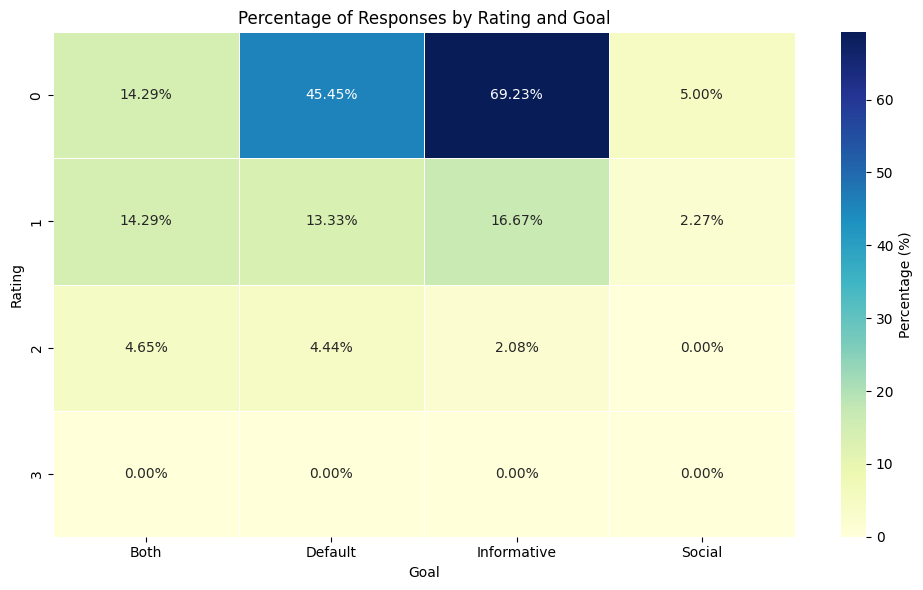

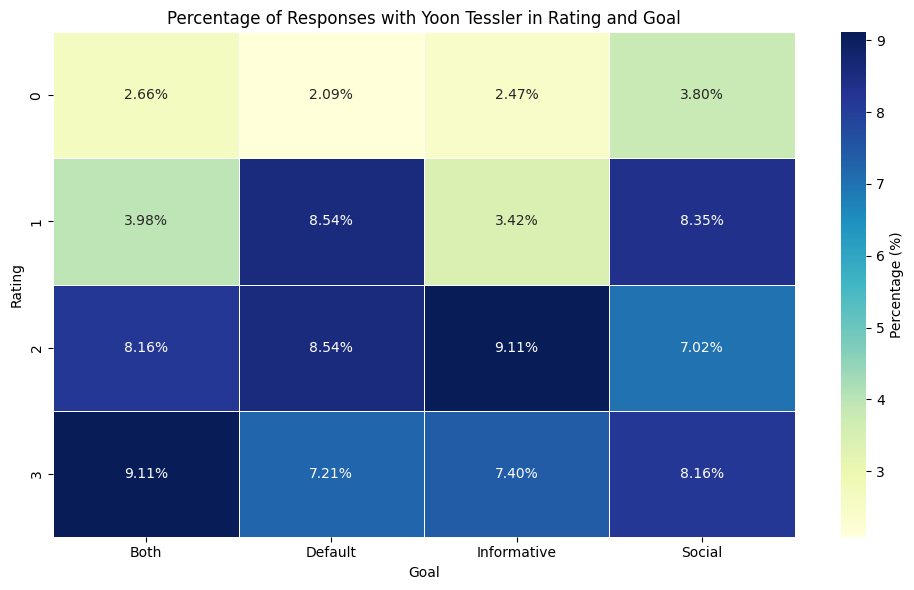

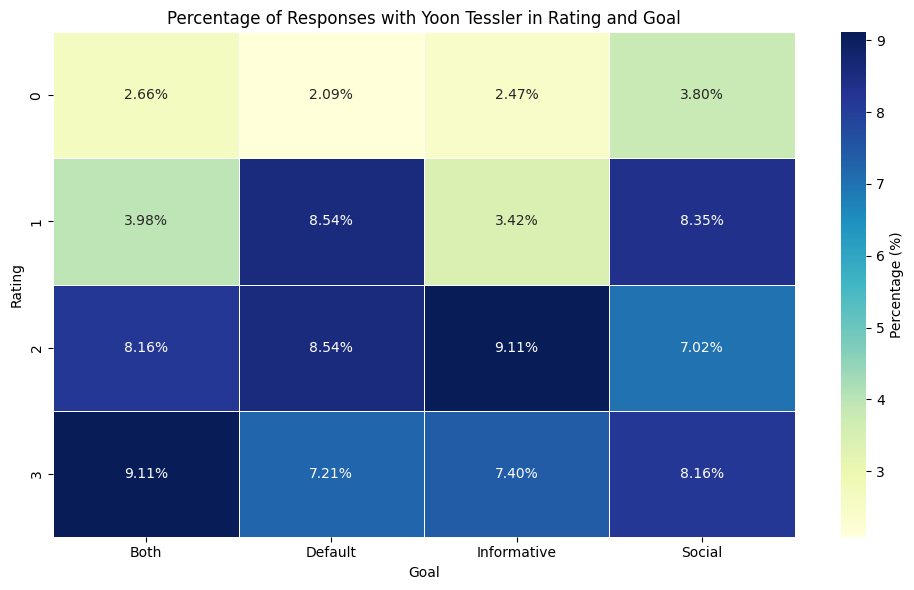

In [22]:

# generate a table with the results
percentage_with_responses_table = pd.DataFrame({
    "Rating+Goal": ["0 - Both", "0 - Social", "0 - Informative", "0 - Default", "1 - Both", "1 - Social", "1 - Informative", "1 - Default", "2 - Both", "2 - Social", "2 - Informative", "2 - Default", "3 - Both", "3 - Social", "3 - Informative", "3 - Default"],
    "Number of Responses": [number_of_0_both, number_of_0_social, number_of_0_informative, number_of_0_default, number_of_1_both, number_of_1_social, number_of_1_informative, number_of_1_default, number_of_2_both, number_of_2_social, number_of_2_informative, number_of_2_default, number_of_3_both, number_of_3_social, number_of_3_informative, number_of_3_default],
    "% with Responses": [percentage_with_0_both_negation_responses, percentage_with_0_social_negation_responses, percentage_with_0_informative_negation_responses, percentage_with_0_default_negation_responses, percentage_with_1_both_negation_responses, percentage_with_1_social_negation_responses, percentage_with_1_informative_negation_responses, percentage_with_1_default_negation_responses, percentage_with_2_both_negation_responses, percentage_with_2_social_negation_responses, percentage_with_2_informative_negation_responses, percentage_with_2_default_negation_responses, percentage_with_3_both_negation_responses, percentage_with_3_social_negation_responses, percentage_with_3_informative_negation_responses, percentage_with_3_default_negation_responses]
})

# Round the percentages to two decimal places
percentage_with_responses_table["% with Responses"] = percentage_with_responses_table["% with Responses"].round(2)

# Create a pivot table for the heatmap
heatmap_data = percentage_with_responses_table.copy()
heatmap_data[['Rating', 'Goal']] = heatmap_data['Rating+Goal'].str.split(' - ', expand=True)
heatmap_pivot = heatmap_data.pivot(index='Rating', columns='Goal', values='% with Responses')

# Create the heatmap with percentage symbols
plt.figure(figsize=(10, 6))
# Use fmt='.2f' and add % in the annotation text function
sns.heatmap(heatmap_pivot, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5, 
            annot_kws={"size": 10},
            cbar_kws={'label': 'Percentage (%)'})

# Add percentage symbols to annotations
for text in plt.gca().texts:
    text.set_text(text.get_text() + '%')
plt.title('Percentage of Responses by Rating and Goal')
plt.tight_layout()
plt.show()

# generate a table with the results
percentage_with_yoon_tessler_responses_table = pd.DataFrame({
    "Rating+Goal": ["0 - Both", "0 - Social", "0 - Informative", "0 - Default", "1 - Both", "1 - Social", "1 - Informative", "1 - Default", "2 - Both", "2 - Social", "2 - Informative", "2 - Default", "3 - Both", "3 - Social", "3 - Informative", "3 - Default"],
    "Number of Responses": [number_of_0_both, number_of_0_social, number_of_0_informative, number_of_0_default, number_of_1_both, number_of_1_social, number_of_1_informative, number_of_1_default, number_of_2_both, number_of_2_social, number_of_2_informative, number_of_2_default, number_of_3_both, number_of_3_social, number_of_3_informative, number_of_3_default],
    "% with Yoon Tessler": [percentage_with_yoon_tessler_0_both, percentage_with_yoon_tessler_0_social, percentage_with_yoon_tessler_0_informative, percentage_with_yoon_tessler_0_default, percentage_with_yoon_tessler_1_both, percentage_with_yoon_tessler_1_social, percentage_with_yoon_tessler_1_informative, percentage_with_yoon_tessler_1_default, percentage_with_yoon_tessler_2_both, percentage_with_yoon_tessler_2_social, percentage_with_yoon_tessler_2_informative, percentage_with_yoon_tessler_2_default, percentage_with_yoon_tessler_3_both, percentage_with_yoon_tessler_3_social, percentage_with_yoon_tessler_3_informative, percentage_with_yoon_tessler_3_default]
})
# Round the percentages to two decimal places
percentage_with_yoon_tessler_responses_table["% with Yoon Tessler"] = percentage_with_yoon_tessler_responses_table["% with Yoon Tessler"].round(2)

# Create a pivot table for the heatmap
heatmap_data = percentage_with_yoon_tessler_responses_table.copy()
heatmap_data[['Rating', 'Goal']] = heatmap_data['Rating+Goal'].str.split(' - ', expand=True)
heatmap_pivot = heatmap_data.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# Create the heatmap with percentage symbols
plt.figure(figsize=(10, 6))
# Use fmt='.2f' and add % in the annotation text function
sns.heatmap(heatmap_pivot, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5, 
            annot_kws={"size": 10},
            cbar_kws={'label': 'Percentage (%)'})
# Add percentage symbols to annotations
for text in plt.gca().texts:
    text.set_text(text.get_text() + '%')
plt.title('Percentage of Responses with Yoon Tessler in Rating and Goal')
plt.tight_layout()
plt.show()



# generate a table with the results
percentage_with_yoon_tessler_responses_table_78 = pd.DataFrame({
    "Rating+Goal": ["0 - Both", "0 - Social", "0 - Informative", "0 - Default", "1 - Both", "1 - Social", "1 - Informative", "1 - Default", "2 - Both", "2 - Social", "2 - Informative", "2 - Default", "3 - Both", "3 - Social", "3 - Informative", "3 - Default"],
    "Number of Responses": [number_of_0_both, number_of_0_social, number_of_0_informative, number_of_0_default, number_of_1_both, number_of_1_social, number_of_1_informative, number_of_1_default, number_of_2_both, number_of_2_social, number_of_2_informative, number_of_2_default, number_of_3_both, number_of_3_social, number_of_3_informative, number_of_3_default],
    "% with Yoon Tessler": [percentage_with_yoon_tessler_0_both_78, percentage_with_yoon_tessler_0_social_78, percentage_with_yoon_tessler_0_informative_78, percentage_with_yoon_tessler_0_default_78, percentage_with_yoon_tessler_1_both_78, percentage_with_yoon_tessler_1_social_78, percentage_with_yoon_tessler_1_informative_78, percentage_with_yoon_tessler_1_default_78, percentage_with_yoon_tessler_2_both_78, percentage_with_yoon_tessler_2_social_78, percentage_with_yoon_tessler_2_informative_78, percentage_with_yoon_tessler_2_default_78, percentage_with_yoon_tessler_3_both_78, percentage_with_yoon_tessler_3_social_78, percentage_with_yoon_tessler_3_informative_78, percentage_with_yoon_tessler_3_default_78]
})
# Round the percentages to two decimal places
percentage_with_yoon_tessler_responses_table["% with Yoon Tessler"] = percentage_with_yoon_tessler_responses_table["% with Yoon Tessler"].round(2)

# Create a pivot table for the heatmap
heatmap_data = percentage_with_yoon_tessler_responses_table.copy()
heatmap_data[['Rating', 'Goal']] = heatmap_data['Rating+Goal'].str.split(' - ', expand=True)
heatmap_pivot = heatmap_data.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# Create the heatmap with percentage symbols
plt.figure(figsize=(10, 6))
# Use fmt='.2f' and add % in the annotation text function
sns.heatmap(heatmap_pivot, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5, 
            annot_kws={"size": 10},
            cbar_kws={'label': 'Percentage (%)'})
# Add percentage symbols to annotations
for text in plt.gca().texts:
    text.set_text(text.get_text() + '%')
plt.title('Percentage of Responses with Yoon Tessler in Rating and Goal')
plt.tight_layout()
plt.show()

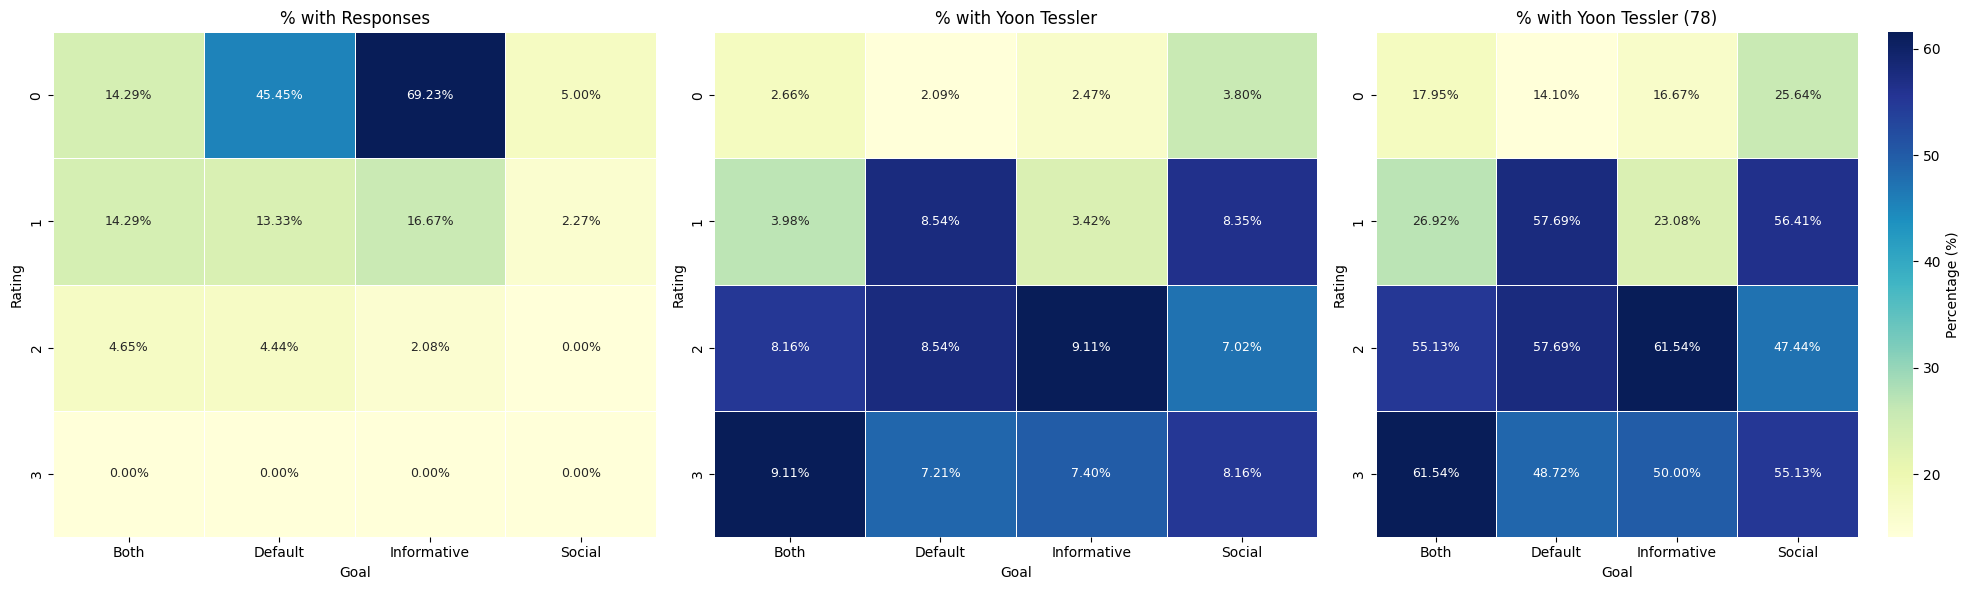

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ----- Heatmap 1: % with Responses -----
df1 = percentage_with_responses_table.copy()
df1[['Rating', 'Goal']] = df1['Rating+Goal'].str.split(' - ', expand=True)
pivot1 = df1.pivot(index='Rating', columns='Goal', values='% with Responses')

# ----- Heatmap 2: % with Yoon Tessler -----
df2 = percentage_with_yoon_tessler_responses_table.copy()
df2[['Rating', 'Goal']] = df2['Rating+Goal'].str.split(' - ', expand=True)
pivot2 = df2.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# ----- Heatmap 3: % with Yoon Tessler (78) -----
df3 = percentage_with_yoon_tessler_responses_table_78.copy()
df3[['Rating', 'Goal']] = df3['Rating+Goal'].str.split(' - ', expand=True)
pivot3 = df3.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# ----- Plot all three heatmaps in one row -----
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Heatmap 1
sns.heatmap(pivot1, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": 9}, ax=axes[0], cbar=False)
axes[0].set_title('% with Responses')
for text in axes[0].texts:
    text.set_text(text.get_text() + '%')

# Heatmap 2
sns.heatmap(pivot2, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": 9}, ax=axes[1], cbar=False)
axes[1].set_title('% with Yoon Tessler')
for text in axes[1].texts:
    text.set_text(text.get_text() + '%')

# Heatmap 3
sns.heatmap(pivot3, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": 9}, ax=axes[2], cbar_kws={'label': 'Percentage (%)'})
axes[2].set_title('% with Yoon Tessler (78)')
for text in axes[2].texts:
    text.set_text(text.get_text() + '%')

plt.tight_layout()



plt.savefig("../plots/combined_heatmaps.pdf", format="pdf", bbox_inches="tight")
plt.show()

# 

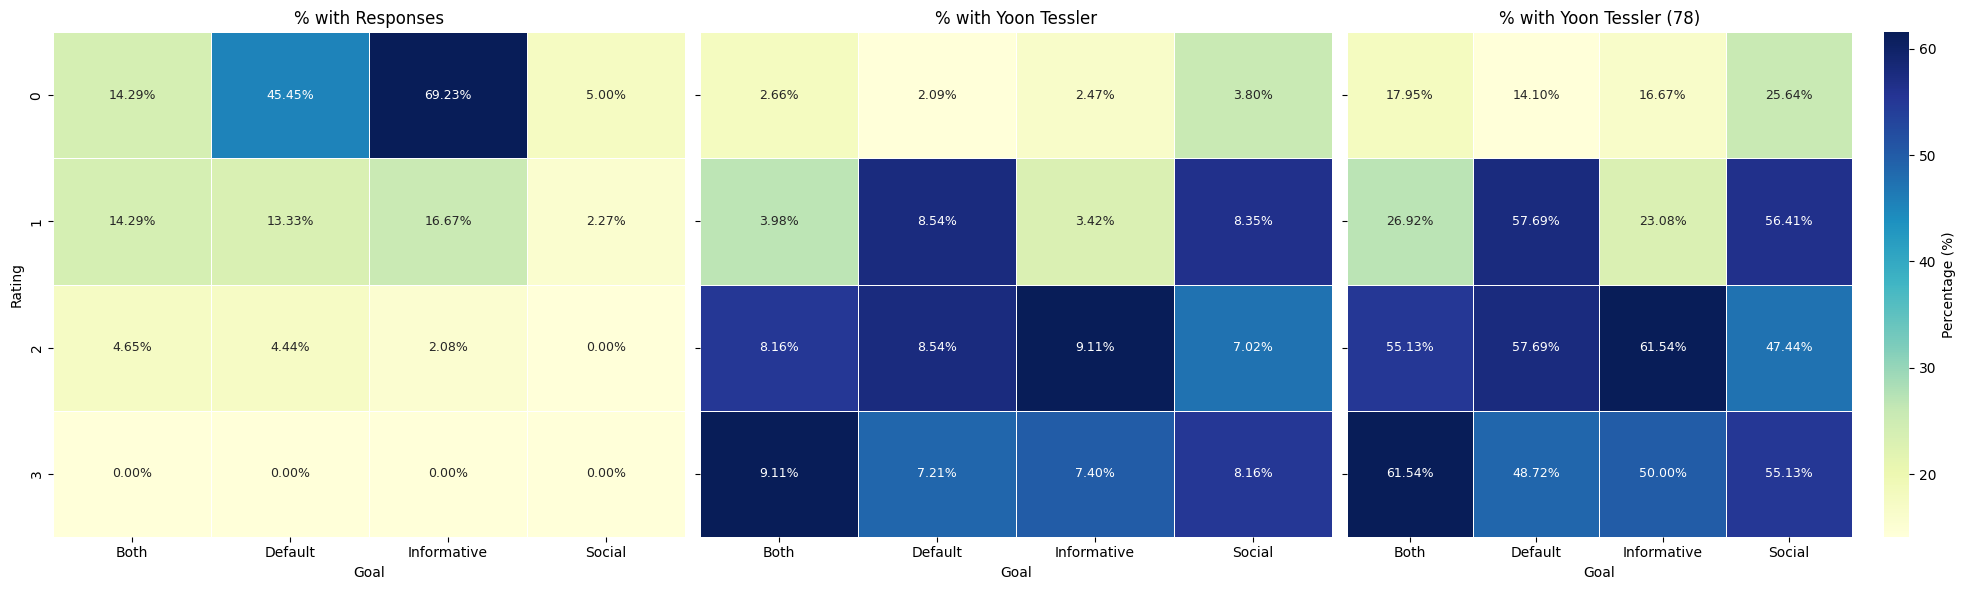

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ----- Heatmap 1: % with Responses -----
df1 = percentage_with_responses_table.copy()
df1[['Rating', 'Goal']] = df1['Rating+Goal'].str.split(' - ', expand=True)
pivot1 = df1.pivot(index='Rating', columns='Goal', values='% with Responses')

# ----- Heatmap 2: % with Yoon Tessler -----
df2 = percentage_with_yoon_tessler_responses_table.copy()
df2[['Rating', 'Goal']] = df2['Rating+Goal'].str.split(' - ', expand=True)
pivot2 = df2.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# ----- Heatmap 3: % with Yoon Tessler (78) -----
df3 = percentage_with_yoon_tessler_responses_table_78.copy()
df3[['Rating', 'Goal']] = df3['Rating+Goal'].str.split(' - ', expand=True)
pivot3 = df3.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# ----- Plot all three heatmaps in one row -----
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Heatmap 1
sns.heatmap(pivot1, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": 9}, ax=axes[0], cbar=False)
axes[0].set_title('% with Responses')
for text in axes[0].texts:
    text.set_text(text.get_text() + '%')

# Heatmap 2
sns.heatmap(pivot2, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": 9}, ax=axes[1], cbar=False)
axes[1].set_title('% with Yoon Tessler')
axes[1].set_ylabel('')
axes[1].set_yticklabels([])  # Hide y-axis labels

for text in axes[1].texts:
    text.set_text(text.get_text() + '%')

# Heatmap 3
sns.heatmap(pivot3, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": 9}, ax=axes[2], cbar_kws={'label': 'Percentage (%)'})
axes[2].set_title('% with Yoon Tessler (78)')
axes[2].set_ylabel('')
axes[2].set_yticklabels([])  # Hide y-axis labels

for text in axes[2].texts:
    text.set_text(text.get_text() + '%')

plt.tight_layout()
plt.savefig("../plots/combined_heatmaps.pdf", format="pdf", bbox_inches="tight")
plt.show()

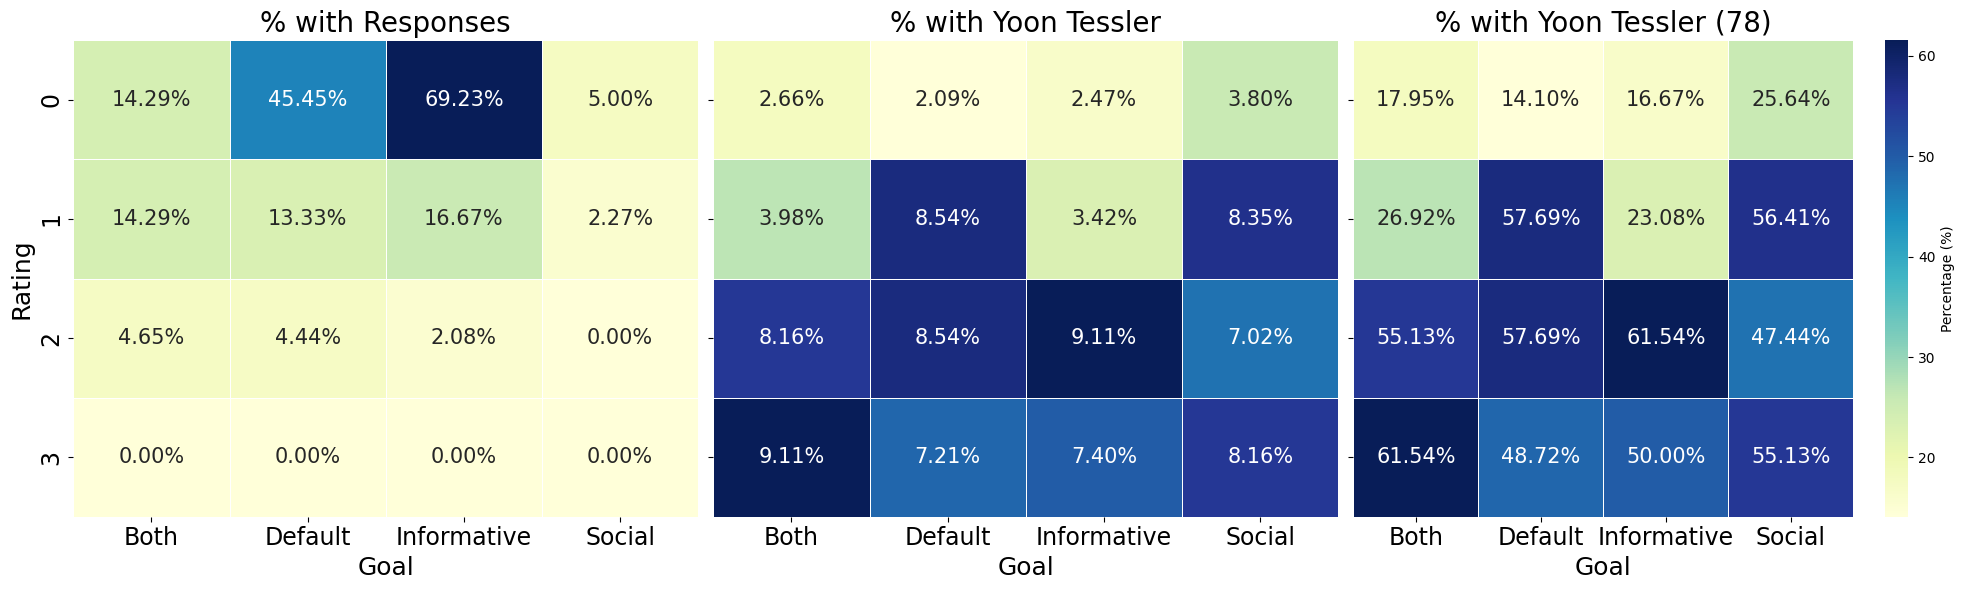

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ----- Heatmap 1: % with Responses -----
df1 = percentage_with_responses_table.copy()
df1[['Rating', 'Goal']] = df1['Rating+Goal'].str.split(' - ', expand=True)
pivot1 = df1.pivot(index='Rating', columns='Goal', values='% with Responses')

# ----- Heatmap 2: % with Yoon Tessler -----
df2 = percentage_with_yoon_tessler_responses_table.copy()
df2[['Rating', 'Goal']] = df2['Rating+Goal'].str.split(' - ', expand=True)
pivot2 = df2.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# ----- Heatmap 3: % with Yoon Tessler (78) -----
df3 = percentage_with_yoon_tessler_responses_table_78.copy()
df3[['Rating', 'Goal']] = df3['Rating+Goal'].str.split(' - ', expand=True)
pivot3 = df3.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# ----- Plot all three heatmaps in one row -----
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Common style parameters
title_fontsize = 20
label_fontsize = 18
tick_fontsize = 17
annot_fontsize = 15

# Heatmap 1
sns.heatmap(pivot1, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": annot_fontsize}, ax=axes[0], cbar=False)
axes[0].set_title('% with Responses', fontsize=title_fontsize)
axes[0].set_xlabel('Goal', fontsize=label_fontsize)
axes[0].set_ylabel('Rating', fontsize=label_fontsize)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)
for text in axes[0].texts:
    text.set_text(text.get_text() + '%')

# Heatmap 2
sns.heatmap(pivot2, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": annot_fontsize}, ax=axes[1], cbar=False)
axes[1].set_title('% with Yoon Tessler', fontsize=title_fontsize)
axes[1].set_xlabel('Goal', fontsize=label_fontsize)
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].tick_params(axis='both', labelsize=tick_fontsize)
for text in axes[1].texts:
    text.set_text(text.get_text() + '%')

# Heatmap 3
sns.heatmap(pivot3, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": annot_fontsize}, ax=axes[2], cbar_kws={'label': 'Percentage (%)'})
axes[2].set_title('% with Yoon Tessler (78)', fontsize=title_fontsize)
axes[2].set_xlabel('Goal', fontsize=label_fontsize)
axes[2].set_ylabel('')
axes[2].set_yticklabels([])
axes[2].tick_params(axis='both', labelsize=tick_fontsize)
for text in axes[2].texts:
    text.set_text(text.get_text() + '%')

plt.tight_layout()
plt.savefig("../plots/combined_heatmaps.pdf", format="pdf", bbox_inches="tight")
plt.show()

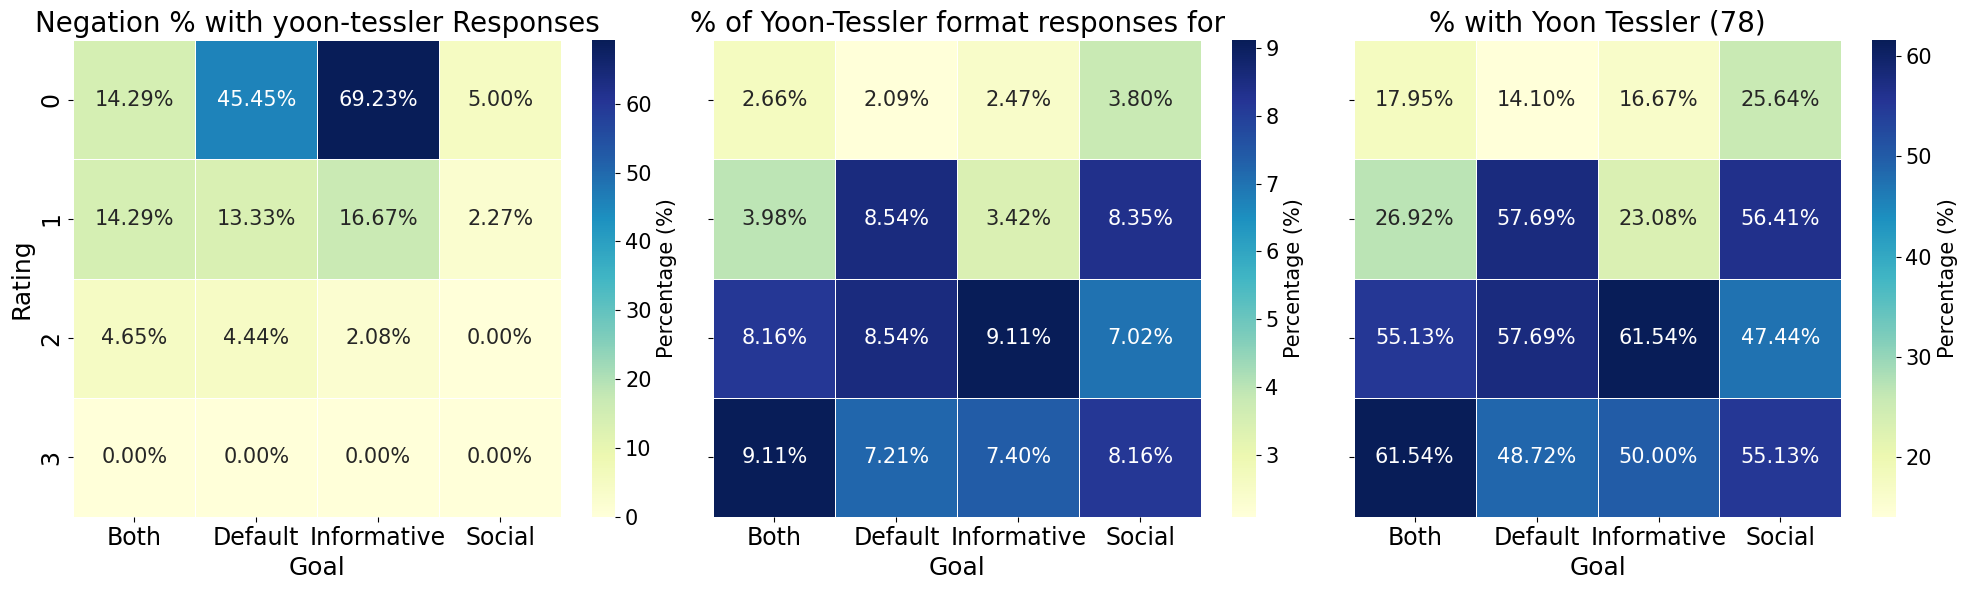

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ----- Heatmap 1: % with Responses -----
df1 = percentage_with_responses_table.copy()
df1[['Rating', 'Goal']] = df1['Rating+Goal'].str.split(' - ', expand=True)
pivot1 = df1.pivot(index='Rating', columns='Goal', values='% with Responses')

# ----- Heatmap 2: % with Yoon Tessler -----
df2 = percentage_with_yoon_tessler_responses_table.copy()
df2[['Rating', 'Goal']] = df2['Rating+Goal'].str.split(' - ', expand=True)
pivot2 = df2.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# ----- Heatmap 3: % with Yoon Tessler (78) -----
df3 = percentage_with_yoon_tessler_responses_table_78.copy()
df3[['Rating', 'Goal']] = df3['Rating+Goal'].str.split(' - ', expand=True)
pivot3 = df3.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# ----- Plot all three heatmaps in one row -----
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Common style parameters
title_fontsize = 20
label_fontsize = 18
tick_fontsize = 17
annot_fontsize = 15
cbar_label_fontsize = 15
cbar_tick_fontsize = 15

# Heatmap 1
sns.heatmap(pivot1, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": annot_fontsize}, ax=axes[0], cbar_kws={'label': 'Percentage (%)'})
axes[0].set_title('Negation % with yoon-tessler Responses', fontsize=title_fontsize)
axes[0].set_xlabel('Goal', fontsize=label_fontsize)
axes[0].set_ylabel('Rating', fontsize=label_fontsize)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)
for text in axes[0].texts:
    text.set_text(text.get_text() + '%')
axes[0].collections[0].colorbar.ax.tick_params(labelsize=cbar_tick_fontsize)
axes[0].collections[0].colorbar.set_label('Percentage (%)', fontsize=cbar_label_fontsize)


# Heatmap 2
sns.heatmap(pivot2, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": annot_fontsize}, ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('% of Yoon-Tessler format responses for', fontsize=title_fontsize)
axes[1].set_xlabel('Goal', fontsize=label_fontsize)
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].tick_params(axis='both', labelsize=tick_fontsize)
for text in axes[1].texts:
    text.set_text(text.get_text() + '%')
axes[1].collections[0].colorbar.ax.tick_params(labelsize=cbar_tick_fontsize)
axes[1].collections[0].colorbar.set_label('Percentage (%)', fontsize=cbar_label_fontsize)


# Heatmap 3
sns.heatmap(pivot3, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": annot_fontsize}, ax=axes[2], cbar_kws={'label': 'Percentage (%)'})
axes[2].set_title('% with Yoon Tessler (78)', fontsize=title_fontsize)
axes[2].set_xlabel('Goal', fontsize=label_fontsize)
axes[2].set_ylabel('')
axes[2].set_yticklabels([])
axes[2].tick_params(axis='both', labelsize=tick_fontsize)
for text in axes[2].texts:
    text.set_text(text.get_text() + '%')
axes[2].collections[0].colorbar.ax.tick_params(labelsize=cbar_tick_fontsize)
axes[2].collections[0].colorbar.set_label('Percentage (%)', fontsize=cbar_label_fontsize)

# Adjust layout with extra horizontal space between plots
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)  # Increase horizontal space between subplots

# Save figure
plt.savefig("../plots/combined_heatmaps.pdf", format="pdf", bbox_inches="tight")
plt.show()

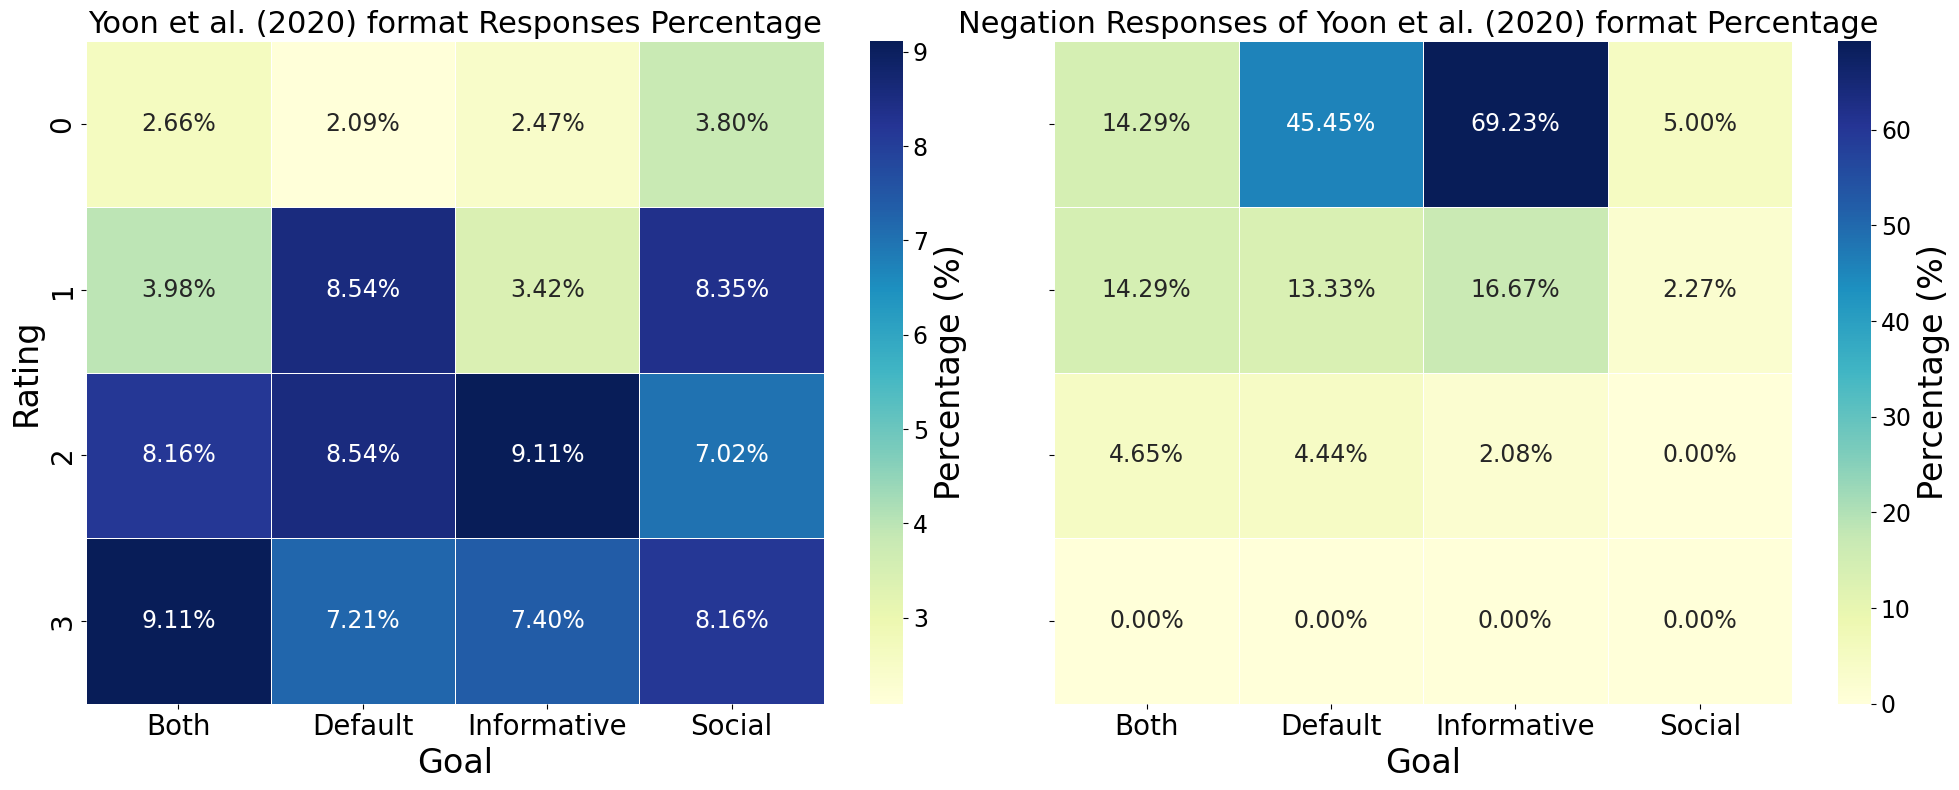

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ----- Heatmap 1: % with Responses -----
df1 = percentage_with_responses_table.copy()
df1[['Rating', 'Goal']] = df1['Rating+Goal'].str.split(' - ', expand=True)
pivot1 = df1.pivot(index='Rating', columns='Goal', values='% with Responses')

# ----- Heatmap 2: % with Yoon Tessler -----
df2 = percentage_with_yoon_tessler_responses_table.copy()
df2[['Rating', 'Goal']] = df2['Rating+Goal'].str.split(' - ', expand=True)
pivot2 = df2.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# ----- Heatmap 3: % with Yoon Tessler (78) -----
df3 = percentage_with_yoon_tessler_responses_table_78.copy()
df3[['Rating', 'Goal']] = df3['Rating+Goal'].str.split(' - ', expand=True)
pivot3 = df3.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')

# ----- Plot all three heatmaps in one row -----
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Common style parameters
title_fontsize = 22
label_fontsize = 24
tick_fontsize = 20
annot_fontsize = 17
cbar_label_fontsize = 24
cbar_tick_fontsize = 17

# Heatmap 1
sns.heatmap(pivot2, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": annot_fontsize}, ax=axes[0], cbar_kws={'label': 'Percentage (%)'})
axes[0].set_title('Yoon et al. (2020) format Responses Percentage', fontsize=title_fontsize)
axes[0].set_xlabel('Goal', fontsize=label_fontsize)
axes[0].set_ylabel('Rating', fontsize=label_fontsize)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)
for text in axes[0].texts:
    text.set_text(text.get_text() + '%')
axes[0].collections[0].colorbar.ax.tick_params(labelsize=cbar_tick_fontsize)
axes[0].collections[0].colorbar.set_label('Percentage (%)', fontsize=cbar_label_fontsize)


# Heatmap 2
sns.heatmap(pivot1, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": annot_fontsize}, ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('Negation Responses of Yoon et al. (2020) format Percentage ', fontsize=title_fontsize)
axes[1].set_xlabel('Goal', fontsize=label_fontsize)
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].tick_params(axis='both', labelsize=tick_fontsize)
for text in axes[1].texts:
    text.set_text(text.get_text() + '%')
axes[1].collections[0].colorbar.ax.tick_params(labelsize=cbar_tick_fontsize)
axes[1].collections[0].colorbar.set_label('Percentage (%)', fontsize=cbar_label_fontsize)


# # Heatmap 3
# sns.heatmap(pivot3, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
#             annot_kws={"size": annot_fontsize}, ax=axes[2], cbar_kws={'label': 'Percentage (%)'})
# axes[2].set_title('% with Yoon Tessler (78)', fontsize=title_fontsize)
# axes[2].set_xlabel('Goal', fontsize=label_fontsize)
# axes[2].set_ylabel('')
# axes[2].set_yticklabels([])
# axes[2].tick_params(axis='both', labelsize=tick_fontsize)
# for text in axes[2].texts:
#     text.set_text(text.get_text() + '%')
# axes[2].collections[0].colorbar.ax.tick_params(labelsize=cbar_tick_fontsize)
# axes[2].collections[0].colorbar.set_label('Percentage (%)', fontsize=cbar_label_fontsize)

# Adjust layout with extra horizontal space between plots
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)  # Increase horizontal space between subplots

# Save figure
plt.savefig("../plots/combined_heatmaps_version2.pdf", format="pdf", bbox_inches="tight")
plt.show()

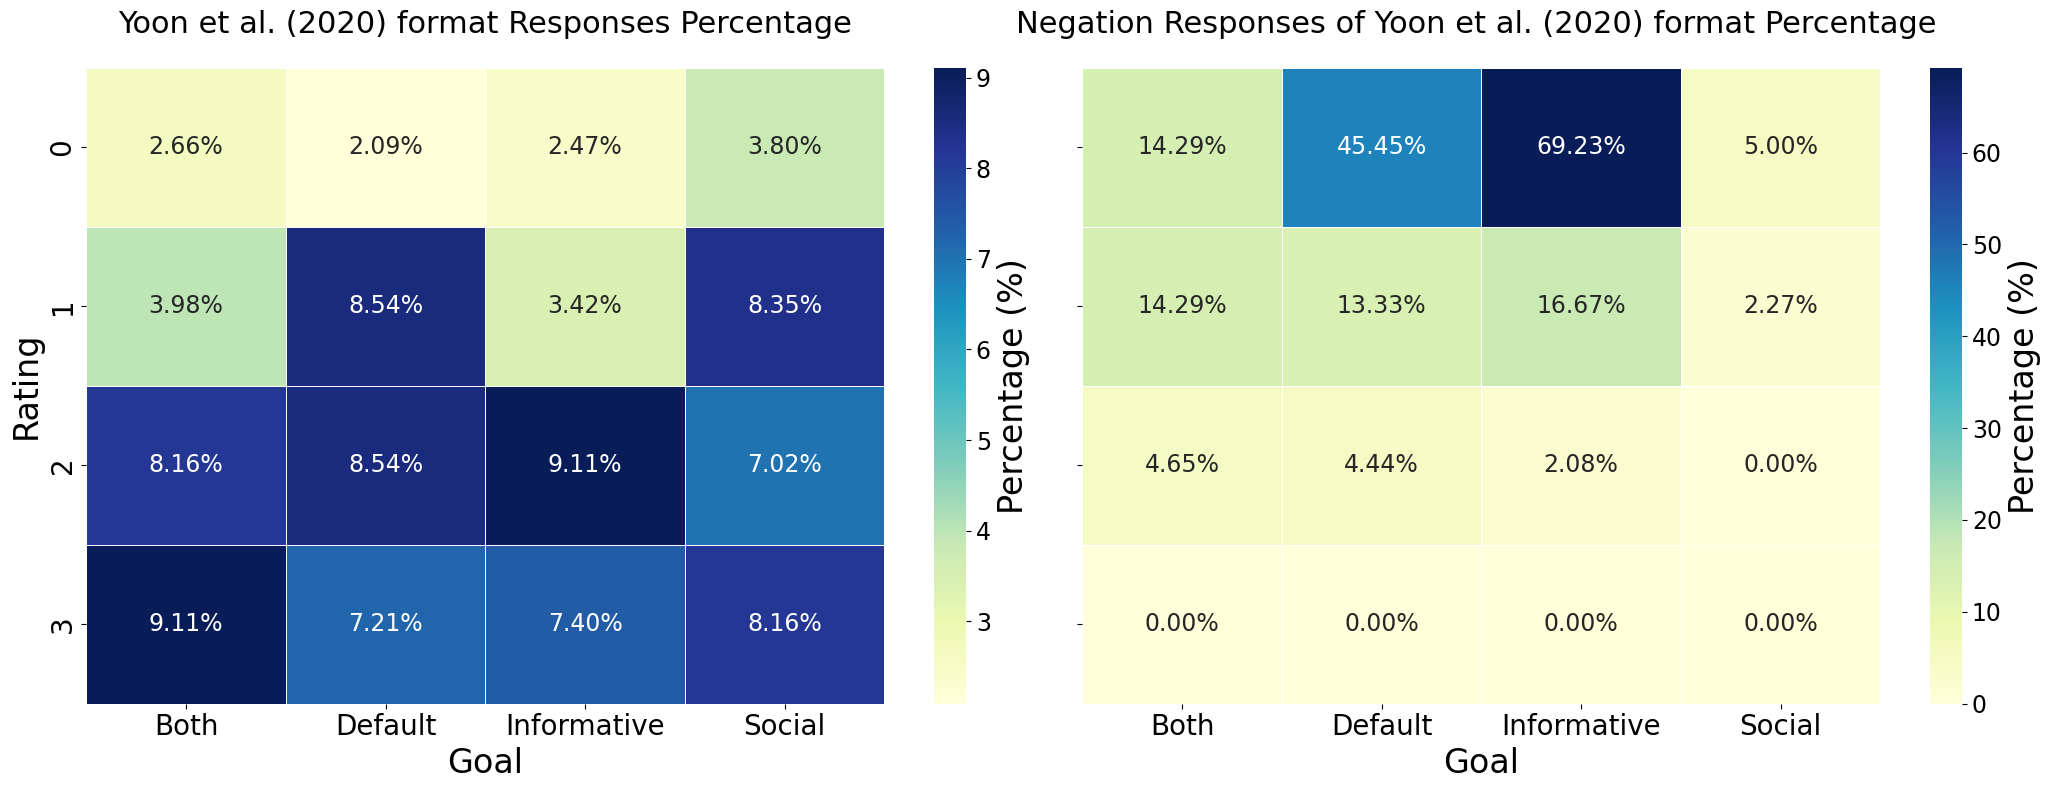

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ----- Heatmap 1: % with Responses -----
df1 = percentage_with_responses_table.copy()
df1[['Rating', 'Goal']] = df1['Rating+Goal'].str.split(' - ', expand=True)
pivot1 = df1.pivot(index='Rating', columns='Goal', values='% with Responses')

# ----- Heatmap 2: % with Yoon Tessler -----
df2 = percentage_with_yoon_tessler_responses_table.copy()
df2[['Rating', 'Goal']] = df2['Rating+Goal'].str.split(' - ', expand=True)
pivot2 = df2.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')


# ----- Plot all three heatmaps in one row -----
fig, axes = plt.subplots(1, 2, figsize=(21, 8))

# Common style parameters
title_fontsize = 22
label_fontsize = 24
tick_fontsize = 20
annot_fontsize = 17
cbar_label_fontsize = 24
cbar_tick_fontsize = 17

# Add title padding parameter - this increases space between title and plot
title_pad = 25  # Increase this value to add more space

# Heatmap 1
sns.heatmap(pivot2, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": annot_fontsize}, ax=axes[0], cbar_kws={'label': 'Percentage (%)'})
axes[0].set_title('Yoon et al. (2020) format Responses Percentage', fontsize=title_fontsize, pad=title_pad)
axes[0].set_xlabel('Goal', fontsize=label_fontsize)
axes[0].set_ylabel('Rating', fontsize=label_fontsize)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)
for text in axes[0].texts:
    text.set_text(text.get_text() + '%')
axes[0].collections[0].colorbar.ax.tick_params(labelsize=cbar_tick_fontsize)
axes[0].collections[0].colorbar.set_label('Percentage (%)', fontsize=cbar_label_fontsize)


# Heatmap 2
sns.heatmap(pivot1, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": annot_fontsize}, ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('Negation Responses of Yoon et al. (2020) format Percentage ', fontsize=title_fontsize, pad=title_pad)
axes[1].set_xlabel('Goal', fontsize=label_fontsize)
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].tick_params(axis='both', labelsize=tick_fontsize)
for text in axes[1].texts:
    text.set_text(text.get_text() + '%')
axes[1].collections[0].colorbar.ax.tick_params(labelsize=cbar_tick_fontsize)
axes[1].collections[0].colorbar.set_label('Percentage (%)', fontsize=cbar_label_fontsize)


# Adjust layout with extra horizontal space between plots
plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)  # Increase horizontal space between subplots

# Save figure
plt.savefig("../plots/combined_heatmaps_version2.pdf", format="pdf", bbox_inches="tight")
plt.show()

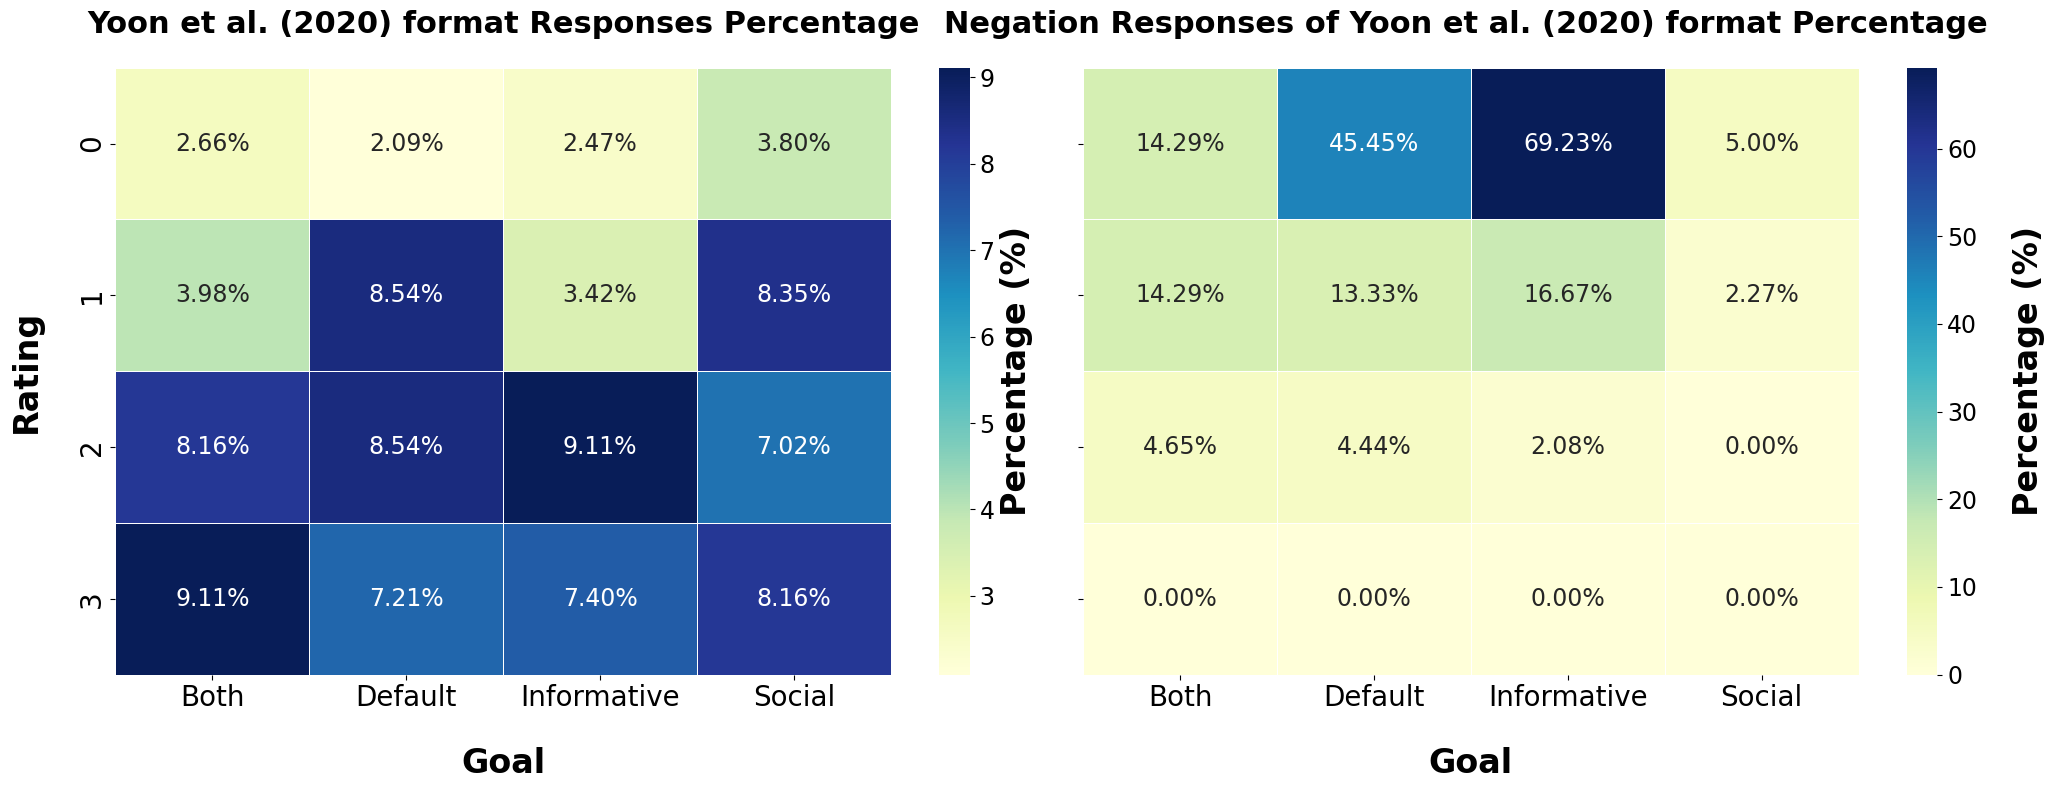

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ----- Heatmap 1: % with Responses -----
df1 = percentage_with_responses_table.copy()
df1[['Rating', 'Goal']] = df1['Rating+Goal'].str.split(' - ', expand=True)
pivot1 = df1.pivot(index='Rating', columns='Goal', values='% with Responses')

# ----- Heatmap 2: % with Yoon Tessler -----
df2 = percentage_with_yoon_tessler_responses_table.copy()
df2[['Rating', 'Goal']] = df2['Rating+Goal'].str.split(' - ', expand=True)
pivot2 = df2.pivot(index='Rating', columns='Goal', values='% with Yoon Tessler')


# ----- Plot all three heatmaps in one row -----
fig, axes = plt.subplots(1, 2, figsize=(21, 8))

# Common style parameters
title_fontsize = 22
label_fontsize = 24
tick_fontsize = 20
annot_fontsize = 17
cbar_label_fontsize = 24
cbar_tick_fontsize = 17

# Add title padding parameter - this increases space between title and plot
title_pad = 25  # Increase this value to add more space

# Heatmap 1
sns.heatmap(pivot2, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": annot_fontsize}, ax=axes[0], cbar_kws={'label': 'Percentage (%)'})
axes[0].set_title('Yoon et al. (2020) format Responses Percentage', fontsize=title_fontsize, 
                 fontweight='bold', pad=title_pad)
axes[0].set_xlabel('Goal', fontsize=label_fontsize, fontweight='bold',  labelpad=25)
axes[0].set_ylabel('Rating', fontsize=label_fontsize, fontweight='bold',  labelpad=25)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)
for text in axes[0].texts:
    text.set_text(text.get_text() + '%')
axes[0].collections[0].colorbar.ax.tick_params(labelsize=cbar_tick_fontsize)
axes[0].collections[0].colorbar.set_label('Percentage (%)', fontsize=cbar_label_fontsize, 
                                         fontweight='bold')


# Heatmap 2
sns.heatmap(pivot1, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5,
            annot_kws={"size": annot_fontsize}, ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('Negation Responses of Yoon et al. (2020) format Percentage ', fontsize=title_fontsize, 
                 fontweight='bold', pad=title_pad)
axes[1].set_xlabel('Goal', fontsize=label_fontsize, fontweight='bold', labelpad=25)
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].tick_params(axis='both', labelsize=tick_fontsize)
for text in axes[1].texts:
    text.set_text(text.get_text() + '%')
axes[1].collections[0].colorbar.ax.tick_params(labelsize=cbar_tick_fontsize)
axes[1].collections[0].colorbar.set_label('Percentage (%)', fontsize=cbar_label_fontsize, 
                                         fontweight='bold', labelpad=25)


# Adjust layout with extra horizontal space between plots
plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)  # Increase horizontal space between subplots

# Save figure
plt.savefig("../plots/combined_heatmaps_version2.pdf", format="pdf", bbox_inches="tight")
plt.show()

1. I need to group the scenarios by human vs. llm
2. I need to group the scenarios by four goals
3. I need to group the scenarios by the ratings


the first is claude

the second is gpt-4o

the third is llama3



the KL-divergence should primarily be about the politeness strategy usage

for politeness markers, the data should be very sparse and not good for this divergence analysis (but I can do it)

the combination of positive and negative politeness strategy in both and other cases

In [274]:
percentage_with_yoon_tessler_responses_table

Rating+Goal  Number of Responses  % with Yoon Tessler
0          0 - Both                   14             2.656546
1        0 - Social                   20             3.795066
2   0 - Informative                   13             2.466793
3       0 - Default                   11             2.087287
4          1 - Both                   21             3.984820
5        1 - Social                   44             8.349146
6   1 - Informative                   18             3.415560
7       1 - Default                   45             8.538899
8          2 - Both                   43             8.159393
9        2 - Social                   37             7.020873
10  2 - Informative                   48             9.108159
11      2 - Default                   45             8.538899
12         3 - Both                   48             9.108159
13       3 - Social                   43             8.159393
14  3 - Informative                   39             7.400380
15      3 - Default                   38             7.210626

In [272]:
number_of_0_both_negation_responses, all_responses_with_yoon_tessler

(2, 527)

In [268]:
14/527

0.026565464895635674

In [205]:
(number_of_0_1_both_social_negation_responses / number_of_0_1_both_social_responses) * 100, (number_of_0_1_negation_responses / number_of_0_1_responses) * 100

(7.07070707070707, 16.129032258064516)

In [215]:
llama_negation_responses

stimulus  \
0  Scenario:\nImagine that Kevin drew a painting,...   

                           llama3_responses  rating         goal  
0   I think your painting is not very good.       0  informative

In [124]:
raw_all_responses.columns

Index(['stimulus', 'claude_responses', 'gpt4o_responses', 'llama3_responses',
       'responses_1', 'responses_2', 'responses_3', 'rating', 'goal'],
      dtype='object')

In [112]:
# claude_responses column to list
claude_responses = raw_all_responses["claude_responses"].tolist()

# gpt4o_responses column to list
gpt_4_1_responses = raw_all_responses["gpt4o_responses"].tolist()

# llama3_responses column to list
llama3_responses = raw_all_responses["llama3_responses"].tolist()

# responses_1 column to list
responses_1 = raw_all_responses["responses_1"].tolist()

# responses_2 column to list
responses_2 = raw_all_responses["responses_2"].tolist()

# responses_3 column to list
responses_3 = raw_all_responses["responses_3"].tolist()


# combine the above six lists into one list
all_responses = claude_responses + gpt_4_1_responses + llama3_responses + responses_1 + responses_2 + responses_3

# now i want to do very simple regex matching/searching

# it's, its, it is, it was, it is not, it's not, its not, it isn't, it isnt,
# it was not, it wasnt, it wasn't, 
# 's, is, was, is not, 's not, isn't, isnt,
# was not, wasn't, wasnt, not

# amazing, okay, bad, terrible, good, decent, nice, ok, awesome, alright, great, favorite, best, acceptable




get the rating and goal for each response, so that I can get to know the goal and rating of each response uses yoon & tessler's strategy and get the ratio where negation is used, how often negation is used, etc.

In [113]:
import re

pattern = r"\b(?:it's|its|it is|it was|it is not|it's not|its not|it isn't|it isnt|it was not|it wasnt|it wasn't|'s|is|was|is not|'s not|isn't|isnt|was not|wasn't|wasnt|not)\b(?:\s+\w+){0,2}?\s+(?:amazing|okay|bad|terrible|good|decent|nice|ok|awesome|alright|fantastic|perfect|excellent|great|favorite|best|acceptable)\b"


matched_yoon_tessler_list = []
for response in all_responses:
    matches = re.findall(pattern, response, re.IGNORECASE)
    if matches:
        matched_yoon_tessler_list.append(matches)



In [114]:
len(matched_yoon_tessler_list) / len(all_responses) * 100, len(matched_yoon_tessler_list), len(all_responses)

(42.2275641025641, 527, 1248)

In [230]:
all_responses_with_yoon_tessler / len(all_responses) * 100

42.1474358974359

In [116]:
negation_pattern = r"\b((?:it is not|it's not|its not|it isn't|it isnt|it was not|it wasnt|it wasn't|is not|'s not|isn't|isnt|was not|wasn't|wasnt|not)(?:\s+\w+){0,2}?\s+(?:amazing|okay|bad|terrible|good|decent|nice|ok|awesome|alright|fantastic|perfect|excellent|great|favorite|best|acceptable))\b"

negation_matched_yoon_tessler_list = []
for response in all_responses:
    negation_matches = re.findall(negation_pattern, response, re.IGNORECASE)
    if negation_matches:
        negation_matched_yoon_tessler_list.append(negation_matches)


In [117]:
len(negation_matched_yoon_tessler_list), len(negation_matched_yoon_tessler_list) / len(all_responses) * 100

(36, 2.8846153846153846)

In [86]:
negation_matched_yoon_tessler_list

# under each  goal and rating combination, do the analysis of the negation

[["wasn't good"],
 ["isn't good"],
 ['is not very good'],
 ["wasn't good"],
 ['is not very good'],
 ['It was not good'],
 ["It's not bad"],
 ['It wasnt bad'],
 ["It's not the best"],
 ['is not very good'],
 ['It was not my favorite'],
 ["It wasn't that good"],
 ['not the best'],
 ['It was not good'],
 ["wasn't good"],
 ['not bad'],
 ['not bad'],
 ['is not that bad'],
 ['Not good'],
 ["it's not my absolute favorite"],
 ["It wasn't too bad"],
 ["It wasn't bad"],
 ['It was not the best'],
 ["It's not bad"],
 ["It wasn't your best"],
 ["It wasn't good"],
 ["It wasn't great"],
 ['not taste very good'],
 ["it wasn't my favorite"],
 ['not be the best'],
 ['was not bad'],
 ["isn't good"],
 ["It wasn't good"],
 ["it's not very good"],
 ['was not your best']]

#### List of experiments



do the gpt-4.1 vs. claude 3.7 comparison through JSD - agreement on the labels between two llms



with human-label:

- compare the ratio of using four strategies (bald-on-record, positive, negative, off-record) across four goals, across four ratings, across humans and llms
- get the JSD for politeness strategies used (specific ones, including subtype) across four goals, across four ratings, across humans and llms
- do a simple ranking by frequency of strategies to get top 10/15 most-used ones


for the analysis of the responses collected and link back to yoon & tessler's paper -- do the old-school simple string match

- it was amazing, okay, bad, terrible, decent, nice, ok, awesome, alright, great, favorite, best, acceptable

- it's great, it was great, it was not great, it wasnt great, it wasn't great, is great, was great, was not great, wasn't great, wasnt great, is not, isn't, isnt, not, its great [adv] [adj]

    - example like: it was not my favorite, it was not the best, 

- wasn't, isn't , not, wasnt, isnt, didnt, did not, didn't,  (get to know in open-ended context, how often do humans/llms generate the negation which is primarily get studies in yoon & tessler's paper)

- it was amazing, okay, bad, terrible



analysis on informative goal group when the rating is 2/3, do the human and llm comparison on the politeness strategies generated - in this way we may want to get a finding that llms gives inapporiate and misuse politeness strategies

analysis on 3 out 3 rating - observing if the politenss strategies mainly positive lexicons and exaggrate

analysis on social with 0 rating - seems like they tends to mainly use positive politeness strategies - it is expected

also i found out llms tend to use very polite words under informative goal in 1 rating or even 0 rating, like '[good] but [bad]' kind of expression

both llms and human tends to be nicer and just loosely follow the goal presented instead of restrictly obey the goal to give responses

'Response: 'I enjoyed it, but it wasn't my favorite. (interesting way to use negation) (2, default)

Politeness marker: I enjoyed it
Politeness strategy:
1. Positive Politeness + Positive Lexicon (positive sentiment, optimism)

Politeness marker: but it wasn't my favorite
Politeness strategy:
1. Negative Politeness + Hedge


'Response: 'You should record and release it. I will be the your manager. (3 both)
Politeness marker: You should record and release it
Politeness strategy:
1. Positive Politeness - Be optimistic
2. Positive Politeness - Offer, promise

Politeness marker: I will be the your manager
Politeness strategy:
1. Positive Politeness - Offer, promise
2. Positive Politeness - Include both speaker and hearer (inclusive 'we')


'Response: 'It needs a lot of work but I know you are up to the challenge. (0, both)
Politeness marker: I know you are up to the challenge.
Politeness strategy:
1. Positive Politeness - Assert speaker’s knowledge of hearer’s wants
2. Positive Politeness - Be optimistic


'Response: 'It was horrible, my eyes are bleeding. (0, informative)
Politeness marker: It was horrible
Politeness strategy:
1. Bald-on-record + Factuality (direct assertions, less polite)

Politeness marker: my eyes are bleeding
Politeness strategy:
1. Off-Record + Overstate
2. Off-Record + Be ironic

'Response: 'Overall, I really enjoyed your movie. I have a few thoughts about it if you want to hear! (2 + informative)
Politeness marker: if you want to hear
Politeness strategy:
1. Negative Politeness - Be conventionally indirect (if you want to hear)

0 + socal case gives response: it was good (link back to yoon & tessler)


'Response: 'I loved your movie! It should be nominated in the oscars. (2 + social)
Politeness marker: I loved your movie!
Politeness strategy:
2. Positive Politeness - Positive Lexicon (positive sentiment, optimism)

Politeness marker: It should be nominated in the oscars.
Politeness strategy:
1. Positive Politeness - Exaggerate interest, approval, sympathy

'Response: 'The movie was really good! I'm excited to see what you do in the future. (2 + default)
Politeness marker: really good
Politeness strategy:
1. Positive Politeness - Positive Lexicon (positive sentiment, optimism)

Politeness marker: I'm excited to see what you do in the future
Politeness strategy:
1. Positive Politeness - Be optimistic
2. Positive Politeness - Intensify interest in hearer


'Response: 'Pretty decent for a beginner, keep it up! (0 + social)
Politeness marker: Pretty decent
Politeness strategy:
1. Positive Politeness + Avoid disagreement

Politeness marker: for a beginner
Politeness strategy:
1. Negative Politeness + Minimize the imposition
2. Off-Record + Presuppose

Politeness marker: keep it up!
Politeness strategy:
1. Positive Politeness + Be optimistic
2. Positive Politeness + Offer, promise


'Response: 'I guess, I would not be the best person who evaluate your performance. (1 + social)
Politeness marker: I guess
Politeness strategy:
1. Negative Politeness + Question, hedge

Politeness marker: I would not be the best person
Politeness strategy:
1. Negative Politeness - Counterfactual modal forms (could/would)

Politeness marker: who evaluate your performance
Politeness strategy:
1. Negative Politeness + Nominalize


'Response: 'It wasn't too bad! But there's some areas that could use some work, maybe I could show you? (1 + default) - nice example to show a bunch of politeness strategies used together
Politeness marker: It wasn't too bad!
Politeness strategy:
1. Positive Politeness - Avoid disagreement

Politeness marker: But there's some areas that could use some work
Politeness strategy:
1. Negative Politeness - Hedge
2. Negative Politeness - Counterfactual modal forms (could/would)

Politeness marker: maybe I could show you?
Politeness strategy:1. Negative Politeness - Question, Hedge
2. Negative Politeness - Counterfactual modal forms (could/would)
3. Positive Politeness - Include both speaker and hearer (inclusive 'we')
4. Positive Politeness - Offer, promise



'Response: 'You have been playing quite a while, I can tell. Maybe sometime we can play together. (2 + both)
Politeness marker: You have been playing quite a while, I can tell.
Politeness strategy:
1. Positive Politeness - Notice, attend to hearer's interests, wants, needs
2. Positive Politeness - Avoid disagreement

Politeness marker: Maybe sometime we can play together.
Politeness strategy:
1. Positive Politeness - Include both speaker and hearer (inclusive 'we')
2. Positive Politeness - Offer, promise
3. Negative Politeness - Question, hedge (Maybe)



'Response: 'I can tell you put a good amount of work into the dance, how about we try it together and we can sharpen the moves and taps as a team?. (0 + default)

Politeness marker: I can tell you put a good amount of work into the dance
Politeness strategy:
1. Positive Politeness - Avoid disagreement
2. Positive Politeness - Notice, attend to hearer's interests, wants, needs

Politeness marker: how about we try it together
Politeness strategy:
1. Positive Politeness - Include both speaker and hearer (inclusive 'we')
2. Positive Politeness - Offer, promise

Politeness marker: we can sharpen the moves and taps as a team
Politeness strategy:
1. Positive Politeness - Include both speaker and hearer (inclusive 'we')
2. Positive Politeness - Be optimistic



'Response: 'It's good but not perfect. (2 + default)
Politeness marker: good but not perfect  
Politeness strategy:  
1. Off-record (Contradictions)


'Response: 'One day, you might be our da vinci. (0 + social about painting)

Politeness marker: One day
Politeness strategy:
1. Positive Politeness - Be optimistic

Politeness marker: you might be
Politeness strategy:
1. Negative Politeness - Question, hedge

Politeness marker: our da vinci
Politeness strategy:
1. Positive Politeness - Exaggerate interest, approval, sympathy
2. Positive Politeness - Include both speaker and hearer (inclusive 'we')



'Response: 'Dude, you need to work on that! (0 + default)
Politeness marker: Dude
Politeness strategy:
1. Positive Politeness - Use in-group identity markers

Politeness marker: you need to work on that
Politeness strategy:
1. Bald-on-Record - Sentence-initial second-person statements (less polite)

'Response: 'Everyone has different tastes, your paining seemed fine. (1 + social)

Politeness marker: Everyone has different tastes
Politeness strategy:
1. Off-Record + Over-generalize
2. Negative Politeness + Impersonalize speaker and hearer

Politeness marker: your painting seemed fine
Politeness strategy:
1. Negative Politeness + Hedge
2. Positive Politeness + Avoid disagreement


'Response: 'In my expert opinion, your painting is fabulous. The composition and colors are outstanding. (3 + both)

Politeness marker: In my expert opinion
Politeness strategy:
1. Negative politeness – Give deference

Politeness marker: fabulous
Politeness strategy:
1. Positive politeness – Positive lexicon (positive sentiment, optimism)

Politeness marker: outstanding
Politeness strategy:
1. Positive politeness – Exaggerate interest, approval, sympathy


'Response: 'Your technique, subject matter, and skills are right on par with other artists of your caliber. (3 + informative)

Politeness marker: right on par
Politeness strategy:
1. Positive Politeness - Positive Lexicon (positive sentiment, optimism)

Politeness marker: with other artists of your caliber
Politeness strategy:
1. Positive Politeness - Presuppose/assert common ground
2. Positive Politeness - Notice, attend to hearer's interests, wants, needs



'Response: 'You were brave to preform, which is amazing! With my practice on voice projection and emotions, your monologue will have an even stronger impact. (0 + both)
Politeness marker: You were brave to preform, which is amazing!
Politeness strategy:
1. Positive Politeness - Positive Lexicon (amazing)

Politeness marker: With my practice on voice projection and emotions,Politeness strategy:
1. Positive Politeness - Give or ask for reasons



'Response: ' I didn't really like it, sorry! (0 + default)
Politeness marker: sorry!
Politeness strategy:
1. Negative Politeness + Apologizing

Respons: it is intersting and unique ( 0 )

Politeness markers: intersting and unique
Politeness strategy:
1. Off-record: be vague


'Response: 'Thanks for sharing your review with me, Patrick! (0 + social)
Politeness marker: Thanks for sharing your review with me
Politeness strategy:
1. Positive Politeness - Gratitude

Politeness marker: Patrick
Politeness strategy:
1. Positive Politeness - Use in-group identity markers


Response: 'Hey I read your review and I think you missed some key points in the book that should really be addressed. (1 + default)

Politeness marker: Hey
Politeness strategy:
1. Positive Politeness - Greeting (social approach)

Politeness marker: I think
Politeness strategy:
1. Negative Politeness - Question, hedge


'Response: 'I thought it was great. It'll help people really gauge the book. (3 + default)

Politeness marker: I thought it was great
Politeness strategy:
1. Positive Politeness + Positive Lexicon (positive sentiment, optimism)

Politeness marker: It'll help people really gauge the book
Politeness strategy:
1. Positive Politeness + Give or ask for reasons


'Response: 'You did all right. Better than those who can't play. (0 + social)

Politeness marker: You did all right
Politeness strategy:
1. Positive Politeness + Avoid disagreement

Politeness marker: Better than those who can't play
Politeness strategy:
1. Off-Record + Give association clues



'Response: 'You looked so confident and elegant on stage! (1 + social)

Politeness marker: You looked so confident and elegant on stage!
Politeness strategy:
1. Positive Politeness - Notice, attend to hearer's interests, wants, needs
2. Positive Politeness - Positive Lexicon (positive sentiment, optimism)
3. Off-Record - Displace hearer (shifts focus from piano playing to appearance/demeanor)


'Response: 'You did really well, emma! It was like music to my ears!! I hope to be as good as you someday! (1 + social)
Politeness marker: You did really well
Politeness strategy:
1. Positive Politeness + Positive Lexicon (positive sentiment, optimism)
2. Positive Politeness + Exaggerate interest, approval, sympathy

Politeness marker: It was like music to my ears!!
Politeness strategy:
1. Positive Politeness + Exaggerate interest, approval, sympathy
2. Off-Record + Use metaphors

Politeness marker: I hope to be as good as you someday!
Politeness strategy:
1. Positive Politeness + Give gifts to hearer (sympathy, understanding, cooperation)



'Response: 'Your performance was great! I have a few tips, would you like to hear them? (2 + both)
Politeness marker: Your performance was great!
Politeness strategy:
1. Positive Politeness - Positive Lexicon (positive sentiment, optimism)

Politeness marker: I have a few tips
Politeness strategy:
1. Negative Politeness - Minimize the imposition
2. Off-Record - Understate

Politeness marker: would you like to hear them?
Politeness strategy:
1. Negative Politeness - Counterfactual modal forms (could/would)
2. Negative Politeness - Be conventionally indirect

for example this example under social goal with 0 rating: 'Response: 'Your cookies are interesting and unique!

Politeness marker: interesting
Politeness strategy:
1. Positive Politeness + Positive Lexicon (positive sentiment, optimism)
2. Off-Record + Understate (not exactly thrilling)

Politeness marker: unique
Politeness strategy:
1. Positive Politeness + Positive Lexicon (positive sentiment, optimism)
2. Off-Record + Be ambiguous 


for example like this: I didn't like the cookie at all. (0 + default)

Politeness marker: I didn't like the cookie at all.
Politeness strategy:
1. Bald-on-record + Factuality (direct assertions, less polite)


interesting response: Response: 'The cookies are very good when its not consumed. (1 + informative)

Politeness marker: very good
Politeness strategy:
1. Positive Politeness - Positive Lexicon (positive sentiment, optimism)

Politeness marker: when its not consumed
Politeness strategy:
1. Off-Record - Be ironic


``there's still a lot of room for learning and improvement" — it appears so many times!!!


Politeness marker: very good presentation
Politeness strategy:
1. Positive Politeness - Avoid disagreement
2. Positive Politeness - Positive Lexicon

Politeness marker: I think
Politeness strategy:
1. Negative Politeness - Question, hedge

Politeness marker: we should do it together next time
Politeness strategy:
1. Positive Politeness - Include both speaker and hearer
2. Positive Politeness - Offer, promise


for cases, where the goal is informative and rating is 0, if the response is like "there is a few places you can improve upon" or "I think it is a bit off" - I consider "a few" and "a bit" as a ``off-record - understate'' strategy

Response: The cake was good, but would probably be better with more efforts. (social + 1)
Politeness marker: good
Politeness strategy:
1. Positive Politeness - Positive Lexicon (positive sentiment, optimism)
Politeness marker: but
Politeness strategy:
1. Off-Record - Contradictions
Politeness marker: would probably be better
Politeness strategy:
1. Negative Politeness - Hedge
2. Negative Politeness - Minimize the imposition 
3. Negative Politeness - Counterfactual modal forms (could/would)

Politeness marker: with more efforts
Politeness strategy:
1. Off-Record - Give hints (with more efforts)


response: Hmmmmmm, I don't know Kyle, not sure what you did, but you either added too much of one thing or not enough of another, can't say for sure. (1 + default)

Politeness marker: Hmmmmmm
Politeness strategy:
1. Off-record - Be ambiguous 

Politeness marker: I don't know Kyle
Politeness strategy:
1. Positive Politeness - Use in-group identity markers

'Response: 'You have good hands. Ever considered opening a bakery? (2 + both)
Politeness marker: Ever considered opening a bakery?
Politeness strategy:
1. Positive Politeness - Exaggerate interest, approval, sympathy

It's not the best cake I've ever tasted. (2 + informative) - another interesting way to use negation

'Response: The cake tastes absolutely delicious and perfectly baked. (2 + social)
Politeness marker: absolutely delicious and perfectly baked
Politeness strategy:
1. Positive Politeness - Positive Lexicon (positive sentiment, optimism)
2. Positive Politeness - Exaggerate interest, approval, sympathy

Politeness marker: James
Politeness strategy:
1. Positive Politeness - Use in-group identity markers


response: I was really looking forward to desert james, thanks for baking that cake. (2 + social)
Politeness marker: I was really looking forward to desert
Politeness strategy:
1. Positive Politeness - Intensify interest in hearer

Politeness marker: James
Politeness strategy:
1. Positive Politeness - Use in-group identity markers

Politeness marker: thanks for baking that cake
Politeness strategy:
1. Positive Politeness - Gratitude

response: 'I have tasted some really good cakes, but I think your cake is one of the best I have tried. (3 + both)

Politeness marker: one of the best I have tried
Politeness strategy:
1. Positive Politeness - Exaggerate interest, approval, sympathy
2. Positive Politeness + Positive Lexicon (positive sentiment, optimism)

Politeness marker: I have tasted some really good cakes, but
Politeness strategy:
1. Positive Politeness - Give or ask for reasons

llama3 response: I think your cake tastes amazing, with a perfect balance of textures and flavors, but I'd suggest tweaking the recipe to see if you can make it even better. ( 3 + informative)

Politeness marker: amazing
Politeness strategy:
1. Positive Politeness - Positive Lexicon

Politeness marker: I'd suggest
Politeness strategy:
1. Negative Politeness - Be conventionally indirect


Respons: This cake was delicious! You did a really good job. You managed to make the cake moist and the frosting not too sweet. (3 +informative)
Politeness marker: This cake was delicious!
Politeness strategy:
1. Positive Politeness - Positive Lexicon (positive sentiment, optimism)

Politeness marker: You did a really good job.
Politeness strategy:
1. Positive Politeness -  Positive Lexicon (positive sentiment, optimism)

Politeness marker: You managed to make the cake moist and the frosting not too sweet.
Politeness strategy:
1. Positive Politeness - Notice, attend to hearer's interests, wants, needs


Response: It was good for your first composed song. Maybe I can help you. ( 0 + both)
Politeness marker: It was good for your first composed song
Politeness strategy:
1. Positive Politeness - Avoid disagreement
2. Positive Politeness - Be optimistic

Politeness marker: Maybe I can help you
Politeness strategy:
1. Negative Politeness - Question, hedge
2. Positive Politeness - Offer, promise


Response: Your song was pretty good (1 + social)

Politeness marker: pretty good
Politeness strategy:
1. Positive Politeness - Positive Lexicon (positive sentiment, optimism)
2. Off-Record - Overstate